# Imports

In [ ]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset
from torch_geometric.data import Data
import cv2
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import random

from torch.nn import Linear
from torch_geometric.nn import GCNConv, VGAE
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import negative_sampling, train_test_split_edges, to_undirected, remove_self_loops
from sklearn.metrics import f1_score


import copy

from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import networkx as nx
from skimage.filters import threshold_otsu, gaussian
from skimage.morphology import skeletonize, binary_dilation
from skimage.transform import resize

import matplotlib.pyplot as plt
import networkx as nx

import torch
from torch_geometric.nn import VGAE
import torch.nn.functional as F
from torch_geometric.nn import GINConv, JumpingKnowledge
from torch.utils.data import ConcatDataset
from copy import deepcopy

import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

from torch_geometric.utils import dense_to_sparse

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# Inladen data

In [ ]:

train_targets = np.load('train_targets2.npy')
val_targets = np.load('val_targets2.npy')
test_targets = np.load('test_targets2.npy')

train_labels = np.load('y_train_targets2.npy')
val_labels = np.load('y_val_targets2.npy')
test_labels = np.load('y_test_targets2.npy')

In [3]:
train_targets = train_targets.squeeze()
val_targets = val_targets.squeeze()
test_targets = test_targets.squeeze()

# Data omzetten graaf structuur

In [ ]:
def resize_with_padding(img, target_size=64, inner_size=60)
    """
    Resize afbeelding proportioneel zodat het in 'inner_size' past
    en vul aan met padding tot 'target_size' x 'target_size'.
    """
    h, w = img.shape
    scale = min(inner_size / h, inner_size / w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized = resize(img, (new_h, new_w), mode='constant', anti_aliasing=True)
    pad_h = target_size - new_h
    pad_w = target_size - new_w
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left
    return np.pad(resized, ((top, bottom), (left, right)), mode='constant', constant_values=0)

def preprocess_image(img, target_size=64, inner_size=60):
    """
    Preprocess een grijswaarde-afbeelding tot een skeleton:
    normalisatie, Otsu-binarisatie, crop, resize, smooth, skeletonize.
    """
    img = img / 255.0 if img.max() > 1 else img
    threshold = threshold_otsu(img)
    binary = img > threshold

    rows, cols = np.any(binary, axis=1), np.any(binary, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    margin = 1
    rmin = max(rmin - margin, 0)
    rmax = min(rmax + margin, img.shape[0] - 1)
    cmin = max(cmin - margin, 0)
    cmax = min(cmax + margin, img.shape[1] - 1)
    cropped = img[rmin:rmax+1, cmin:cmax+1]

    resized = resize_with_padding(cropped, target_size, inner_size)
    smoothed = gaussian(resized, sigma=1.0)
    binary = smoothed > threshold_otsu(smoothed)

    skeleton1 = skeletonize(binary)
    dilated = binary_dilation(skeleton1)
    skeleton = skeletonize(dilated)
    return skeleton

def skeleton_to_graph(skeleton):
    """
    Zet een skeleton afbeelding om naar een graf waarbij pixels knopen zijn
    en randen tussen naburige skeletpunten worden gelegd.
    """
    coords = np.argwhere(skeleton)
    G = nx.Graph()
    for y, x in coords:
        G.add_node((x, y))
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                ny, nx_ = y + dy, x + dx
                if 0 <= ny < skeleton.shape[0] and 0 <= nx_ < skeleton.shape[1]:
                    if skeleton[ny, nx_]:
                        G.add_edge((x, y), (nx_, ny))
    return G

def project_graph_to_grid(G, grid_size=8, image_size=64):
    """
    Projecteer een graf op een raster van formaat grid_size x grid_size.
    Elke knoop wordt gemapt naar een cel en randen tussen cellen worden toegevoegd.
    """
    cell_size = image_size // grid_size
    G_projected = nx.Graph()
    point_to_cell = {}
    added_edges = set()

    for x, y in G.nodes:
        cx = int(x / cell_size)
        cy = int(y / cell_size)
        cell = (cx, cy)
        point_to_cell[(x, y)] = cell
        G_projected.add_node(cell)

    for u, v in G.edges:
        cu = point_to_cell.get(u)
        cv = point_to_cell.get(v)
        if cu and cv and cu != cv:
            edge = tuple(sorted((cu, cv)))
            if edge not in added_edges:
                G_projected.add_edge(*edge)
                added_edges.add(edge)

    return G_projected


def graph_to_pyg_data(G, grid_size=8, label=None):
    """
    Zet een graf om naar een PyTorch Geometric 'Data' object
    met one-hot node features, bidirectionele randen en optioneel een label.
    """
    num_nodes = grid_size * grid_size
    node_index_map = { (x, y): y * grid_size + x for x in range(grid_size) for y in range(grid_size) }

    features = []
    for y in range(grid_size):
         for x in range(grid_size):
            idx = y * grid_size + x
            one_hot = torch.zeros(num_nodes)
            one_hot[idx] = 1.0
            features.append(one_hot)

    x = torch.stack(features) 

    edge_index = []
    for (u, v) in G.edges:
        uid = node_index_map.get(u)
        vid = node_index_map.get(v)
        if uid is not None and vid is not None:
            edge_index.append([uid, vid])
            edge_index.append([vid, uid])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    data = Data(x=x, edge_index=edge_index)

    if label is not None:
        data.y = torch.tensor([label], dtype=torch.long)

    return data


In [ ]:

class PyGSkeletonDataset(Dataset):
    def __init__(self, images, labels=None, grid_size=8):
        self.images = images
        self.labels = labels
        self.grid_size = grid_size
        self.graphs = [self._image_to_graph(img, i) for i, img in enumerate(images)]

    def _image_to_graph(self, img, idx):
        skeleton = preprocess_image(img)
        G = skeleton_to_graph(skeleton)
        G_proj = project_graph_to_grid(G, grid_size=self.grid_size)
        label = self.labels[idx] if self.labels is not None else None
        return graph_to_pyg_data(G_proj, grid_size=self.grid_size, label=label)

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]



class PyGSkeletonDataset(Dataset):
    """
    Dataset-klasse die afbeeldingen omzet in geskeletoniseerde grafen,
    geprojecteerd op een rooster, klaar voor gebruik in PyTorch Geometric.
    """
    def __init__(self, images, labels=None, grid_size=8):
        """
        Initialiseert de dataset door elke afbeelding om te zetten in een PyG graf.
        
        Args:
            images (list or array): Lijst van grijswaarde-afbeeldingen.
            labels (list or array, optional): Optionele labels per afbeelding.
            grid_size (int): Grootte van het raster (bijv. 8 voor 8x8).
        """
        self.images = images
        self.labels = labels
        self.grid_size = grid_size
        self.graphs = [self._image_to_graph(img, i) for i, img in enumerate(images)]

    def _image_to_graph(self, img, idx):
        """
        Zet één afbeelding om naar een geskeletoniseerde, gerasterde graf.
        
        Args:
            img (np.ndarray): Grijswaarde-afbeelding.
            idx (int): Index van de afbeelding, gebruikt om het juiste label te vinden.
        
        Returns:
            torch_geometric.data.Data: Graph-representatie van de afbeelding.
        """
        skeleton = preprocess_image(img)
        G = skeleton_to_graph(skeleton)
        G_proj = project_graph_to_grid(G, grid_size=self.grid_size)
        label = self.labels[idx] if self.labels is not None else None
        return graph_to_pyg_data(G_proj, grid_size=self.grid_size, label=label)

    def __len__(self):
        """
        Geeft het aantal grafen in de dataset.
        """
        return len(self.graphs)

    def __getitem__(self, idx):
        """
        Haalt één PyG graf op uit de dataset.
        
        Args:
            idx (int): Index van het gewenste datapunt.
        
        Returns:
            torch_geometric.data.Data: De graf op positie idx.
        """
        return self.graphs[idx]



In [13]:

# Maak datasets met labels
train_dataset = PyGSkeletonDataset(train_targets, train_labels, grid_size=8)
val_dataset = PyGSkeletonDataset(val_targets, val_labels, grid_size=8)
test_dataset = PyGSkeletonDataset(test_targets, test_labels, grid_size=8)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


## Voorbeeld

In [ ]:

def visualiseer_graph_sample(data, title="Voorbeeldgraaf uit train_loader"):
    """
    Visualiseer een torch_geometric Data object als graaf op 8x8 grid.
    """
    edge_index = data.edge_index.numpy()
    G = nx.Graph()

    # Voeg knopen toe op basis van 8x8 grid
    for i in range(data.x.shape[0]):
        x, y = i % 8, i // 8
        G.add_node(i, pos=(x, y))

    # Voeg randen toe
    for i in range(edge_index.shape[1]):
        u, v = edge_index[:, i]
        G.add_edge(u, v)

    # Plot
    pos = nx.get_node_attributes(G, 'pos')
    plt.figure(figsize=(6, 6))

    # Achtergrondraster
    for y in range(8):
        for x in range(8):
            plt.plot(x, y, 'o', color='lightgray', markersize=5)

    nx.draw(G, pos, node_size=80, node_color='red', edge_color='black', width=2)
    plt.title(title)
    plt.axis('equal')
    plt.xlim(-1, 8)
    plt.ylim(-1, 8)
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.show()


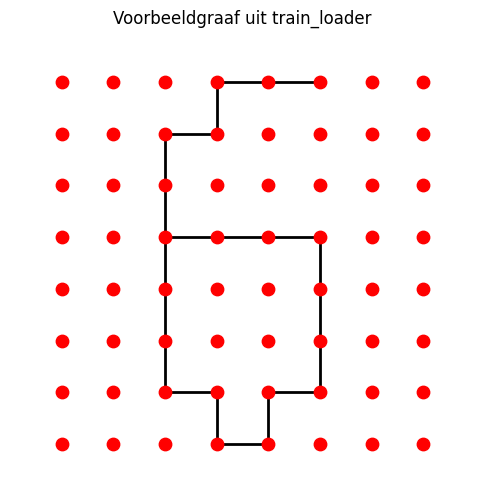

In [ ]:
sample = next(iter(train_loader))  
visualiseer_graph_sample(sample[0]) 

# Vaste corupte dataset

In [ ]:
def zijn_directe_buren(u, v, max_afstand=1):
    """
    Controleert of twee knopen directe buren zijn op een 8x8 grid,
    met een maximaal toegestane afstand (default 1).
    """
    x1, y1 = u % 8, u // 8
    x2, y2 = v % 8, v // 8
    return max(abs(x1 - x2), abs(y1 - y2)) <= max_afstand and (u != v)


def get_local_negative_edges(data, ratio=2.0, max_afstand=1):
    """
    Genereert negatieve edges tussen nabije knopen die niet in de oorspronkelijke graf zitten.
    Bepaalt hoeveel negatives op basis van een ratio t.o.v. positieve edges.
    """
    num_nodes = data.num_nodes
    pos_edges = set(tuple(sorted((u.item(), v.item()))) for u, v in data.edge_index.t())
    candidate_edges = []

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if (i, j) in pos_edges or (j, i) in pos_edges:
                continue
            if zijn_directe_buren(i, j, max_afstand=max_afstand):
                candidate_edges.append([i, j])

    num_pos = data.edge_index.size(1)
    num_neg = min(len(candidate_edges), int(ratio * num_pos))

    perm = torch.randperm(len(candidate_edges))[:num_neg]
    selected = [candidate_edges[i] for i in perm]

    if not selected:
        return torch.empty((2, 0), dtype=torch.long)

    return torch.tensor(selected, dtype=torch.long).t()

def corrupt_graph_val(data, drop_rate=0.25, neg_ratio=2.0, max_afstand=1):
    """
    Corrupt een graf door willekeurige edges te verwijderen (drop_rate)
    en voegt local negative edges toe binnen max_afstand.
    Speciaal voor het genereren van vaste corrupte validatieset
    """
    edge_index = data.edge_index
    edge_index, _ = remove_self_loops(edge_index)

    edges = [tuple(sorted((u.item(), v.item()))) for u, v in edge_index.t()]
    unique_edges = list(set(edges))
    num_total = len(unique_edges)
    num_keep = int((1 - drop_rate) * num_total)

    perm = torch.randperm(num_total)[:num_keep]
    kept_edges = [unique_edges[i] for i in perm]
    kept_edges_tensor = torch.tensor(kept_edges, dtype=torch.long).t()
    edge_index_corrupt = to_undirected(kept_edges_tensor)

    data.edge_index = edge_index_corrupt
    data.pos_edge_label_index = torch.tensor(unique_edges, dtype=torch.long).t()
    data.neg_edge_label_index = get_local_negative_edges(data, ratio=neg_ratio, max_afstand=max_afstand)

    return data

def make_corrupted_dataset(dataset, drop_rate=0, neg_ratio=2.0, max_afstand=1):
    """
    Maakt een nieuwe dataset met corrupte grafen, waarbij per graf
    edges zijn gedropt en negatieve voorbeelden zijn toegevoegd.
    """
    corrupted = []
    for data in dataset:
        data = copy.deepcopy(data)
        corrupted_data = corrupt_graph_val(data, drop_rate=drop_rate, neg_ratio=neg_ratio, max_afstand=max_afstand)
        corrupted.append(corrupted_data)
    return corrupted


In [ ]:
val_dataset_corrupt_0 = make_corrupted_dataset(val_dataset, drop_rate=0)
val_loader_corrupt_0 = DataLoader(val_dataset_corrupt_0, batch_size=16, shuffle=False)
val_dataset_corrupt_1 = make_corrupted_dataset(val_dataset, drop_rate=0.1)
val_loader_corrupt_1 = DataLoader(val_dataset_corrupt_1, batch_size=16, shuffle=False)
val_dataset_corrupt_2 = make_corrupted_dataset(val_dataset, drop_rate=0.2)
val_loader_corrupt_2 = DataLoader(val_dataset_corrupt_2, batch_size=16, shuffle=False)
val_dataset_corrupt_25 = make_corrupted_dataset(val_dataset, drop_rate=0.25)
val_loader_corrupt_25 = DataLoader(val_dataset_corrupt_25, batch_size=16, shuffle=False)
val_dataset_corrupt_3 = make_corrupted_dataset(val_dataset, drop_rate=0.3)
val_loader_corrupt_3 = DataLoader(val_dataset_corrupt_3, batch_size=16, shuffle=False)
val_dataset_corrupt_4 = make_corrupted_dataset(val_dataset, drop_rate=0.4)
val_loader_corrupt_4 = DataLoader(val_dataset_corrupt_4, batch_size=16, shuffle=False)

val_loaders = {
    0.0: val_loader_corrupt_0,
    0.1: val_loader_corrupt_1,
    0.2: val_loader_corrupt_2,
    0.25: val_loader_corrupt_25,
    0.3: val_loader_corrupt_3,
    0.4: val_loader_corrupt_4,
}

# Visualisatiefuncties 

In [ ]:
def reconstruct_edges(data, model, threshold=0.5):
    """
    Reconstrueert een edge index uit modelvoorspellingen.
    Bepaalt voor elk knopenpaar of er een rand bestaat op basis van drempel op predicties.
    """
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)

    # Genereer alle mogelijke nodeparen in grid
    num_nodes = data.num_nodes
    row, col = torch.meshgrid(torch.arange(num_nodes), torch.arange(num_nodes), indexing='ij')
    full_edge_index = torch.stack([row.flatten(), col.flatten()], dim=0).to(device)

    # Decode scores (edge probabilities)
    scores = model.decode(z, full_edge_index).sigmoid()

    # Houd alleen edges boven drempel
    keep = scores > threshold
    edge_index_reconstructed = full_edge_index[:, keep]

    return edge_index_reconstructed.cpu()


def zijn_directe_buren(u, v):
    """Controleer of twee knopen directe buren zijn op een 8x8 raster, inclusief diagonalen."""
    x1, y1 = u % 8, u // 8
    x2, y2 = v % 8, v // 8
    return max(abs(x1 - x2), abs(y1 - y2)) == 1 and (u != v)


def filter_directe_buren(edge_index):
    """Behoud alleen edges tussen directe buren."""
    filtered_edges = []
    for u, v in edge_index.t().tolist():
        if zijn_directe_buren(u, v):
            filtered_edges.append((u, v))
    return torch.tensor(filtered_edges).t()


def plot_graph(ax, edge_index, title, color='b'):
    """
    Plot een graf met knopen in een 8x8 raster op een gegeven subplot-as (ax).
    Maakt gebruik van NetworkX en tekent knopen, randen.
    """
    G = nx.Graph()
    positions = {i: (i % 8, 7 - i // 8) for i in range(64)}  

    edges = edge_index.t().tolist()
    G.add_edges_from(edges)
    G.add_nodes_from(range(64))  

    nx.draw(
        G,
        pos=positions,
        node_size=100,
        edge_color=color,
        node_color='gray',
        with_labels=False,
        ax=ax  
    )

    ax.set_xlim(-0.5, 7.5)
    ax.set_ylim(-0.5, 7.5)
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off') 


def show_comparison(original_data, corrupted_data, reconstructed_edge_index, drop_rate=0.0):
    """
    Vergelijkt originele, corrupte en gereconstrueerde graaf in één figuur.
    Toont visueel effect van corruptie en de prestaties van de reconstructie.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    plot_graph(axes[0], original_data.pos_edge_label_index, "Originele graaf", color='blue')
    titel = f"Kapotte graaf (corruptie: {drop_rate:.2f})"
    plot_graph(axes[1], corrupted_data.edge_index, titel, color='blue')
    plot_graph(axes[2], reconstructed_edge_index, "Gereconstrueerde graaf", color='blue')

    plt.tight_layout()
    plt.show()




# Evaluatiefunctie voor link predictie 


In [ ]:
def evaluate_link_prediction(model, loader, thresholds):
    """
    Evalueert een link prediction model op precision, recall en F1-score
    voor een reeks drempelwaarden op de voorspellingsscores.

    Args:
        model: Het getrainde model met 'encode' en 'decode' methoden.
        loader: DataLoader met batches die pos/neg edge labels bevatten.
        thresholds (list): Lijst met drempelwaarden (floats) voor classificatie.

    Returns:
        List van dicts met precision, recall en f1-score per drempelwaarde.
    """
    all_labels = []
    all_probs = []

    model.eval()
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)

            # Encode stap
            z = model.encode(batch.x, batch.edge_index)

            # Combineer positieve en negatieve edges
            edge_label_index = torch.cat([
                batch.pos_edge_label_index,
                batch.neg_edge_label_index
            ], dim=-1)

            edge_labels = torch.cat([
                torch.ones(batch.pos_edge_label_index.size(1)),
                torch.zeros(batch.neg_edge_label_index.size(1))
            ], dim=0).to(device)

            pred_scores = model.decode(z, edge_label_index).sigmoid()

            all_probs.extend(pred_scores.cpu().numpy())
            all_labels.extend(edge_labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    results = []
    for thresh in thresholds:
        binary_preds = (all_probs >= thresh).astype(int)
        precision = precision_score(all_labels, binary_preds, average='binary', zero_division=0)
        recall = recall_score(all_labels, binary_preds, average='binary', zero_division=0)
        f1 = f1_score(all_labels, binary_preds, average='binary', zero_division=0)
        results.append({
            'threshold': thresh,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })

    return results



# Corruptie van graaf voor training

In [ ]:
def corrupt_graph(data, drop_rate=0.25):
    """
    Corrupt een graaf door een percentage edges willekeurig te verwijderen (edge drop)
    en genereert een gelijk aantal negatieve edges via negative sampling.

    Args:
        data (torch_geometric.data.Data): De originele graaf.
        drop_rate (float): Percentage van de edges dat verwijderd wordt (tussen 0 en 1).

    Returns:
        torch_geometric.data.Data: De aangepaste graaf met:
            - 'edge_index' als corrupte structuur,
            - 'pos_edge_label_index' met originele edges,
            - 'neg_edge_label_index' met gesamplede negatieve edges.
    """
    edge_index = data.edge_index
    edge_index, _ = remove_self_loops(edge_index)

    # Maak set van unieke (gesorteerde) edges
    edges = [tuple(sorted((u.item(), v.item()))) for u, v in edge_index.t()]
    unique_edges = list(set(edges))

    num_total = len(unique_edges)
    num_keep = int((1 - drop_rate) * num_total)

    # Permuteer en selecteer welke te behouden
    perm = torch.randperm(num_total)[:num_keep]
    kept_edges = [unique_edges[i] for i in perm]

    # Zet terug naar edge_index formaat
    kept_edges_tensor = torch.tensor(kept_edges, dtype=torch.long).t()
    edge_index_corrupt = to_undirected(kept_edges_tensor)

    # Genereer negatieve samples (evenveel als positieve)
    neg_edge_index = negative_sampling(
        edge_index=edge_index_corrupt,
        num_nodes=data.num_nodes,
        num_neg_samples=edge_index_corrupt.size(1)
    )

    data.edge_index = edge_index_corrupt
    data.pos_edge_label_index = torch.tensor(unique_edges, dtype=torch.long).t()
    data.neg_edge_label_index = neg_edge_index

    return data


# Iteratief proces:
Zie de scriptie voor een gedetailleerde toelichting op het onderstaande iteratieve proces.


# Model 1: Denoising VGAE

## Modeldefinitie en trainings-/validatiefuncties 


In [78]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

model = VGAE(GCNEncoder(in_channels=64, out_channels=32)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_step(data):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()

    z = model.encode(data.x, data.edge_index)
    pos_edge = data.pos_edge_label_index.to(device)
    neg_edge = data.neg_edge_label_index.to(device)

    loss = model.recon_loss(z, pos_edge, neg_edge)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return loss.item()

def validate_step(data):
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        pos_edge = data.pos_edge_label_index.to(device)
        neg_edge = data.neg_edge_label_index.to(device)
        loss = model.recon_loss(z, pos_edge, neg_edge)
        loss = loss + (1 / data.num_nodes) * model.kl_loss()
    return loss.item()



## Trainloop 


In [79]:

num_epochs = 500
best_val_loss = float('inf')
patience = 20
epochs_no_improve = 0
early_stop = False

train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    num_train_batches = 0
    for data in train_loader:
        data = corrupt_graph(data)
        loss = train_step(data)
        total_loss += loss
        num_train_batches += 1

    total_loss_val = 0
    num_val_batches = 0
    for val_data in val_loader:
        val_data = corrupt_graph(val_data)
        val_loss = validate_step(val_data)
        total_loss_val += val_loss
        num_val_batches += 1

    avg_train_loss = total_loss / num_train_batches
    avg_val_loss = total_loss_val / num_val_batches

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch:03d} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "VGAE1.pt")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch:03d}")
        break


Epoch 001 - Train Loss: 4.1792 - Val Loss: 1.3628
Epoch 002 - Train Loss: 2.9997 - Val Loss: 1.3239
Epoch 003 - Train Loss: 1.8721 - Val Loss: 1.2410
Epoch 004 - Train Loss: 1.3578 - Val Loss: 1.0977
Epoch 005 - Train Loss: 1.1441 - Val Loss: 1.0161
Epoch 006 - Train Loss: 1.0596 - Val Loss: 0.9847
Epoch 007 - Train Loss: 1.0155 - Val Loss: 0.9618
Epoch 008 - Train Loss: 0.9920 - Val Loss: 0.9283
Epoch 009 - Train Loss: 0.9668 - Val Loss: 0.9119
Epoch 010 - Train Loss: 0.9470 - Val Loss: 0.9228
Epoch 011 - Train Loss: 0.9265 - Val Loss: 0.9302
Epoch 012 - Train Loss: 0.9270 - Val Loss: 0.9145
Epoch 013 - Train Loss: 0.9178 - Val Loss: 0.9162
Epoch 014 - Train Loss: 0.9140 - Val Loss: 0.8992
Epoch 015 - Train Loss: 0.9104 - Val Loss: 0.9009
Epoch 016 - Train Loss: 0.9098 - Val Loss: 0.8797
Epoch 017 - Train Loss: 0.9072 - Val Loss: 0.8872
Epoch 018 - Train Loss: 0.8936 - Val Loss: 0.8882
Epoch 019 - Train Loss: 0.9033 - Val Loss: 0.9105
Epoch 020 - Train Loss: 0.8922 - Val Loss: 0.8814


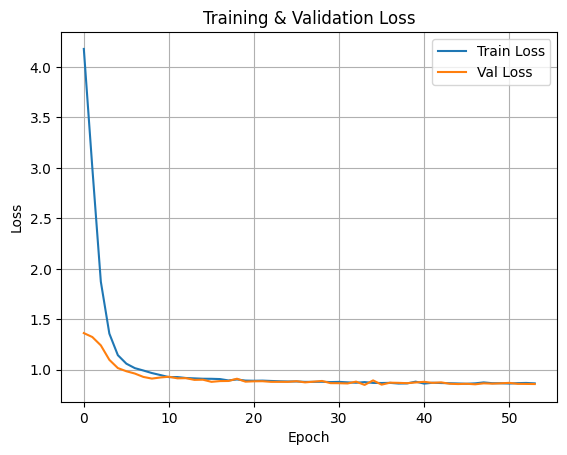

In [ ]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


## Model opslaan/inladen

In [ ]:
# torch.save(model, "VGAE1.pt")

In [82]:
model = torch.load("VGAE1.pt", map_location=device, weights_only=False)
model.eval()


VGAE(
  (encoder): GCNEncoder(
    (conv1): GCNConv(64, 64)
    (conv_mu): GCNConv(64, 32)
    (conv_logstd): GCNConv(64, 32)
  )
  (decoder): InnerProductDecoder()
)

## Resultaten

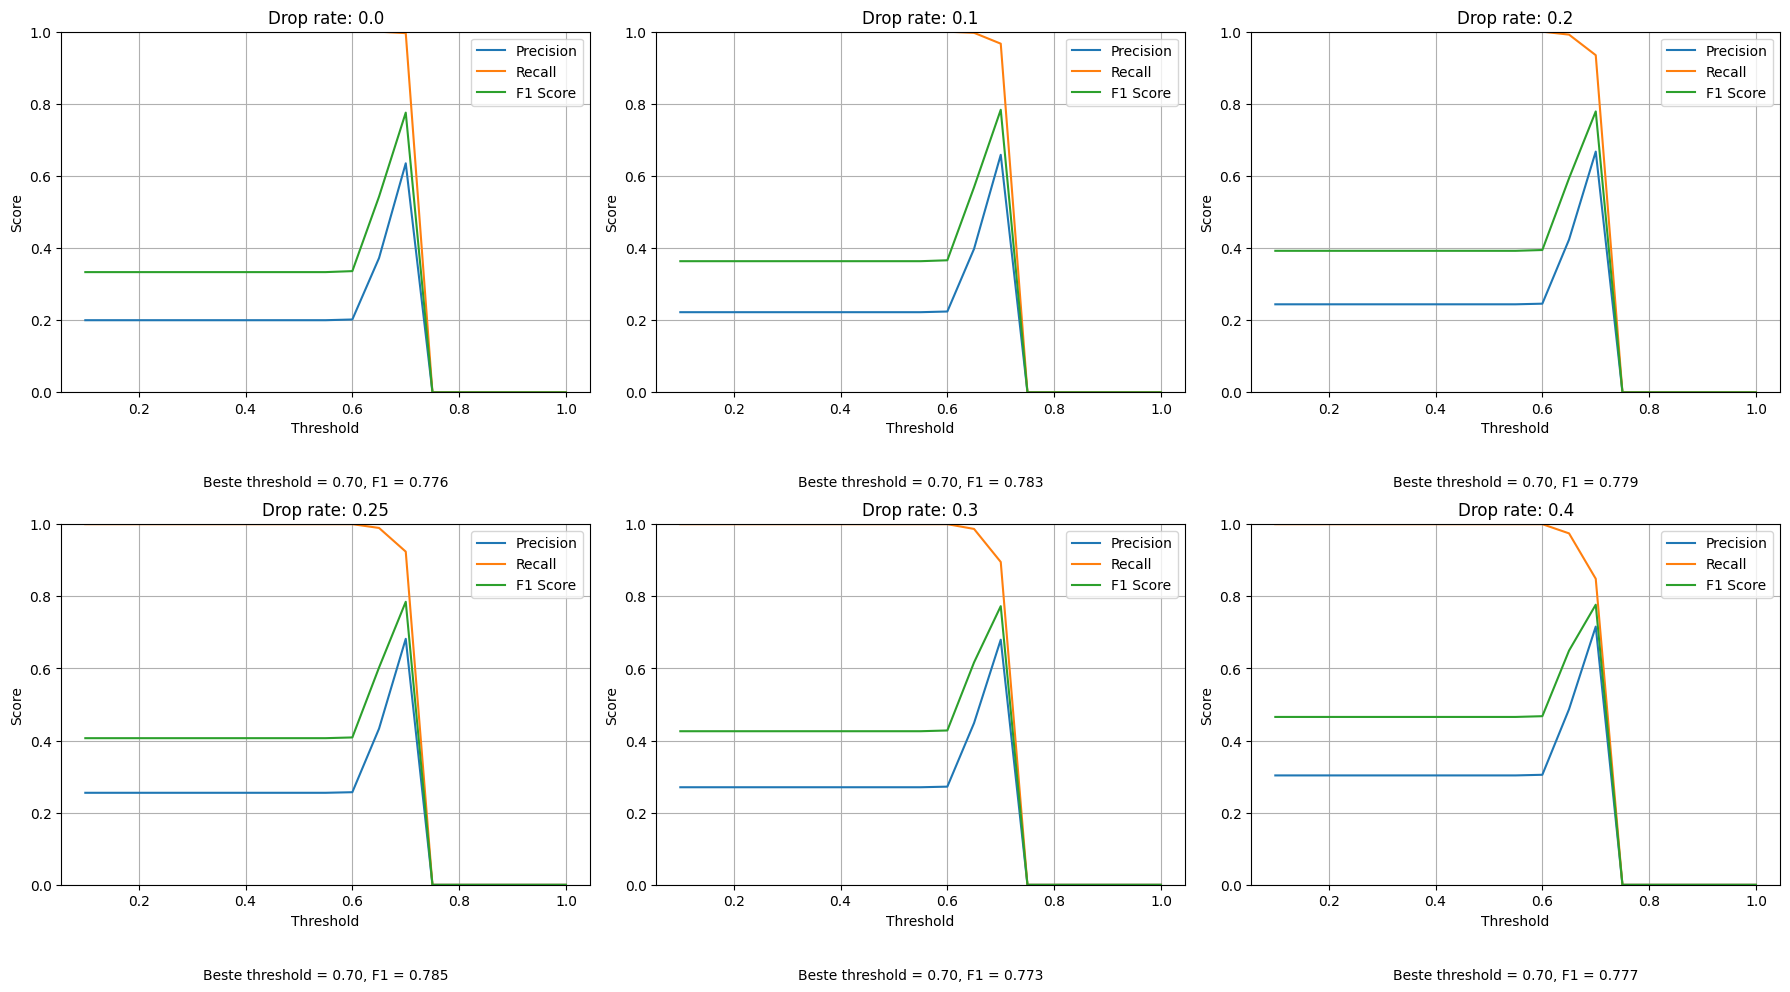

In [83]:
thresholds = thresholds = np.linspace(0.1, 1.0, 19)  # 0.1 tot en met 1.0 in stappen van 0.05

all_results = {}

for drop_rate, loader in val_loaders.items():
    results = evaluate_link_prediction(model, loader, thresholds)
    all_results[drop_rate] = results


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axs = axs.flatten()

for i, (drop_rate, results) in enumerate(sorted(all_results.items())):
    thresholds = [r['threshold'] for r in results]
    precisions = [r['precision'] for r in results]
    recalls = [r['recall'] for r in results]
    f1_scores = [r['f1_score'] for r in results]

    # Beste threshold op basis van hoogste F1
    best_idx = max(range(len(f1_scores)), key=lambda j: f1_scores[j])
    best_thresh = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    ax = axs[i]
    ax.plot(thresholds, precisions, label='Precision')
    ax.plot(thresholds, recalls, label='Recall')
    ax.plot(thresholds, f1_scores, label='F1 Score')

    ax.set_title(f'Drop rate: {drop_rate}')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True)

    # Zet tekst onder de plot
    ax.text(0.5, -0.25,
            f'Beste threshold = {best_thresh:.2f}, F1 = {best_f1:.3f}',
            ha='center', va='center',
            transform=ax.transAxes, fontsize=10)

# Verwijder lege assen als minder dan 6
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


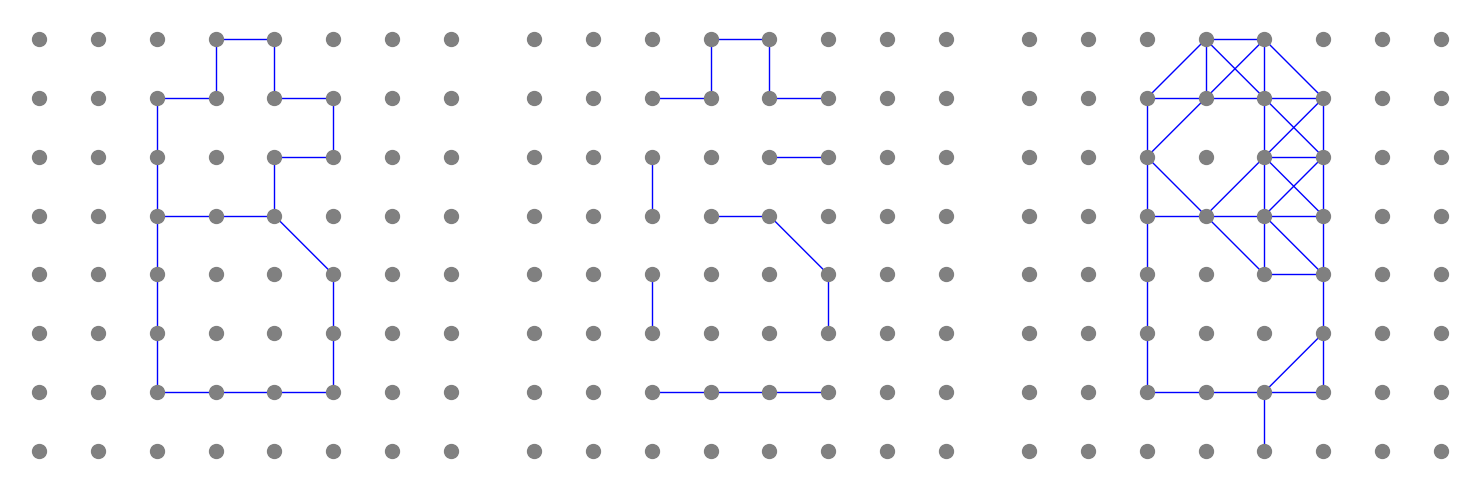

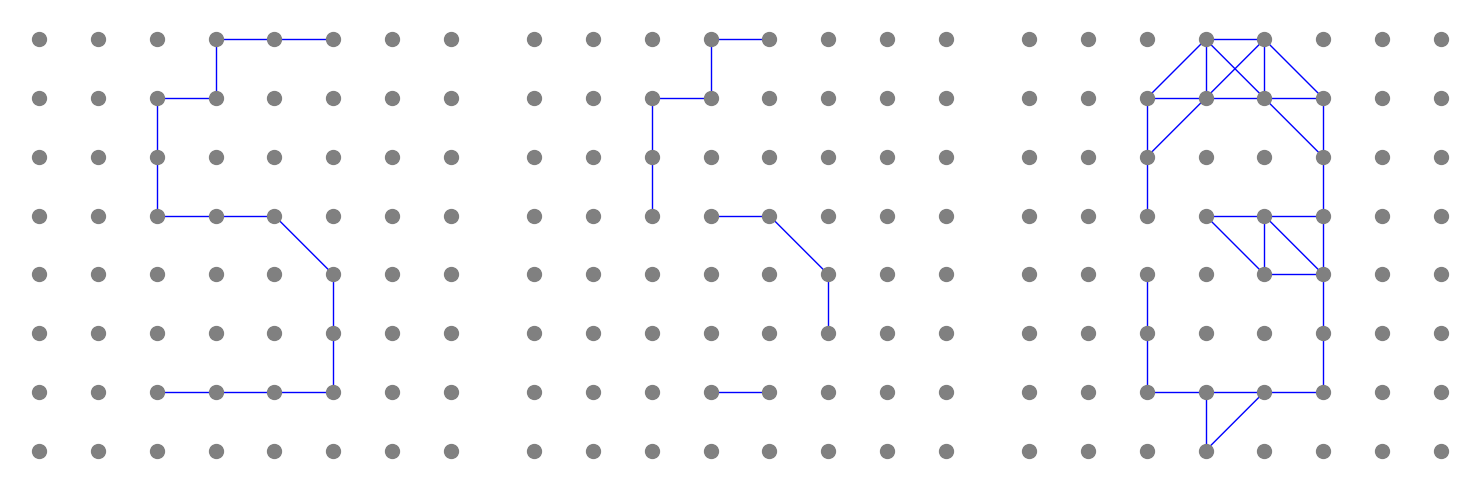

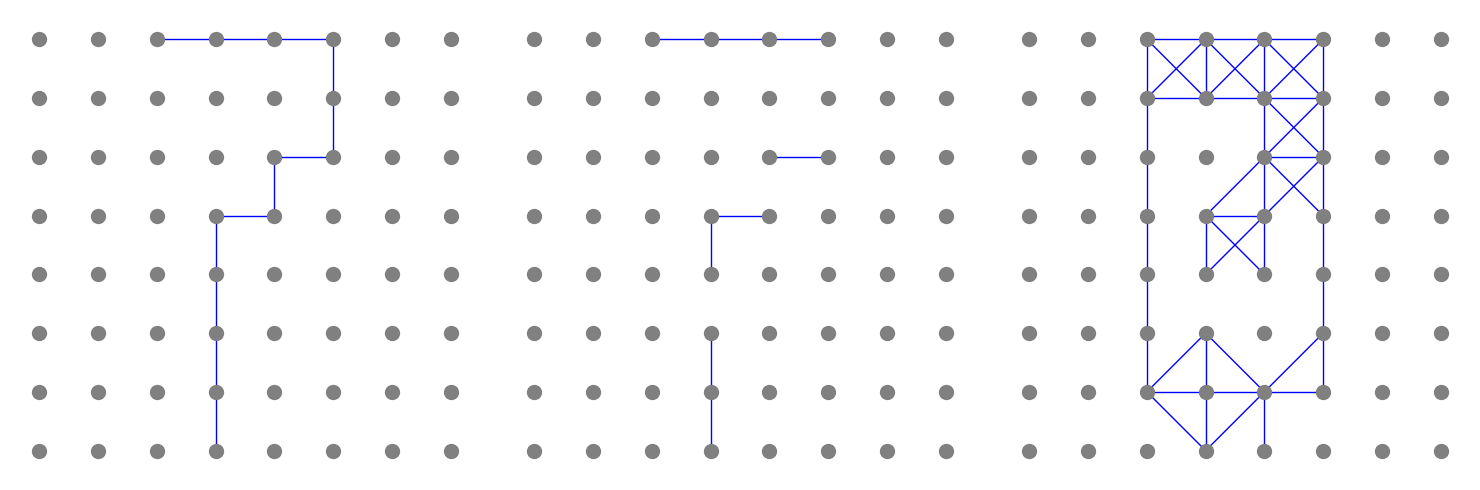

In [ ]:
batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[0])  
original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

drop_rate = 0.3
threshold = 0.7
corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)


reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate 
)


batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[1])  

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)


reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate 
)


batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[10]) 

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)

reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate  
)

# Iteratie 2: GIN

## Modeldefinitie en trainings-/validatiefuncties 

In [ ]:

class GINEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        hidden_dim = 2 * out_channels

        nn1 = torch.nn.Sequential(
            torch.nn.Linear(in_channels, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim)
        )
        self.conv1 = GINConv(nn1)

        nn_mu = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        )
        self.conv_mu = GINConv(nn_mu)

        nn_logstd = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        )
        self.conv_logstd = GINConv(nn_logstd)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


model = VGAE(GINEncoder(in_channels=64, out_channels=32)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_step(data):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()

    z = model.encode(data.x, data.edge_index)
    pos_edge = data.pos_edge_label_index.to(device)
    neg_edge = data.neg_edge_label_index.to(device)

    loss = model.recon_loss(z, pos_edge, neg_edge)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return loss.item()

def validate_step(data):
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        pos_edge = data.pos_edge_label_index.to(device)
        neg_edge = data.neg_edge_label_index.to(device)
        loss = model.recon_loss(z, pos_edge, neg_edge)
        loss = loss + (1 / data.num_nodes) * model.kl_loss()
    return loss.item()


## Trainloop 

In [ ]:
num_epochs = 500
best_val_loss = float('inf')
patience = 20
epochs_no_improve = 0
early_stop = True

train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    num_train_batches = 0
    for data in train_loader:
        data = corrupt_graph(data)
        loss = train_step(data)
        total_loss += loss
        num_train_batches += 1

    total_loss_val = 0
    num_val_batches = 0
    for val_data in val_loader:
        val_data = corrupt_graph(val_data)
        val_loss = validate_step(val_data)
        total_loss_val += val_loss
        num_val_batches += 1

    avg_train_loss = total_loss / num_train_batches
    avg_val_loss = total_loss_val / num_val_batches

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch:03d} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "VGAE2.pt")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch:03d}")
        break

Epoch 001 - Train Loss: 3.6985 - Val Loss: 1.1886
Epoch 002 - Train Loss: 1.3970 - Val Loss: 1.0726
Epoch 003 - Train Loss: 1.0618 - Val Loss: 1.0400
Epoch 004 - Train Loss: 1.0439 - Val Loss: 1.0468
Epoch 005 - Train Loss: 1.0486 - Val Loss: 1.0185
Epoch 006 - Train Loss: 1.0267 - Val Loss: 1.0419
Epoch 007 - Train Loss: 1.0233 - Val Loss: 1.0120
Epoch 008 - Train Loss: 0.9953 - Val Loss: 1.0008
Epoch 009 - Train Loss: 0.9727 - Val Loss: 0.9790
Epoch 010 - Train Loss: 0.9664 - Val Loss: 0.9753
Epoch 011 - Train Loss: 0.9638 - Val Loss: 0.9642
Epoch 012 - Train Loss: 0.9547 - Val Loss: 0.9248
Epoch 013 - Train Loss: 0.9446 - Val Loss: 0.9134
Epoch 014 - Train Loss: 0.9331 - Val Loss: 0.9196
Epoch 015 - Train Loss: 0.9264 - Val Loss: 0.9048
Epoch 016 - Train Loss: 0.9128 - Val Loss: 0.8937
Epoch 017 - Train Loss: 0.9048 - Val Loss: 0.8973
Epoch 018 - Train Loss: 0.9065 - Val Loss: 0.9017
Epoch 019 - Train Loss: 0.8975 - Val Loss: 0.9012
Epoch 020 - Train Loss: 0.8889 - Val Loss: 0.8992


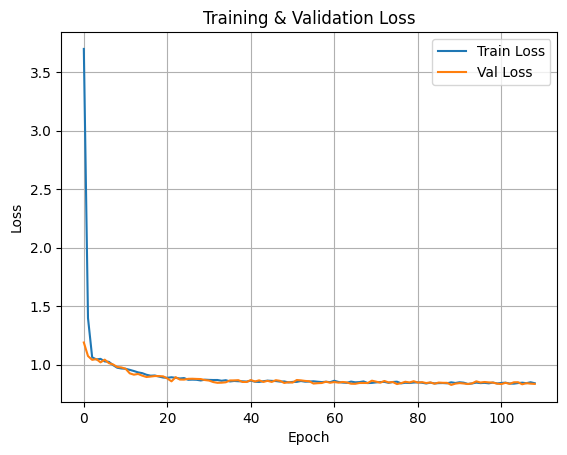

In [207]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()



## Model opslaan/inladen


In [ ]:
# torch.save(model, "VGAE2.pt")


In [153]:
model = torch.load("VGAE2.pt", map_location=device, weights_only=False)
model.eval()


VGAE(
  (encoder): GINEncoder(
    (conv1): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    ))
    (conv_mu): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
    (conv_logstd): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
  )
  (decoder): InnerProductDecoder()
)

## Resultaten

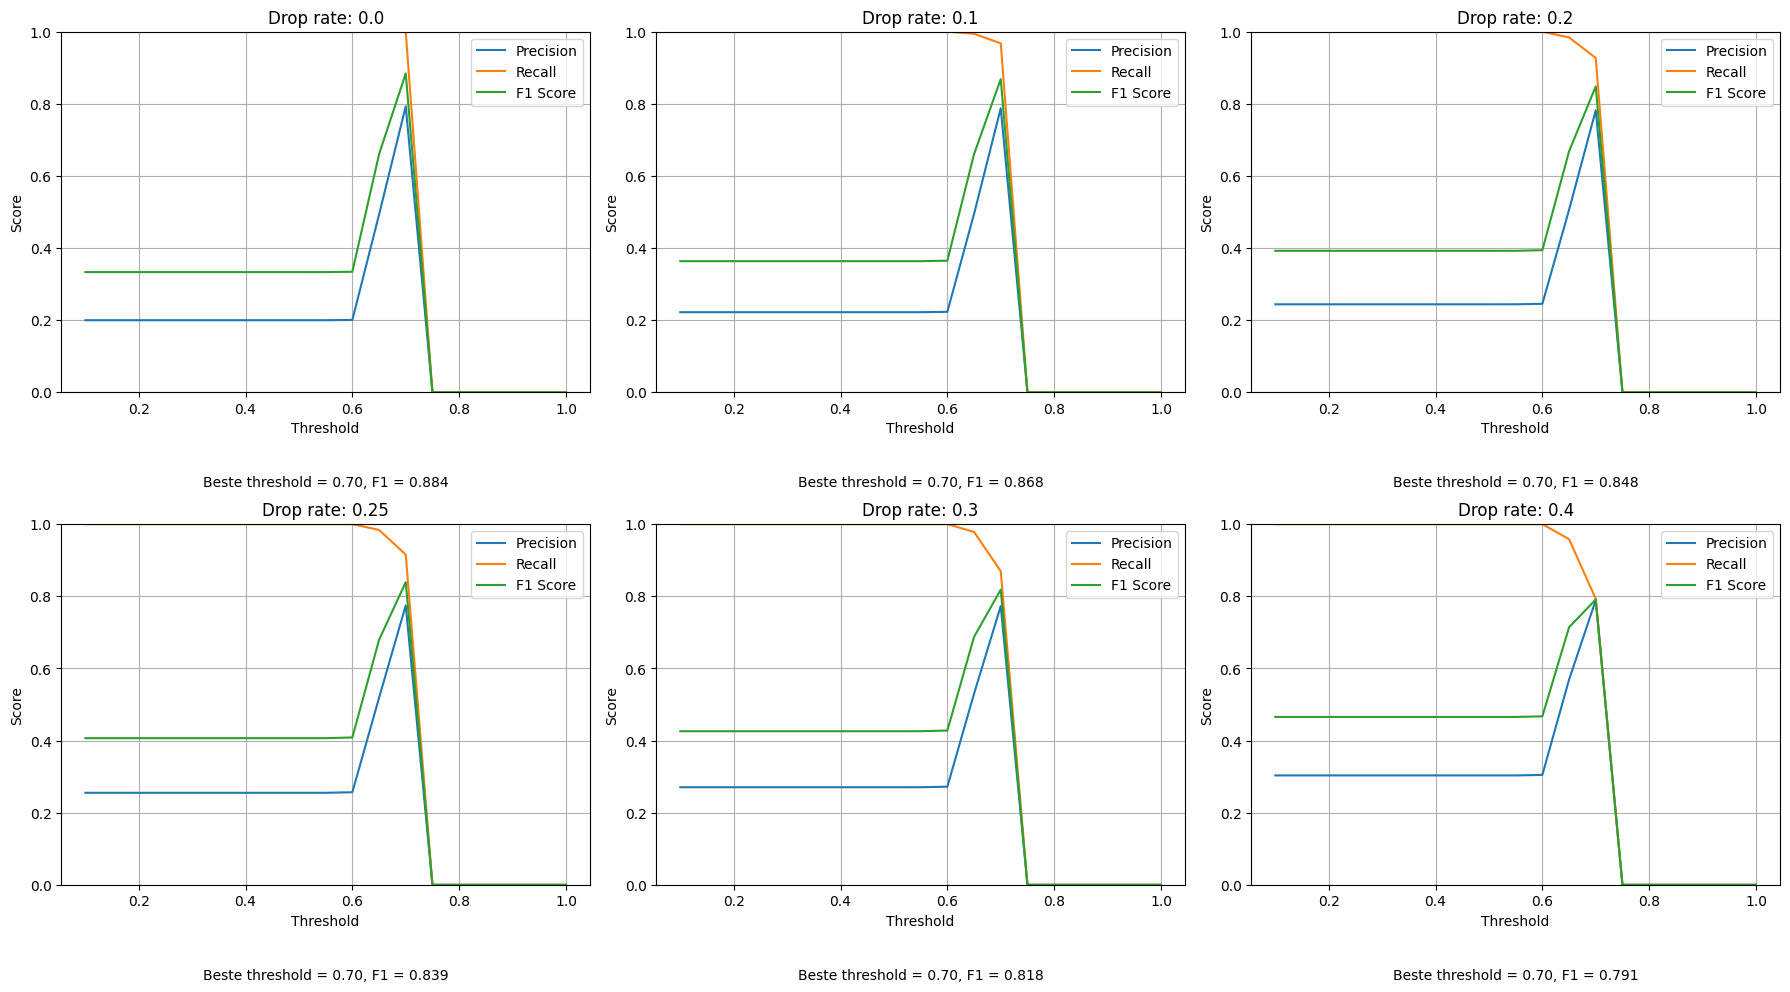

In [ ]:
thresholds = thresholds = np.linspace(0.1, 1.0, 19)  

all_results = {}

for drop_rate, loader in val_loaders.items():
    results = evaluate_link_prediction(model, loader, thresholds)
    all_results[drop_rate] = results


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axs = axs.flatten()

for i, (drop_rate, results) in enumerate(sorted(all_results.items())):
    thresholds = [r['threshold'] for r in results]
    precisions = [r['precision'] for r in results]
    recalls = [r['recall'] for r in results]
    f1_scores = [r['f1_score'] for r in results]

    best_idx = max(range(len(f1_scores)), key=lambda j: f1_scores[j])
    best_thresh = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    ax = axs[i]
    ax.plot(thresholds, precisions, label='Precision')
    ax.plot(thresholds, recalls, label='Recall')
    ax.plot(thresholds, f1_scores, label='F1 Score')

    ax.set_title(f'Drop rate: {drop_rate}')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True)
  ax.text(0.5, -0.25,
            f'Beste threshold = {best_thresh:.2f}, F1 = {best_f1:.3f}',
            ha='center', va='center',
            transform=ax.transAxes, fontsize=10)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


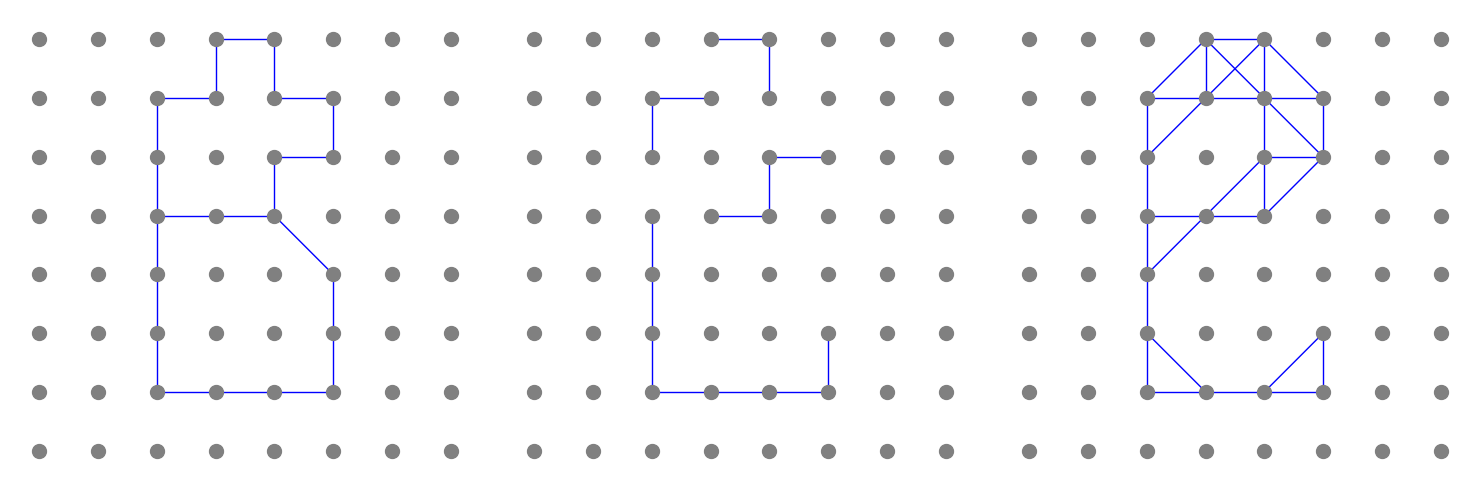

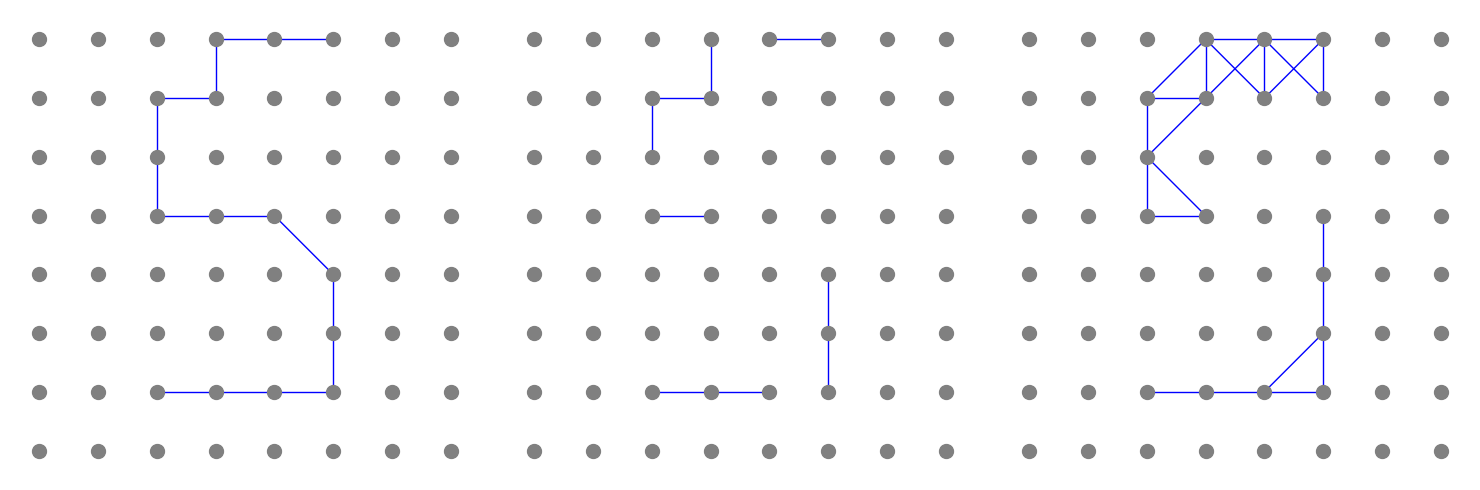

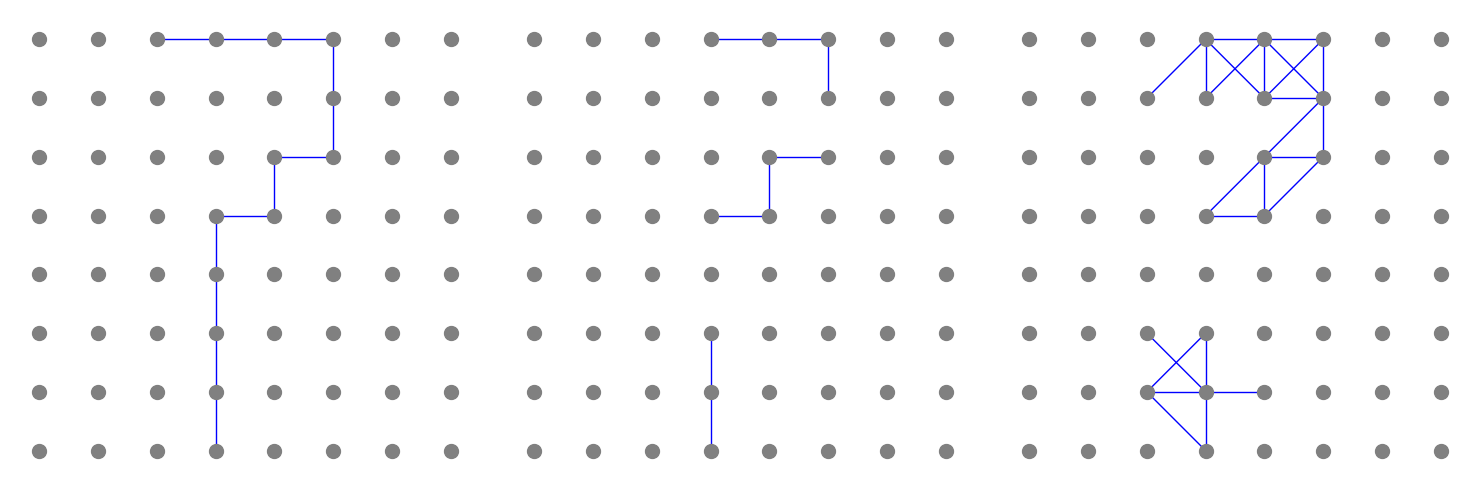

In [ ]:
from copy import deepcopy


batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[0])  

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

drop_rate = 0.3
threshold = 0.7
corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)

reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate  
)

batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[1]) 

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)

reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate 
)



batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[10])  

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)

reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate 

# Iteratie 3: extra laag

## Modeldefinitie en trainings-/validatiefuncties 

In [ ]:
class GINEncoderTwoLayers(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        hidden_dim = 2 * out_channels

        # Eerste GIN-laag
        nn1 = torch.nn.Sequential(
            torch.nn.Linear(in_channels, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim)
        )
        self.conv1 = GINConv(nn1)

        # Tweede GIN-laag
        nn2 = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim)
        )
        self.conv2 = GINConv(nn2)

        self.conv_mu = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))
        self.conv_logstd = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

model = VGAE(GINEncoderTwoLayers(in_channels=64, out_channels=32)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_step(data):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()

    z = model.encode(data.x, data.edge_index)
    pos_edge = data.pos_edge_label_index.to(device)
    neg_edge = data.neg_edge_label_index.to(device)

    loss = model.recon_loss(z, pos_edge, neg_edge)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return loss.item()

def validate_step(data):
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        pos_edge = data.pos_edge_label_index.to(device)
        neg_edge = data.neg_edge_label_index.to(device)
        loss = model.recon_loss(z, pos_edge, neg_edge)
        loss = loss + (1 / data.num_nodes) * model.kl_loss()
    return loss.item()



## Trainloop 


In [ ]:
num_epochs = 500
best_val_loss = float('inf')
patience = 20
epochs_no_improve = 0
early_stop = True

train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    num_train_batches = 0
    for data in train_loader:
        data = corrupt_graph(data)
        loss = train_step(data)
        total_loss += loss
        num_train_batches += 1

    total_loss_val = 0
    num_val_batches = 0
    for val_data in val_loader:
        val_data = corrupt_graph(val_data)
        val_loss = validate_step(val_data)
        total_loss_val += val_loss
        num_val_batches += 1

    avg_train_loss = total_loss / num_train_batches
    avg_val_loss = total_loss_val / num_val_batches

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch:03d} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "VGAE3.pt")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch:03d}")
        break

Epoch 001 - Train Loss: 3.2347 - Val Loss: 1.0683
Epoch 002 - Train Loss: 1.2187 - Val Loss: 1.1163
Epoch 003 - Train Loss: 1.0973 - Val Loss: 1.1092
Epoch 004 - Train Loss: 1.0786 - Val Loss: 1.0858
Epoch 005 - Train Loss: 1.0678 - Val Loss: 1.0841
Epoch 006 - Train Loss: 1.0648 - Val Loss: 1.0673
Epoch 007 - Train Loss: 1.0546 - Val Loss: 1.0433
Epoch 008 - Train Loss: 1.0470 - Val Loss: 1.0553
Epoch 009 - Train Loss: 1.0305 - Val Loss: 1.0025
Epoch 010 - Train Loss: 1.0141 - Val Loss: 1.0019
Epoch 011 - Train Loss: 0.9912 - Val Loss: 0.9824
Epoch 012 - Train Loss: 0.9725 - Val Loss: 0.9869
Epoch 013 - Train Loss: 0.9516 - Val Loss: 0.9536
Epoch 014 - Train Loss: 0.9481 - Val Loss: 0.9750
Epoch 015 - Train Loss: 0.9588 - Val Loss: 0.9568
Epoch 016 - Train Loss: 0.9482 - Val Loss: 0.9633
Epoch 017 - Train Loss: 0.9449 - Val Loss: 0.9549
Epoch 018 - Train Loss: 0.9436 - Val Loss: 0.9434
Epoch 019 - Train Loss: 0.9444 - Val Loss: 0.9576
Epoch 020 - Train Loss: 0.9447 - Val Loss: 0.9412


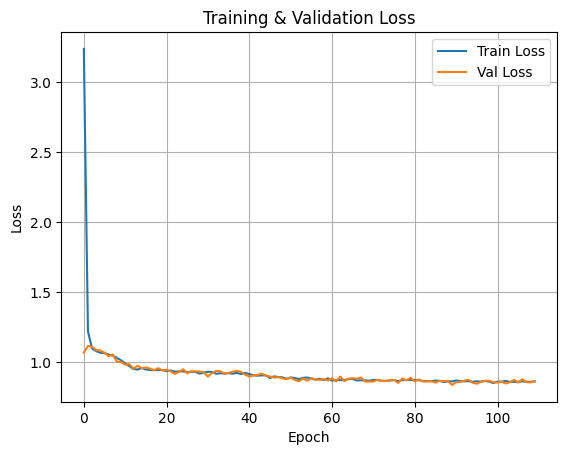

In [222]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()



## Model opslaan/inladen


In [ ]:
# torch.save(model, "VGAE3.pt")


In [177]:
model = torch.load("VGAE3.pt", map_location=device, weights_only=False)
model.eval()


VGAE(
  (encoder): GINEncoderTwoLayers(
    (conv1): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    ))
    (conv2): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    ))
    (conv_mu): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
    (conv_logstd): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
  )
  (decoder): InnerProductDecoder()
)

## Resultaten

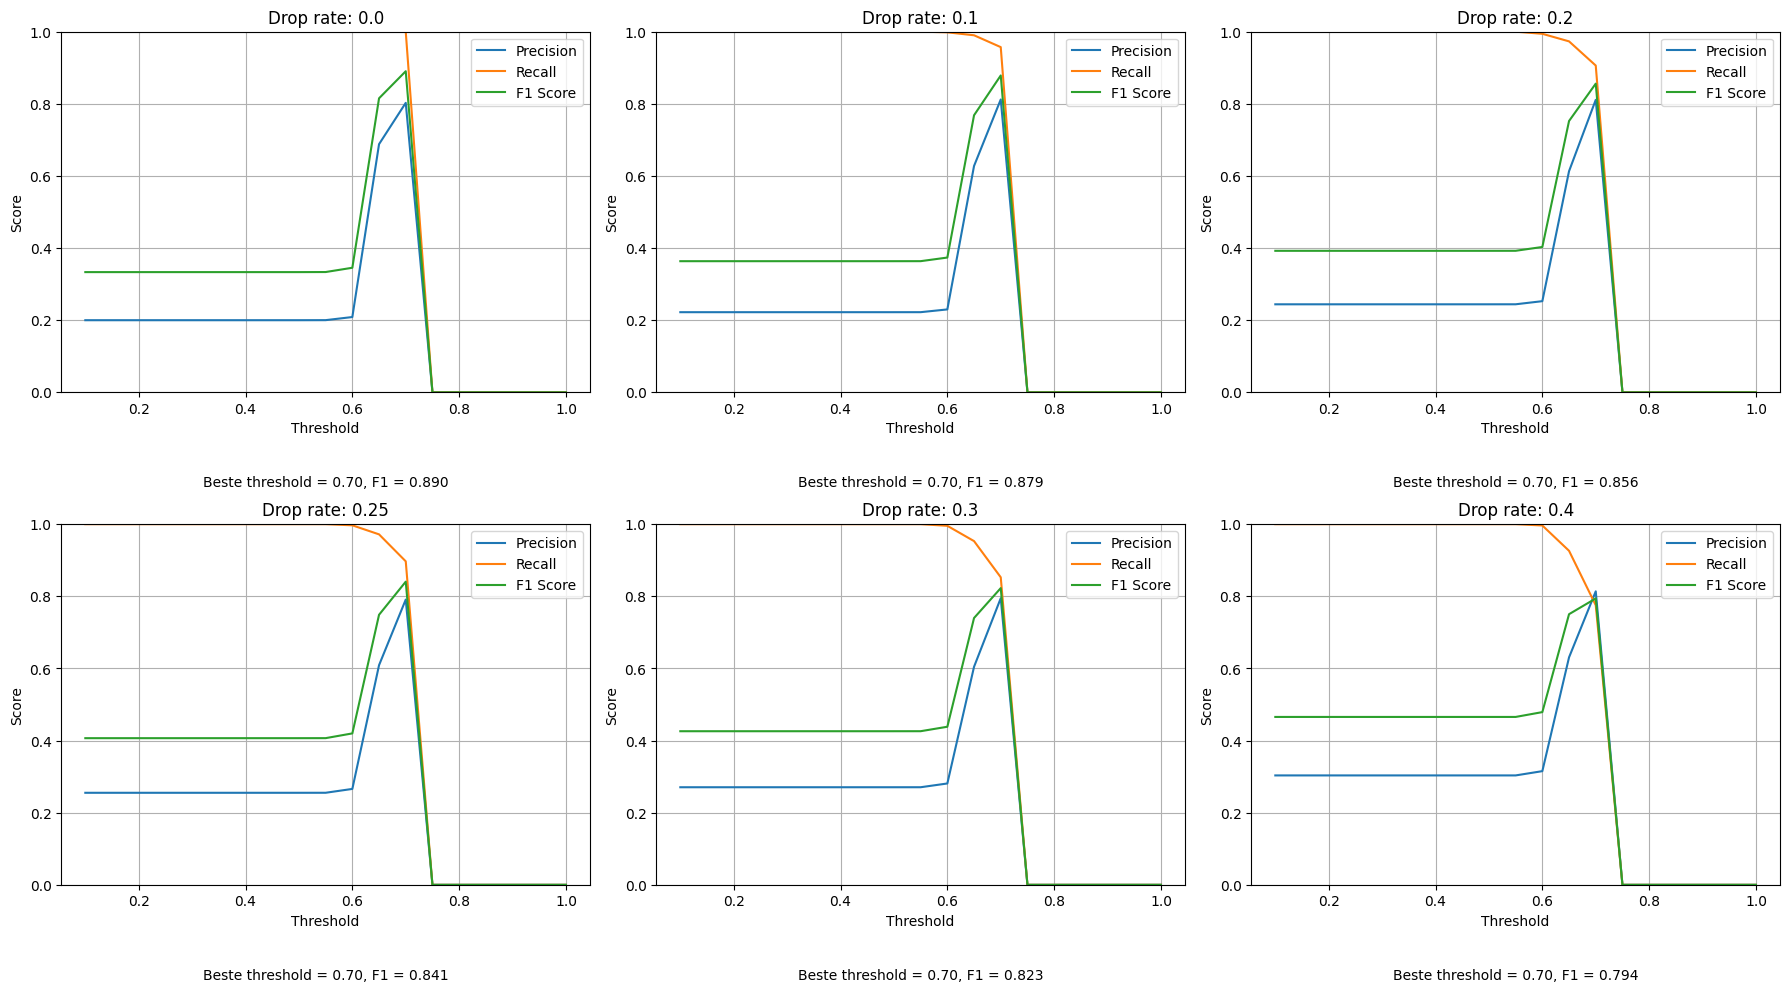

In [ ]:
thresholds = thresholds = np.linspace(0.1, 1.0, 19)  
all_results = {}

for drop_rate, loader in val_loaders.items():
    results = evaluate_link_prediction(model, loader, thresholds)
    all_results[drop_rate] = results


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axs = axs.flatten()

for i, (drop_rate, results) in enumerate(sorted(all_results.items())):
    thresholds = [r['threshold'] for r in results]
    precisions = [r['precision'] for r in results]
    recalls = [r['recall'] for r in results]
    f1_scores = [r['f1_score'] for r in results]

    best_idx = max(range(len(f1_scores)), key=lambda j: f1_scores[j])
    best_thresh = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    ax = axs[i]
    ax.plot(thresholds, precisions, label='Precision')
    ax.plot(thresholds, recalls, label='Recall')
    ax.plot(thresholds, f1_scores, label='F1 Score')

    ax.set_title(f'Drop rate: {drop_rate}')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True)

    ax.text(0.5, -0.25,
            f'Beste threshold = {best_thresh:.2f}, F1 = {best_f1:.3f}',
            ha='center', va='center',
            transform=ax.transAxes, fontsize=10)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


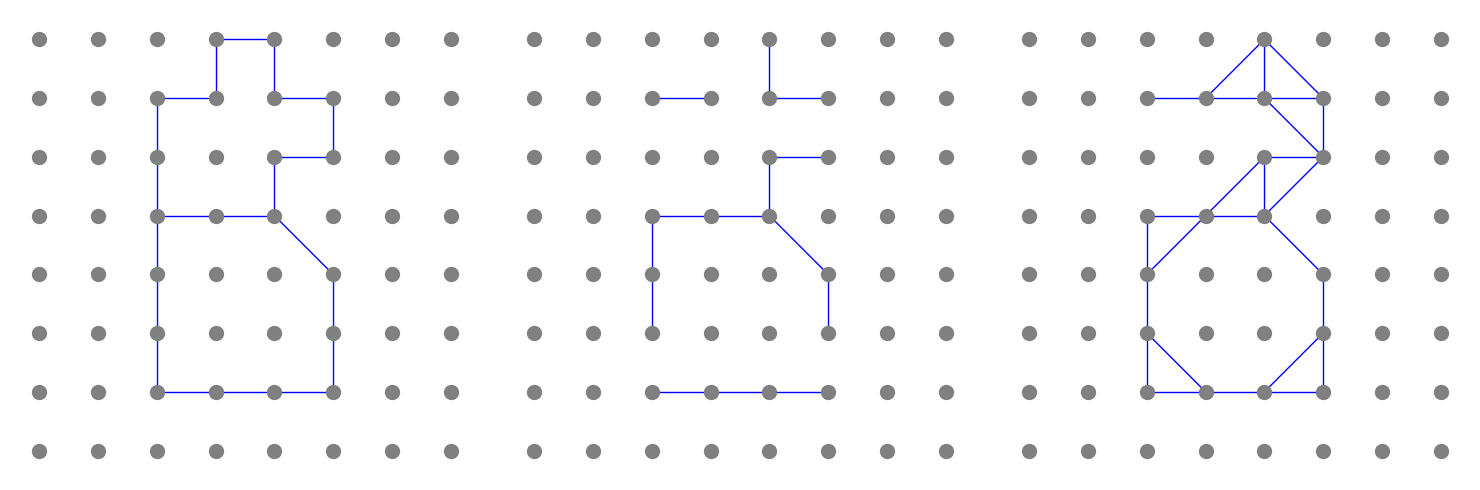

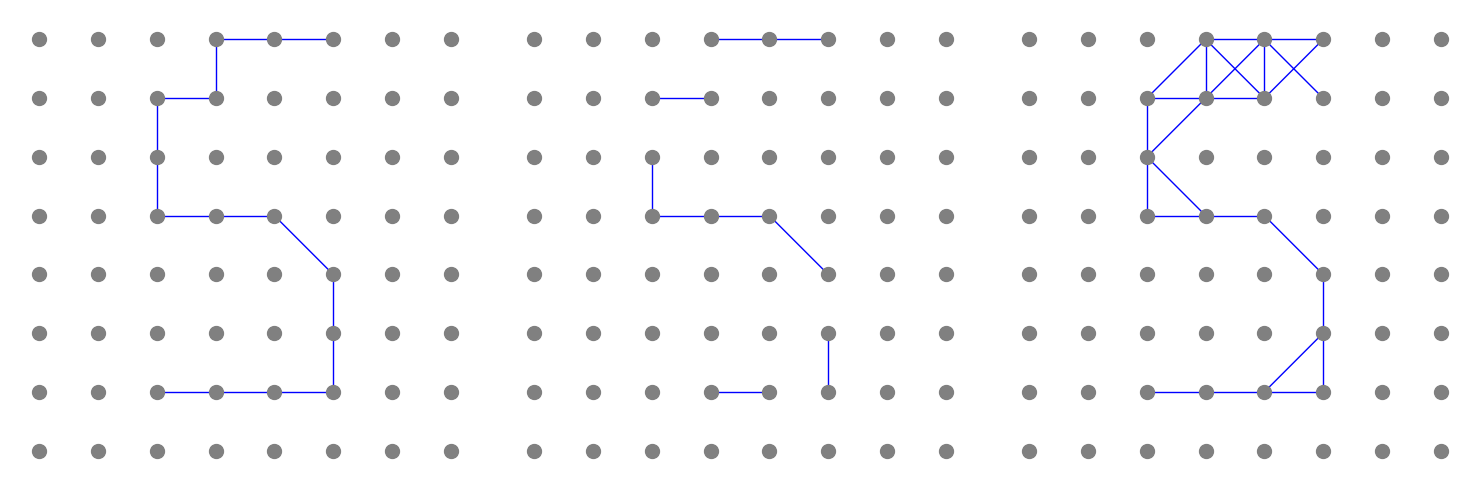

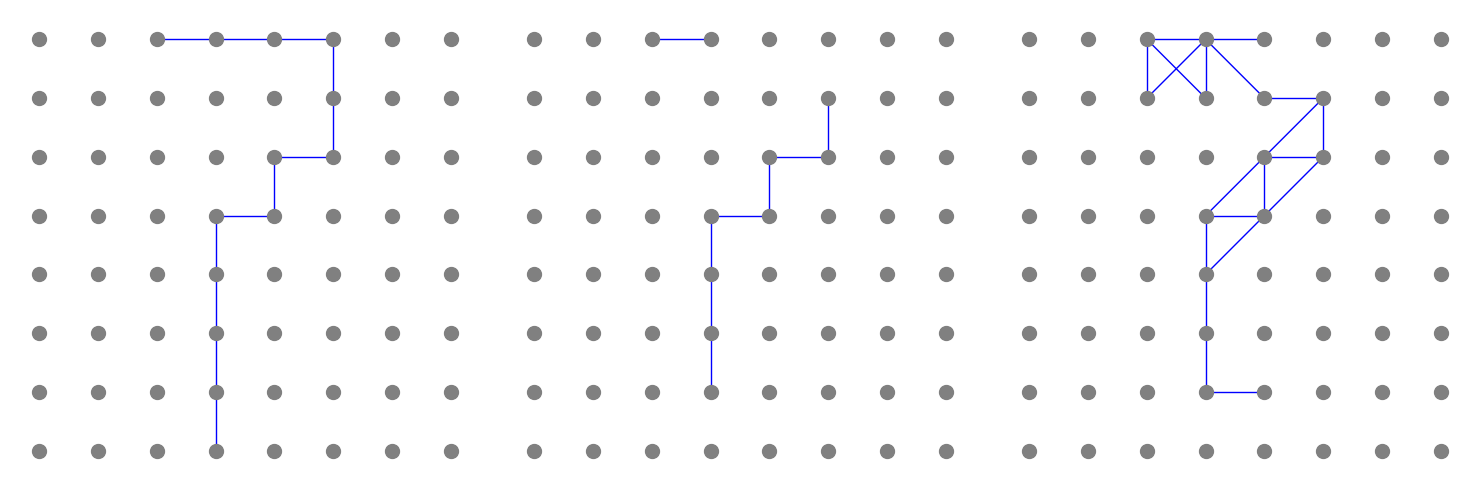

In [ ]:
from copy import deepcopy


batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[0])  

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

drop_rate = 0.3
threshold = 0.7
corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)

reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate  
)



batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[1])  

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)

reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate 
)



batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[10])  

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)

reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)

reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate 
)

# Iteratie 4: 3de laag toevoegen

## Modeldefinitie en trainings-/validatiefuncties 

In [ ]:
class GINEncoderThreeLayers(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        hidden_dim = 2 * out_channels

        # Eerste GIN-laag
        nn1 = torch.nn.Sequential(
            torch.nn.Linear(in_channels, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim)
        )
        self.conv1 = GINConv(nn1)

        # Tweede GIN-laag
        nn2 = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim)
        )
        self.conv2 = GINConv(nn2)

        # Derde GIN-laag
        nn3 = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim)
        )
        self.conv3 = GINConv(nn3)

        self.conv_mu = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))
        self.conv_logstd = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

model = VGAE(GINEncoderThreeLayers(in_channels=64, out_channels=32)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_step(data):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()

    z = model.encode(data.x, data.edge_index)
    pos_edge = data.pos_edge_label_index.to(device)
    neg_edge = data.neg_edge_label_index.to(device)

    loss = model.recon_loss(z, pos_edge, neg_edge)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return loss.item()

def validate_step(data):
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        pos_edge = data.pos_edge_label_index.to(device)
        neg_edge = data.neg_edge_label_index.to(device)
        loss = model.recon_loss(z, pos_edge, neg_edge)
        loss = loss + (1 / data.num_nodes) * model.kl_loss()
    return loss.item()


## Trainloop 

In [ ]:
num_epochs = 500
best_val_loss = float('inf')
patience = 20
epochs_no_improve = 0
early_stop = True

train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    num_train_batches = 0
    for data in train_loader:
        data = corrupt_graph(data)
        loss = train_step(data)
        total_loss += loss
        num_train_batches += 1

    total_loss_val = 0
    num_val_batches = 0
    for val_data in val_loader:
        val_data = corrupt_graph(val_data)
        val_loss = validate_step(val_data)
        total_loss_val += val_loss
        num_val_batches += 1

    avg_train_loss = total_loss / num_train_batches
    avg_val_loss = total_loss_val / num_val_batches

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch:03d} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "VGAE4.pt")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch:03d}")
        break

Epoch 001 - Train Loss: 3.6597 - Val Loss: 1.0890
Epoch 002 - Train Loss: 1.4019 - Val Loss: 1.1666
Epoch 003 - Train Loss: 1.1272 - Val Loss: 1.1022
Epoch 004 - Train Loss: 1.0859 - Val Loss: 1.0424
Epoch 005 - Train Loss: 1.0409 - Val Loss: 1.0193
Epoch 006 - Train Loss: 1.0107 - Val Loss: 0.9812
Epoch 007 - Train Loss: 0.9875 - Val Loss: 0.9692
Epoch 008 - Train Loss: 0.9824 - Val Loss: 0.9946
Epoch 009 - Train Loss: 0.9821 - Val Loss: 0.9603
Epoch 010 - Train Loss: 0.9696 - Val Loss: 0.9788
Epoch 011 - Train Loss: 0.9665 - Val Loss: 0.9571
Epoch 012 - Train Loss: 0.9611 - Val Loss: 0.9647
Epoch 013 - Train Loss: 0.9539 - Val Loss: 0.9690
Epoch 014 - Train Loss: 0.9528 - Val Loss: 0.9576
Epoch 015 - Train Loss: 0.9535 - Val Loss: 0.9516
Epoch 016 - Train Loss: 0.9408 - Val Loss: 0.9335
Epoch 017 - Train Loss: 0.9418 - Val Loss: 0.9240
Epoch 018 - Train Loss: 0.9275 - Val Loss: 0.9286
Epoch 019 - Train Loss: 0.9312 - Val Loss: 0.9181
Epoch 020 - Train Loss: 0.9211 - Val Loss: 0.9212


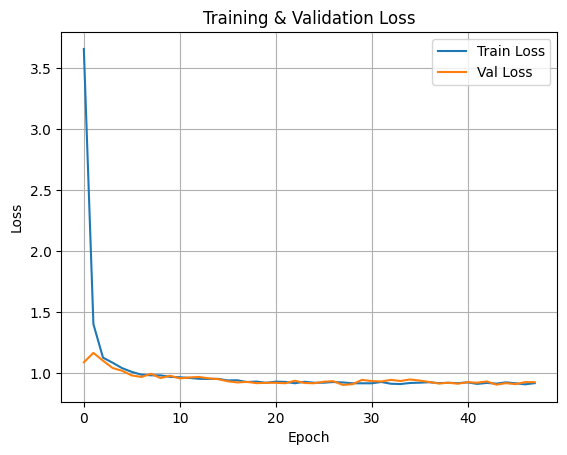

In [231]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


## Model opslaan/inladen

In [ ]:
# torch.save(model, "VGAE4.pt")


In [180]:
model = torch.load("VGAE4.pt", map_location=device, weights_only=False)
model.eval()


VGAE(
  (encoder): GINEncoderThreeLayers(
    (conv1): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    ))
    (conv2): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    ))
    (conv3): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    ))
    (conv_mu): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
    (conv_logstd): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
  )
  (decoder): InnerPro

## Resultaten

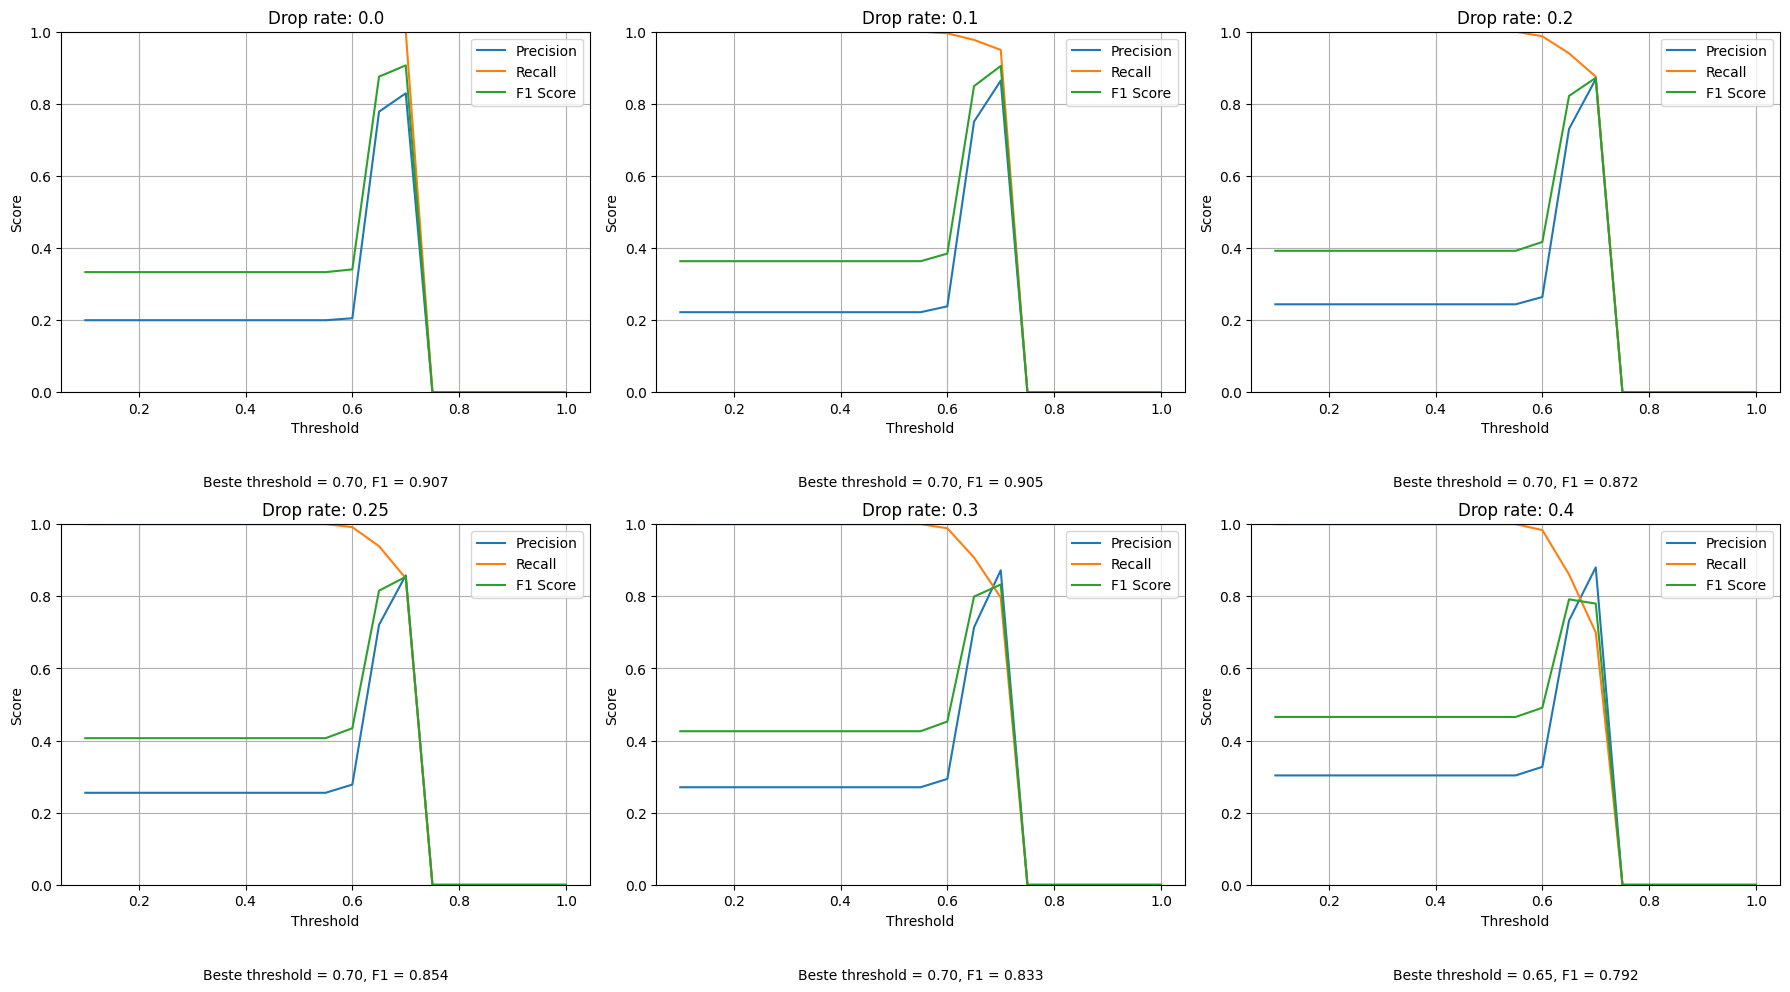

In [ ]:
thresholds = thresholds = np.linspace(0.1, 1.0, 19) 

all_results = {}

for drop_rate, loader in val_loaders.items():
    results = evaluate_link_prediction(model, loader, thresholds)
    all_results[drop_rate] = results

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axs = axs.flatten()

for i, (drop_rate, results) in enumerate(sorted(all_results.items())):
    thresholds = [r['threshold'] for r in results]
    precisions = [r['precision'] for r in results]
    recalls = [r['recall'] for r in results]
    f1_scores = [r['f1_score'] for r in results]

    best_idx = max(range(len(f1_scores)), key=lambda j: f1_scores[j])
    best_thresh = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    ax = axs[i]
    ax.plot(thresholds, precisions, label='Precision')
    ax.plot(thresholds, recalls, label='Recall')
    ax.plot(thresholds, f1_scores, label='F1 Score')

    ax.set_title(f'Drop rate: {drop_rate}')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True)

    ax.text(0.5, -0.25,
            f'Beste threshold = {best_thresh:.2f}, F1 = {best_f1:.3f}',
            ha='center', va='center',
            transform=ax.transAxes, fontsize=10)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


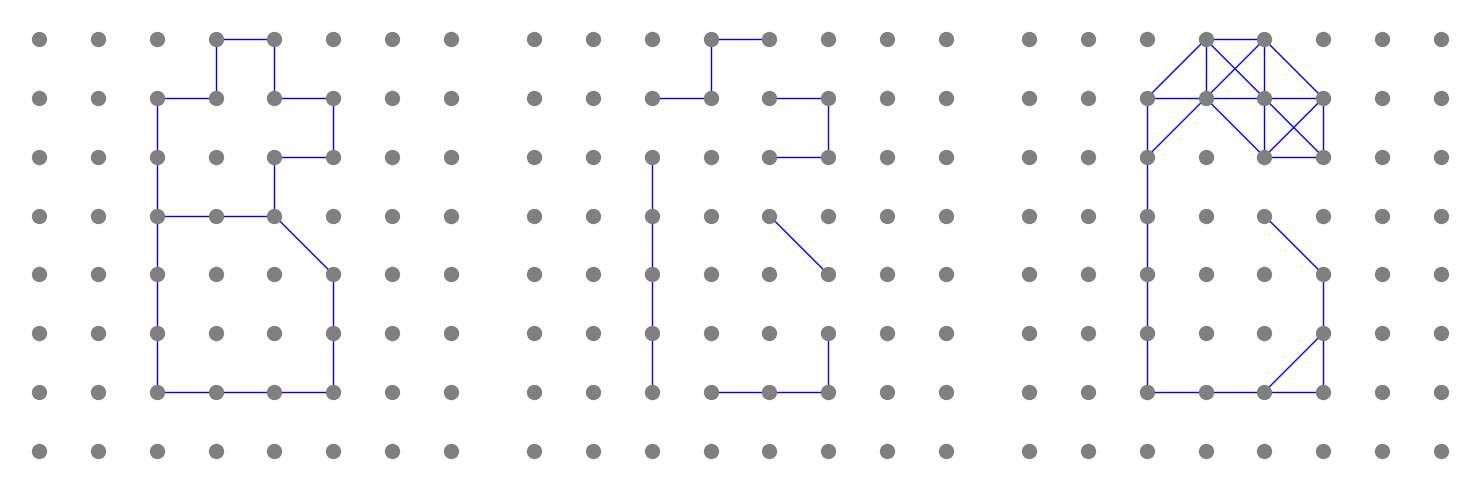

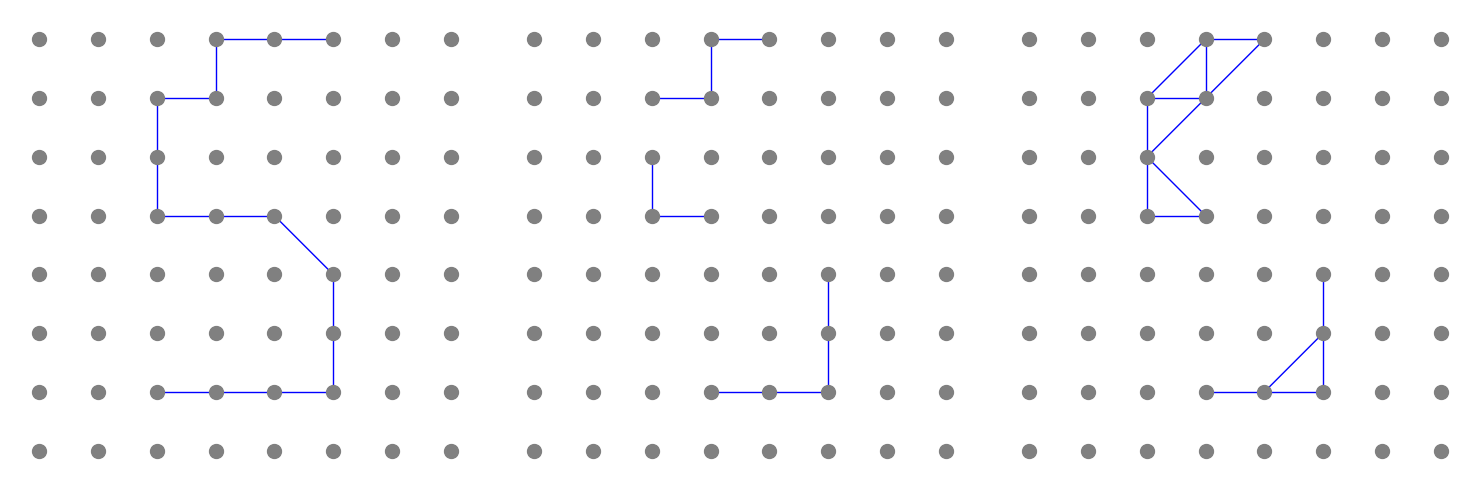

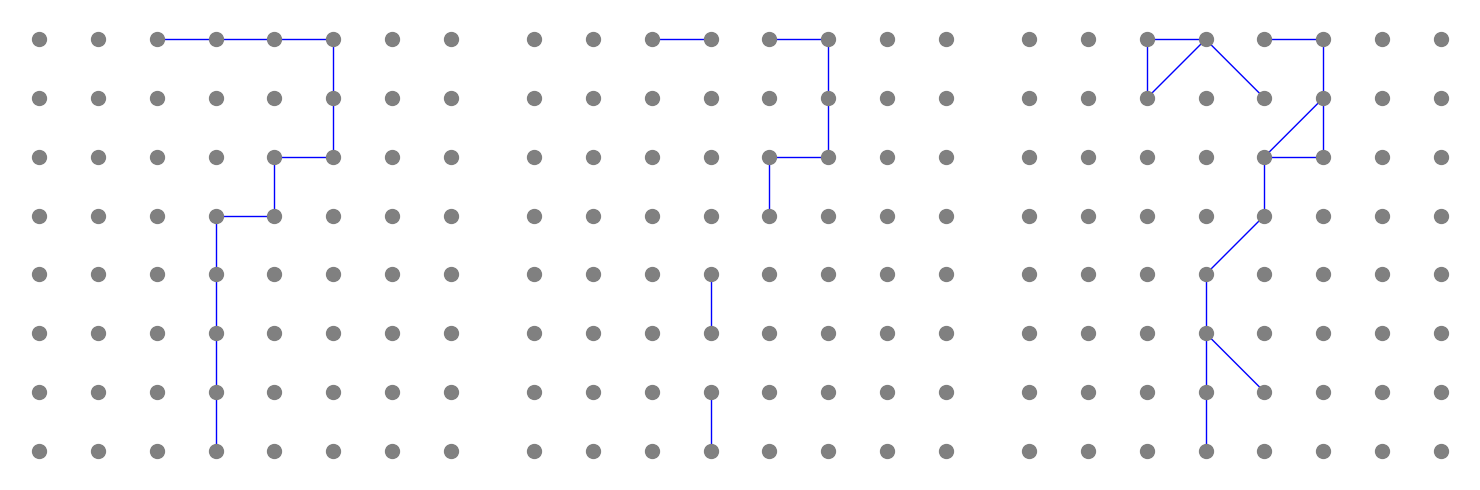

In [ ]:
from copy import deepcopy


batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[0]) 

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

drop_rate = 0.3
threshold = 0.7
corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)


reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate  
)



batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[1]) 

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)

reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate  
)



batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[10])  

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)

reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate 
)

# Iteratie 5: bilinaire decoder

## Modeldefinitie en trainings-/validatiefuncties 

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv

# --- GIN Encoder met 3 lagen ---
class GINEncoderThreeLayers(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        hidden_dim = 2 * out_channels

        self.conv1 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(in_channels, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim)
        ))
        self.conv2 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim)
        ))
        self.conv3 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim)
        ))

        self.conv_mu = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))
        self.conv_logstd = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        mu = self.conv_mu(x, edge_index)
        logstd = self.conv_logstd(x, edge_index)
        self.mu = mu
        self.logstd = logstd
        return mu, logstd

# --- Bilinear Decoder ---
class BilinearDecoder(torch.nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.weight = torch.nn.Parameter(torch.randn(latent_dim, latent_dim))

    def forward(self, z, edge_index):
        z_src = z[edge_index[0]]
        z_dst = z[edge_index[1]]
        return torch.einsum('bi,ij,bj->b', z_src, self.weight, z_dst)

# --- VGAE met bilinear decoder ---
class VGAE_Bilinear(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def encode(self, x, edge_index):
        mu, logstd = self.encoder(x, edge_index)
        std = torch.exp(logstd)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, edge_index):
        return self.encode(x, edge_index)

    def decode(self, z, edge_index):
        return self.decoder(z, edge_index)

    def recon_loss(self, z, pos_edge_index, neg_edge_index):
        pos_out = self.decoder(z, pos_edge_index)
        neg_out = self.decoder(z, neg_edge_index)

        pos_label = torch.ones_like(pos_out)
        neg_label = torch.zeros_like(neg_out)

        preds = torch.cat([pos_out, neg_out])
        labels = torch.cat([pos_label, neg_label])
        return F.binary_cross_entropy_with_logits(preds, labels)

    def kl_loss(self):
        mu, logstd = self.encoder.mu, self.encoder.logstd
        return -0.5 * torch.mean(1 + 2 * logstd - mu**2 - (2 * logstd).exp())

encoder = GINEncoderThreeLayers(in_channels=64, out_channels=32)
decoder = BilinearDecoder(latent_dim=32)
model = VGAE_Bilinear(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_step(data):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)
    pos_edge = data.pos_edge_label_index.to(device)
    neg_edge = data.neg_edge_label_index.to(device)
    loss = model.recon_loss(z, pos_edge, neg_edge)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return loss.item()

def validate_step(data):
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        pos_edge = data.pos_edge_label_index.to(device)
        neg_edge = data.neg_edge_label_index.to(device)
        loss = model.recon_loss(z, pos_edge, neg_edge)
        loss = loss + (1 / data.num_nodes) * model.kl_loss()
    return loss.item()


## Trainloop 

In [ ]:
num_epochs = 500
drop_rate = 0.25  # vaste waarde
best_val_loss = float('inf')
patience = 20
epochs_no_improve = 0
train_losses = []
val_losses = []

# Vaste gecorrumpeerde validatieset
fixed_val_data = [corrupt_graph(data, drop_rate=drop_rate) for data in val_loader]

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    num_train_batches = 0
    for data in train_loader:
        data = corrupt_graph(data, drop_rate=drop_rate)
        loss = train_step(data)
        total_loss += loss
        num_train_batches += 1

    total_loss_val = 0
    num_val_batches = 0
    for val_data in fixed_val_data:
        val_loss = validate_step(val_data)
        total_loss_val += val_loss
        num_val_batches += 1

    avg_train_loss = total_loss / num_train_batches
    avg_val_loss = total_loss_val / num_val_batches

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch:03d} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "VGAE5.pt")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch:03d}")
        break

Epoch 001 - Train Loss: 7.1006 - Val Loss: 1.5682
Epoch 002 - Train Loss: 0.5616 - Val Loss: 0.4331
Epoch 003 - Train Loss: 0.3913 - Val Loss: 0.3806
Epoch 004 - Train Loss: 0.3759 - Val Loss: 0.3660
Epoch 005 - Train Loss: 0.3511 - Val Loss: 0.3482
Epoch 006 - Train Loss: 0.3406 - Val Loss: 0.3371
Epoch 007 - Train Loss: 0.3179 - Val Loss: 0.3083
Epoch 008 - Train Loss: 0.3049 - Val Loss: 0.2915
Epoch 009 - Train Loss: 0.2919 - Val Loss: 0.2884
Epoch 010 - Train Loss: 0.2783 - Val Loss: 0.2832
Epoch 011 - Train Loss: 0.2685 - Val Loss: 0.2783
Epoch 012 - Train Loss: 0.2704 - Val Loss: 0.2680
Epoch 013 - Train Loss: 0.2567 - Val Loss: 0.2663
Epoch 014 - Train Loss: 0.2500 - Val Loss: 0.2562
Epoch 015 - Train Loss: 0.2344 - Val Loss: 0.2414
Epoch 016 - Train Loss: 0.2199 - Val Loss: 0.2354
Epoch 017 - Train Loss: 0.2140 - Val Loss: 0.2172
Epoch 018 - Train Loss: 0.2055 - Val Loss: 0.2160
Epoch 019 - Train Loss: 0.2070 - Val Loss: 0.2123
Epoch 020 - Train Loss: 0.2000 - Val Loss: 0.2152


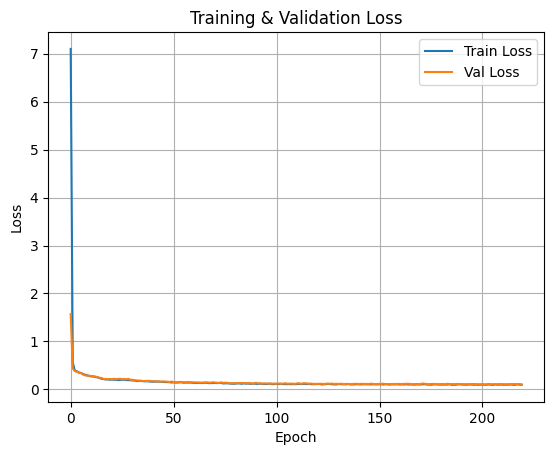

In [391]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


## Model opslaan/inladen

In [ ]:
# torch.save(model, "VGAE5.pt")


In [191]:
model = torch.load("VGAE5.pt", map_location=device, weights_only=False)
model.eval()


VGAE_Bilinear(
  (encoder): GINEncoderThreeLayers(
    (conv1): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    ))
    (conv2): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    ))
    (conv3): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    ))
    (conv_mu): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
    (conv_logstd): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
  )
  (decoder):

## Resultaten

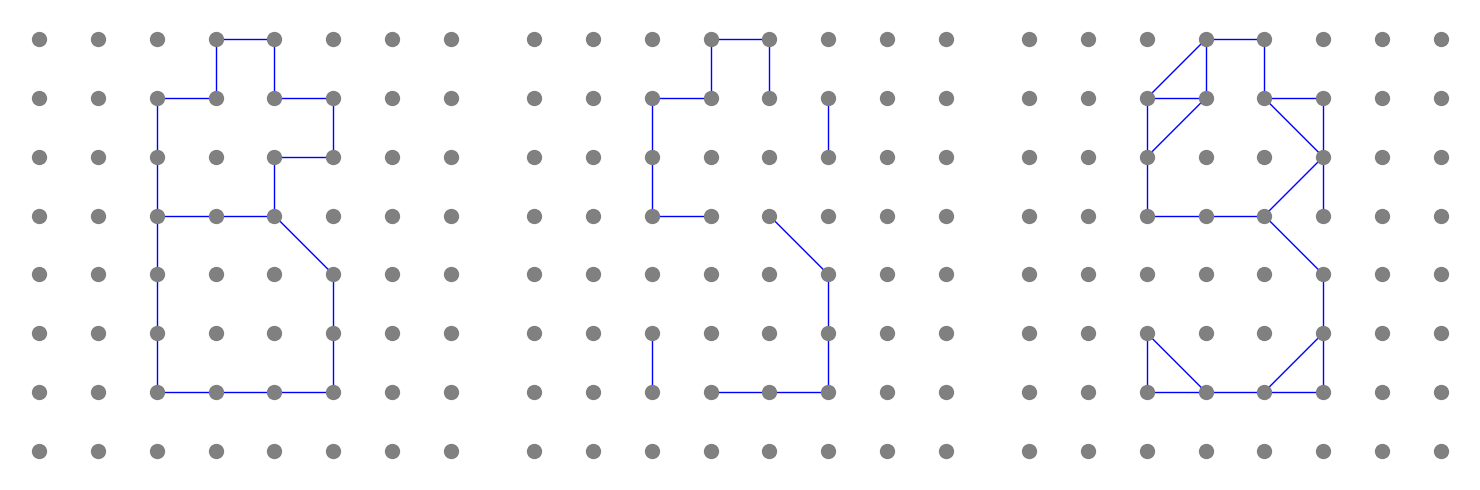

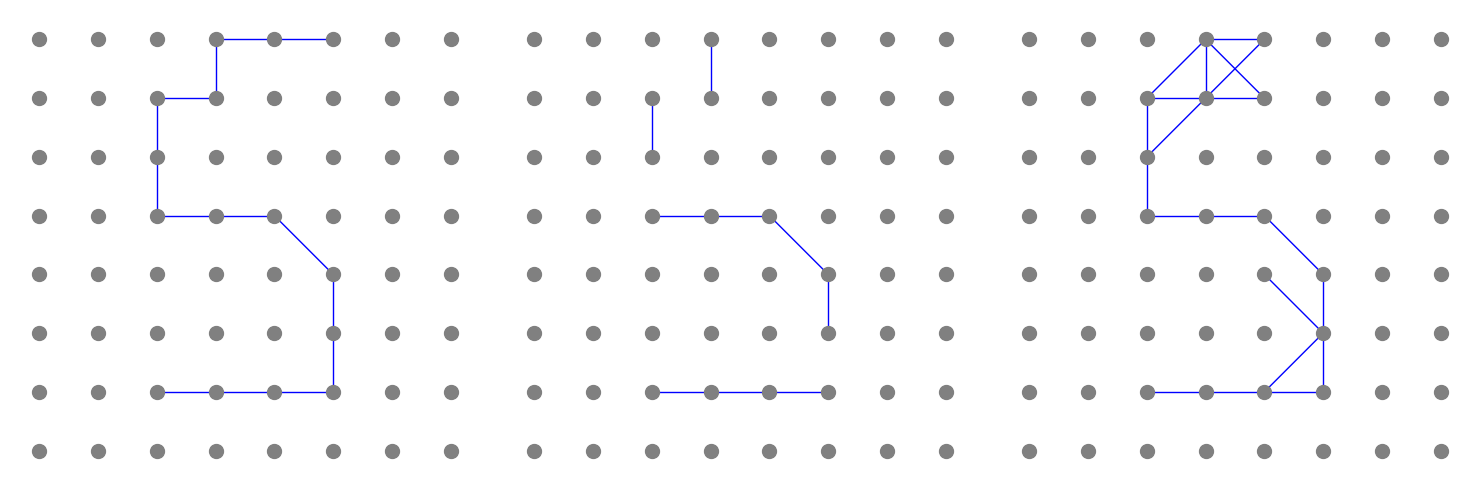

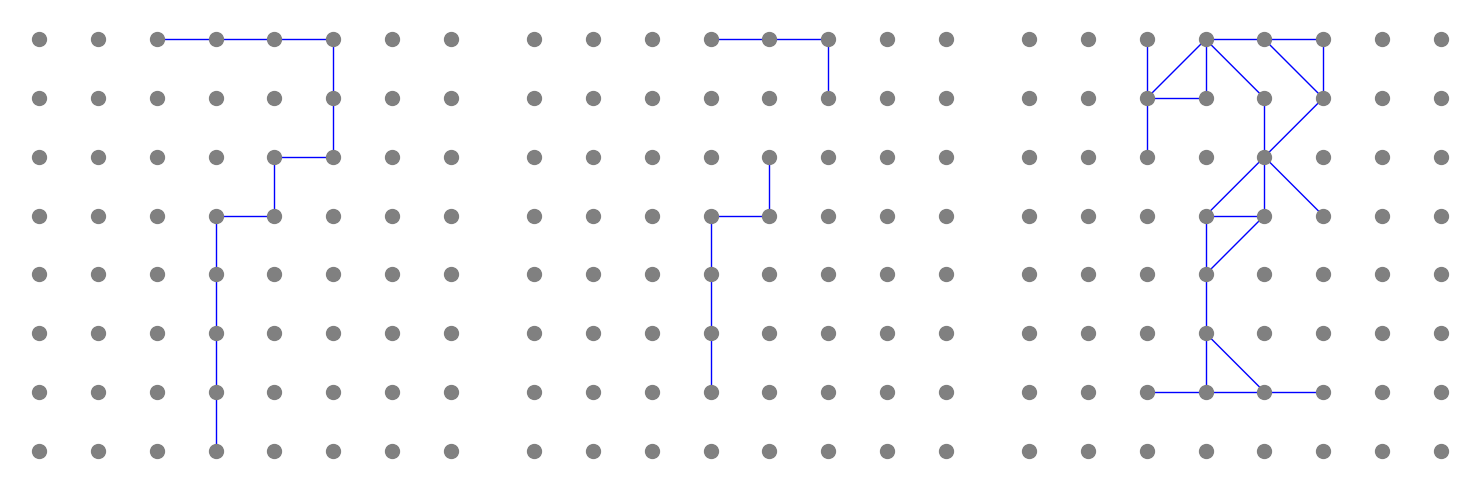

In [ ]:
from copy import deepcopy


batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[0])  

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

drop_rate = 0.3
threshold = 0.9
corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)


reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate 
)



batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[1]) 

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)

reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate  
)



batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[10])  

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)

reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate  
)

# Iteratie 6: Dropout

## Modeldefinitie en trainings-/validatiefuncties 

In [ ]:
class GINEncoderThreeLayers(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        hidden_dim = 2 * out_channels
        dropout_p = 0.3

        self.conv1 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(in_channels, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout_p),
            torch.nn.Linear(hidden_dim, hidden_dim)
        ))
        self.conv2 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout_p),
            torch.nn.Linear(hidden_dim, hidden_dim)
        ))
        self.conv3 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout_p),
            torch.nn.Linear(hidden_dim, hidden_dim)
        ))

        self.conv_mu = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))
        self.conv_logstd = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        mu = self.conv_mu(x, edge_index)
        logstd = self.conv_logstd(x, edge_index)
        self.mu = mu
        self.logstd = logstd
        return mu, logstd

class BilinearDecoder(torch.nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.weight = torch.nn.Parameter(torch.randn(latent_dim, latent_dim))

    def forward(self, z, edge_index):
        z_src = z[edge_index[0]]
        z_dst = z[edge_index[1]]
        return torch.einsum('bi,ij,bj->b', z_src, self.weight, z_dst)

class VGAE_Bilinear(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def encode(self, x, edge_index):
        mu, logstd = self.encoder(x, edge_index)
        std = torch.exp(logstd)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, edge_index):
        return self.encode(x, edge_index)

    def decode(self, z, edge_index):
        return self.decoder(z, edge_index)

    def recon_loss(self, z, pos_edge_index, neg_edge_index):
        pos_out = self.decoder(z, pos_edge_index)
        neg_out = self.decoder(z, neg_edge_index)

        pos_label = torch.ones_like(pos_out)
        neg_label = torch.zeros_like(neg_out)

        preds = torch.cat([pos_out, neg_out])
        labels = torch.cat([pos_label, neg_label])
        return F.binary_cross_entropy_with_logits(preds, labels)

    def kl_loss(self):
        mu, logstd = self.encoder.mu, self.encoder.logstd
        return -0.5 * torch.mean(1 + 2 * logstd - mu**2 - (2 * logstd).exp())

encoder = GINEncoderThreeLayers(in_channels=64, out_channels=32)
decoder = BilinearDecoder(latent_dim=32)
model = VGAE_Bilinear(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_step(data):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)
    pos_edge = data.pos_edge_label_index.to(device)
    neg_edge = data.neg_edge_label_index.to(device)
    loss = model.recon_loss(z, pos_edge, neg_edge)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return loss.item()

def validate_step(data):
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        pos_edge = data.pos_edge_label_index.to(device)
        neg_edge = data.neg_edge_label_index.to(device)
        loss = model.recon_loss(z, pos_edge, neg_edge)
        loss = loss + (1 / data.num_nodes) * model.kl_loss()
    return loss.item()


## Trainloop 

In [ ]:
num_epochs = 500
drop_rate = 0.25 
best_val_loss = float('inf')
patience = 20
epochs_no_improve = 0
train_losses = []
val_losses = []

# Vaste gecorrumpeerde validatieset
fixed_val_data = [corrupt_graph(data, drop_rate=drop_rate) for data in val_loader]

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    num_train_batches = 0
    for data in train_loader:
        data = corrupt_graph(data, drop_rate=drop_rate)
        loss = train_step(data)
        total_loss += loss
        num_train_batches += 1

    total_loss_val = 0
    num_val_batches = 0
    for val_data in fixed_val_data:
        val_loss = validate_step(val_data)
        total_loss_val += val_loss
        num_val_batches += 1

    avg_train_loss = total_loss / num_train_batches
    avg_val_loss = total_loss_val / num_val_batches

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch:03d} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "VGAE6.pt")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch:03d}")
        break

Epoch 001 - Train Loss: 10.1236 - Val Loss: 4.2504
Epoch 002 - Train Loss: 1.3201 - Val Loss: 0.4581
Epoch 003 - Train Loss: 0.4577 - Val Loss: 0.4311
Epoch 004 - Train Loss: 0.4127 - Val Loss: 0.4092
Epoch 005 - Train Loss: 0.4006 - Val Loss: 0.4229
Epoch 006 - Train Loss: 0.3685 - Val Loss: 0.3741
Epoch 007 - Train Loss: 0.3442 - Val Loss: 0.3350
Epoch 008 - Train Loss: 0.3112 - Val Loss: 0.3354
Epoch 009 - Train Loss: 0.2932 - Val Loss: 0.2938
Epoch 010 - Train Loss: 0.2827 - Val Loss: 0.2863
Epoch 011 - Train Loss: 0.2741 - Val Loss: 0.2792
Epoch 012 - Train Loss: 0.2676 - Val Loss: 0.2726
Epoch 013 - Train Loss: 0.2538 - Val Loss: 0.2584
Epoch 014 - Train Loss: 0.2437 - Val Loss: 0.2589
Epoch 015 - Train Loss: 0.2375 - Val Loss: 0.2331
Epoch 016 - Train Loss: 0.2299 - Val Loss: 0.2285
Epoch 017 - Train Loss: 0.2266 - Val Loss: 0.2448
Epoch 018 - Train Loss: 0.2244 - Val Loss: 0.2338
Epoch 019 - Train Loss: 0.2226 - Val Loss: 0.2276
Epoch 020 - Train Loss: 0.2196 - Val Loss: 0.2172

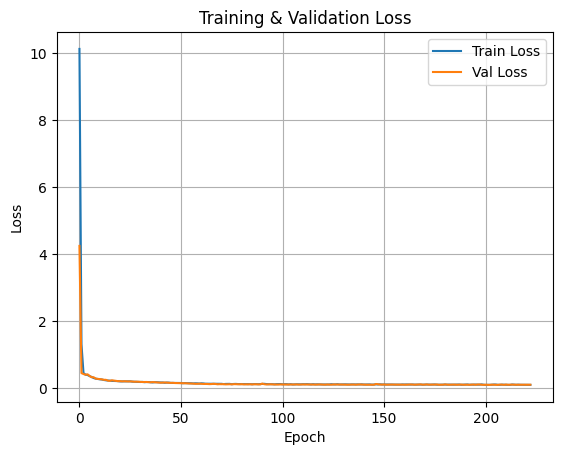

In [431]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


## Model opslaan/inladen

In [ ]:
# torch.save(model, "VGAE6.pt")


In [212]:
model = torch.load("VGAE6.pt", map_location=device, weights_only=False)
model.eval()


VGAE_Bilinear(
  (encoder): GINEncoderThreeLayers(
    (conv1): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=64, out_features=64, bias=True)
    ))
    (conv2): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=64, out_features=64, bias=True)
    ))
    (conv3): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=64, out_features=64, bias=True)
    ))
    (conv_mu): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
    (conv_logstd): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_feat

## Resultaten

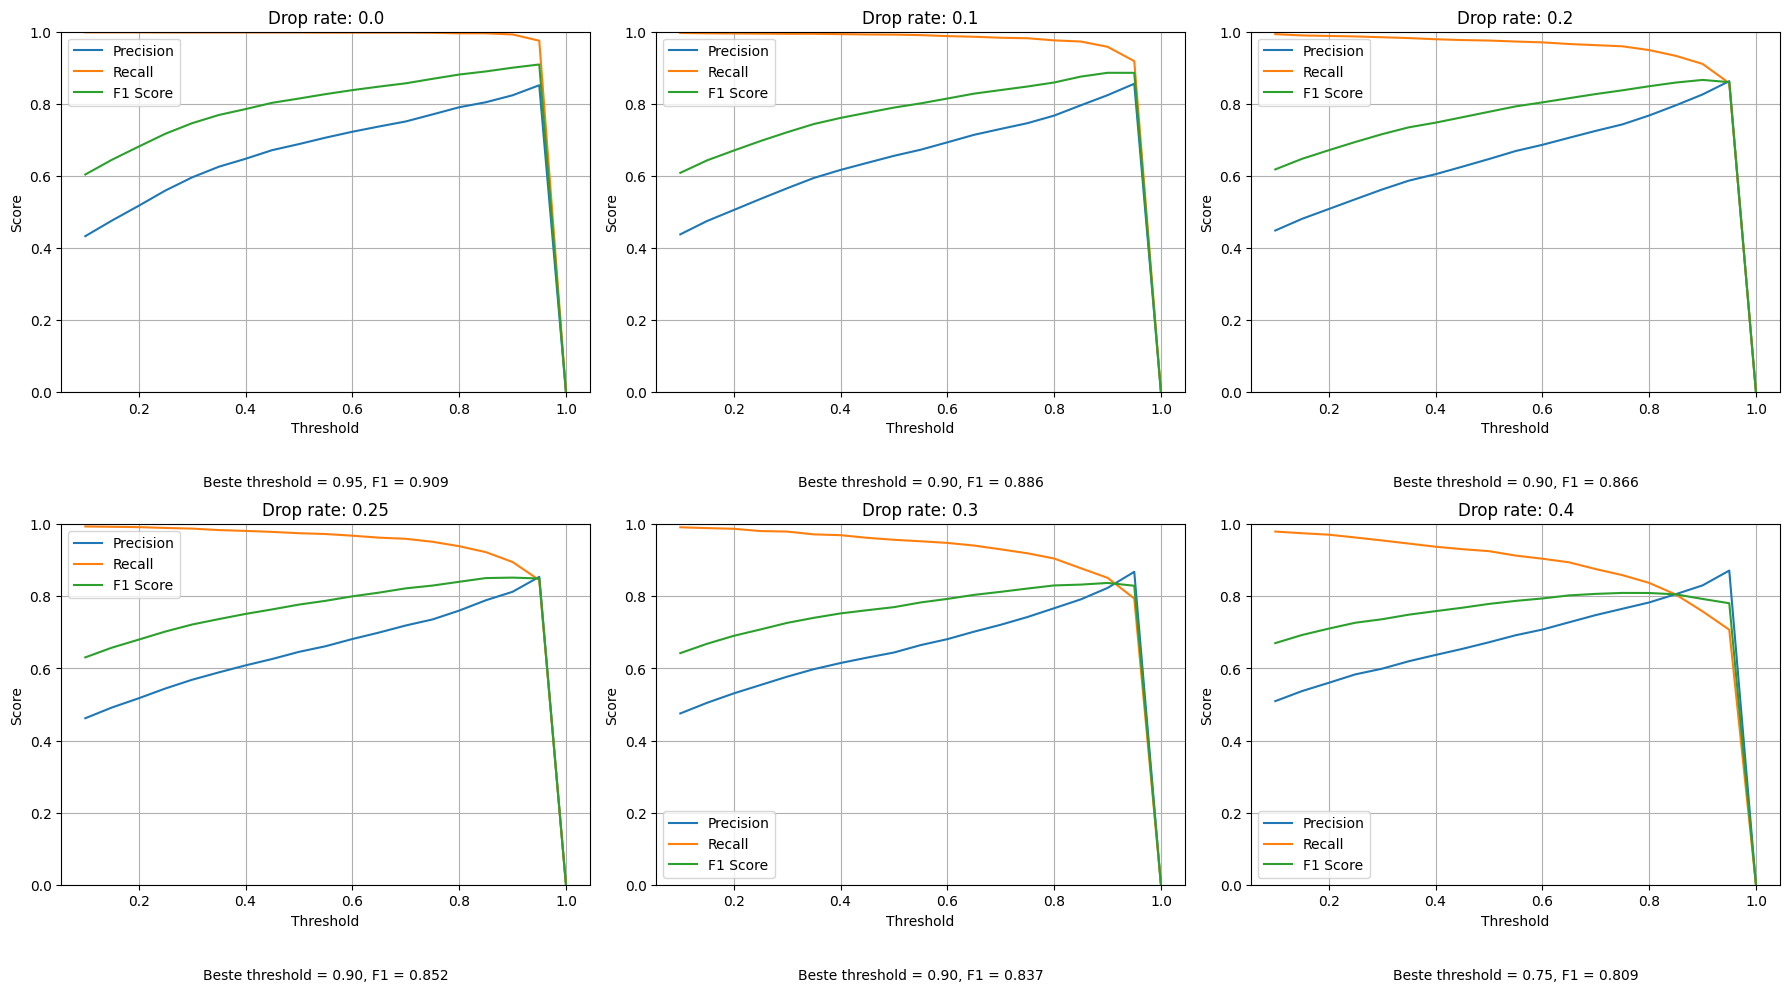

In [ ]:
thresholds = thresholds = np.linspace(0.1, 1.0, 19) 

all_results = {}

for drop_rate, loader in val_loaders.items():
    results = evaluate_link_prediction(model, loader, thresholds)
    all_results[drop_rate] = results


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axs = axs.flatten()

for i, (drop_rate, results) in enumerate(sorted(all_results.items())):
    thresholds = [r['threshold'] for r in results]
    precisions = [r['precision'] for r in results]
    recalls = [r['recall'] for r in results]
    f1_scores = [r['f1_score'] for r in results]

    best_idx = max(range(len(f1_scores)), key=lambda j: f1_scores[j])
    best_thresh = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    ax = axs[i]
    ax.plot(thresholds, precisions, label='Precision')
    ax.plot(thresholds, recalls, label='Recall')
    ax.plot(thresholds, f1_scores, label='F1 Score')

    ax.set_title(f'Drop rate: {drop_rate}')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True)

    ax.text(0.5, -0.25,
            f'Beste threshold = {best_thresh:.2f}, F1 = {best_f1:.3f}',
            ha='center', va='center',
            transform=ax.transAxes, fontsize=10)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


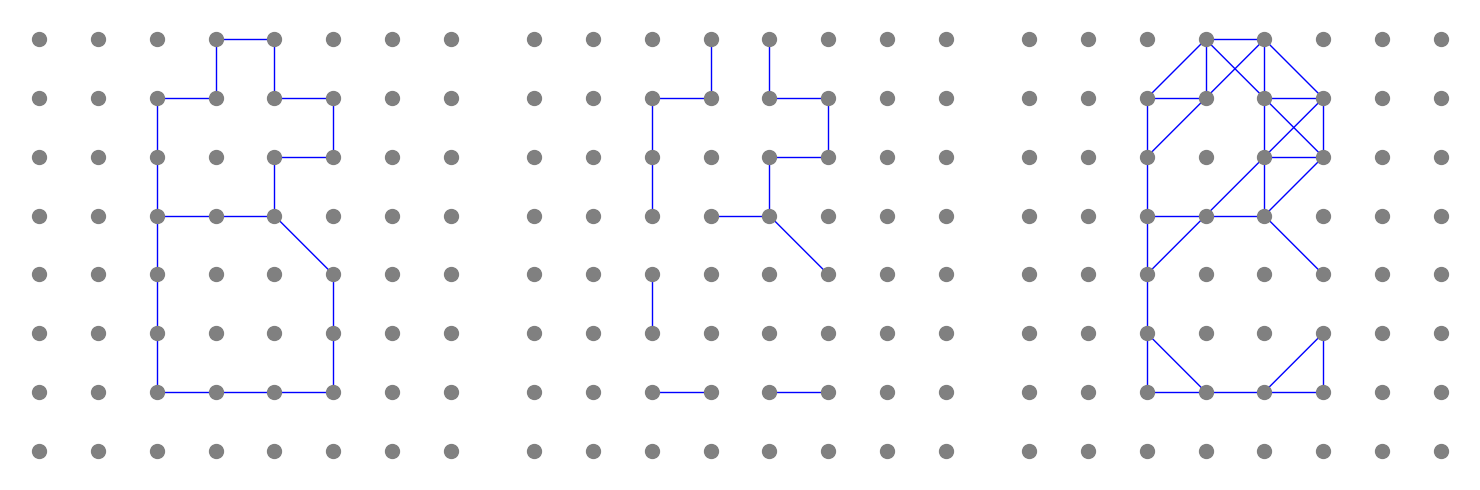

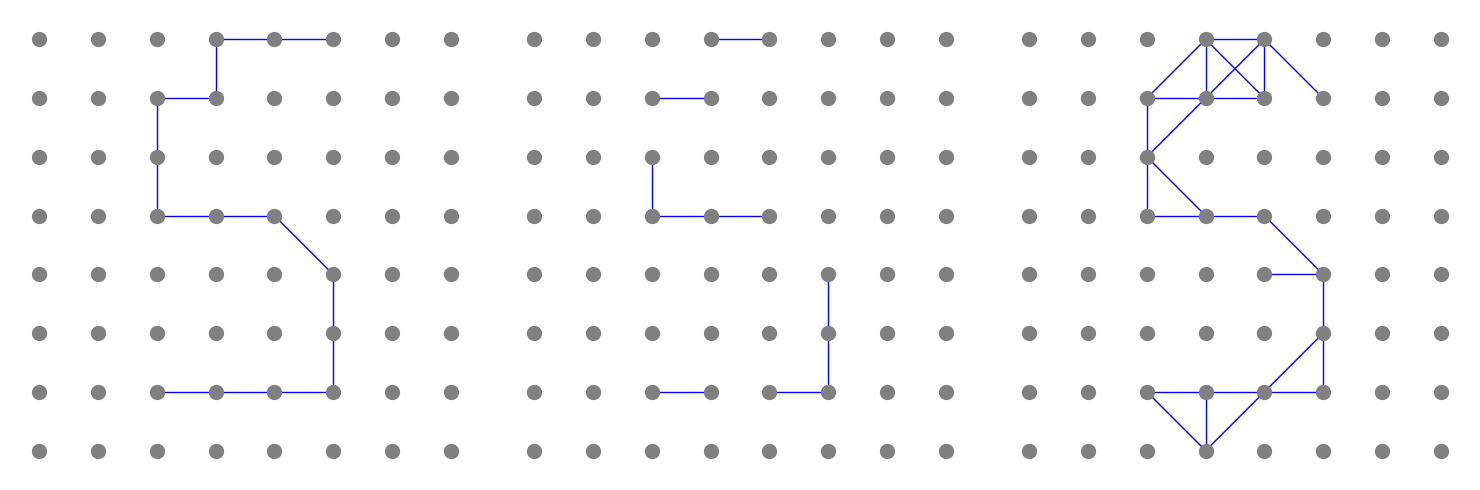

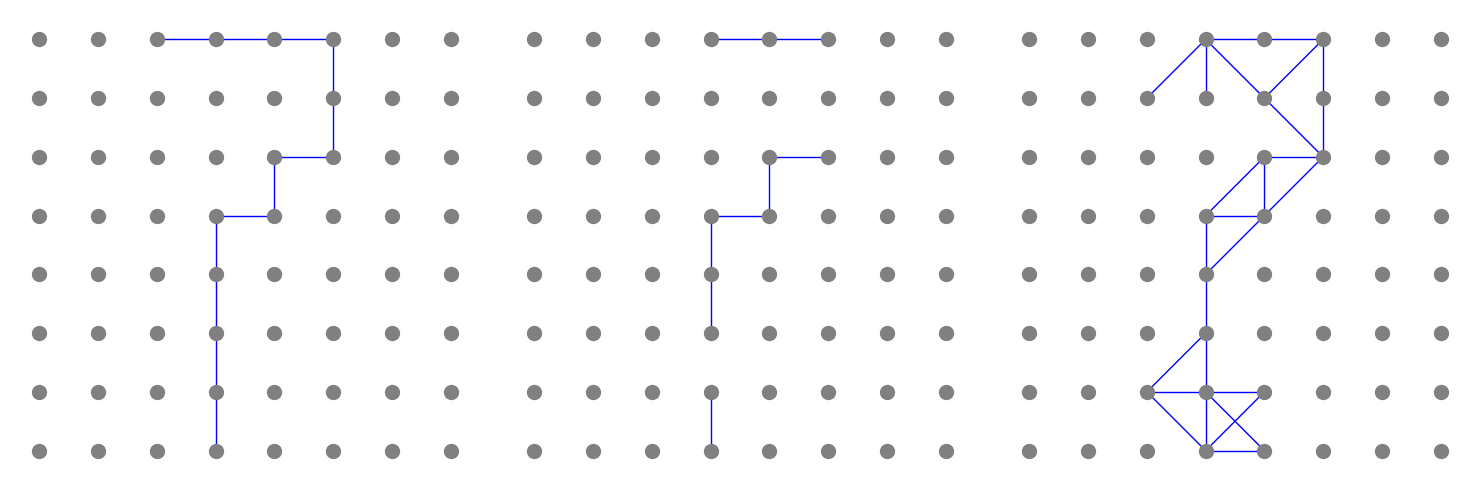

In [ ]:
batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[0]) 

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

drop_rate = 0.3
threshold = 0.85
corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)

reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate 
)



batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[1])  

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)

reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate  
)



batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[10]) 

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)


reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate 
)

# Iteratie 7: batch norm

## Modeldefinitie en trainings-/validatiefuncties 

In [ ]:
# --- GIN Encoder met 3 lagen + BatchNorm + Dropout ---
class GINEncoderThreeLayers(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        hidden_dim = 2 * out_channels
        dropout_p = 0.3

        self.conv1 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(in_channels, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.Dropout(p=dropout_p),
            torch.nn.Linear(hidden_dim, hidden_dim)
        ))

        self.conv2 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.Dropout(p=dropout_p),
            torch.nn.Linear(hidden_dim, hidden_dim)
        ))

        self.conv3 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.Dropout(p=dropout_p),
            torch.nn.Linear(hidden_dim, hidden_dim)
        ))

        self.conv_mu = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))

        self.conv_logstd = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        mu = self.conv_mu(x, edge_index)
        logstd = self.conv_logstd(x, edge_index)
        self.mu = mu
        self.logstd = logstd
        return mu, logstd


class BilinearDecoder(torch.nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.weight = torch.nn.Parameter(torch.randn(latent_dim, latent_dim))

    def forward(self, z, edge_index):
        z_src = z[edge_index[0]]
        z_dst = z[edge_index[1]]
        return torch.einsum('bi,ij,bj->b', z_src, self.weight, z_dst)

class VGAE_Bilinear(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def encode(self, x, edge_index):
        mu, logstd = self.encoder(x, edge_index)
        std = torch.exp(logstd)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, edge_index):
        return self.encode(x, edge_index)

    def decode(self, z, edge_index):
        return self.decoder(z, edge_index)

    def recon_loss(self, z, pos_edge_index, neg_edge_index):
        pos_out = self.decoder(z, pos_edge_index)
        neg_out = self.decoder(z, neg_edge_index)
        pos_label = torch.ones_like(pos_out)
        neg_label = torch.zeros_like(neg_out)
        preds = torch.cat([pos_out, neg_out])
        labels = torch.cat([pos_label, neg_label])
        return F.binary_cross_entropy_with_logits(preds, labels)

    def kl_loss(self):
        mu, logstd = self.encoder.mu, self.encoder.logstd
        return -0.5 * torch.mean(1 + 2 * logstd - mu**2 - (2 * logstd).exp())

encoder = GINEncoderThreeLayers(in_channels=64, out_channels=32)
decoder = BilinearDecoder(latent_dim=32)
model = VGAE_Bilinear(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_step(data):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)
    pos_edge = data.pos_edge_label_index.to(device)
    neg_edge = data.neg_edge_label_index.to(device)
    loss = model.recon_loss(z, pos_edge, neg_edge)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return loss.item()

def validate_step(data):
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        pos_edge = data.pos_edge_label_index.to(device)
        neg_edge = data.neg_edge_label_index.to(device)
        loss = model.recon_loss(z, pos_edge, neg_edge)
        loss = loss + (1 / data.num_nodes) * model.kl_loss()
    return loss.item()


## Trainloop 

In [ ]:
num_epochs = 500
drop_rate = 0.25 
best_val_loss = float('inf')
patience = 20
epochs_no_improve = 0
train_losses = []
val_losses = []

# Vaste gecorrumpeerde validatieset
fixed_val_data = [corrupt_graph(data, drop_rate=drop_rate) for data in val_loader]

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    num_train_batches = 0
    for data in train_loader:
        data = corrupt_graph(data, drop_rate=drop_rate)
        loss = train_step(data)
        total_loss += loss
        num_train_batches += 1

    total_loss_val = 0
    num_val_batches = 0
    for val_data in fixed_val_data:
        val_loss = validate_step(val_data)
        total_loss_val += val_loss
        num_val_batches += 1

    avg_train_loss = total_loss / num_train_batches
    avg_val_loss = total_loss_val / num_val_batches

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch:03d} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "VGAE7.pt")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch:03d}")
        break

Epoch 001 - Train Loss: 9.1185 - Val Loss: 6.8493
Epoch 002 - Train Loss: 1.9986 - Val Loss: 0.6310
Epoch 003 - Train Loss: 0.4257 - Val Loss: 0.3607
Epoch 004 - Train Loss: 0.3411 - Val Loss: 0.3278
Epoch 005 - Train Loss: 0.3130 - Val Loss: 0.2957
Epoch 006 - Train Loss: 0.2879 - Val Loss: 0.2789
Epoch 007 - Train Loss: 0.2792 - Val Loss: 0.2711
Epoch 008 - Train Loss: 0.2672 - Val Loss: 0.2621
Epoch 009 - Train Loss: 0.2631 - Val Loss: 0.2501
Epoch 010 - Train Loss: 0.2508 - Val Loss: 0.2474
Epoch 011 - Train Loss: 0.2406 - Val Loss: 0.2379
Epoch 012 - Train Loss: 0.2395 - Val Loss: 0.2282
Epoch 013 - Train Loss: 0.2325 - Val Loss: 0.2213
Epoch 014 - Train Loss: 0.2267 - Val Loss: 0.2145
Epoch 015 - Train Loss: 0.2164 - Val Loss: 0.2142
Epoch 016 - Train Loss: 0.2193 - Val Loss: 0.2076
Epoch 017 - Train Loss: 0.2088 - Val Loss: 0.2120
Epoch 018 - Train Loss: 0.2055 - Val Loss: 0.2039
Epoch 019 - Train Loss: 0.2027 - Val Loss: 0.2071
Epoch 020 - Train Loss: 0.1999 - Val Loss: 0.2005


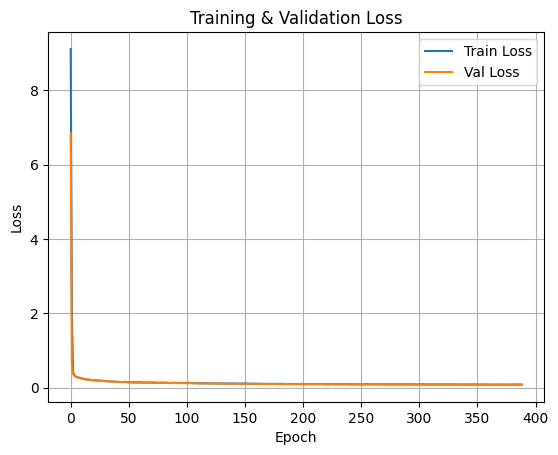

In [461]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


## Model opslaan/inladen

In [ ]:
# torch.save(model, "VGAE7.pt")


In [224]:
model = torch.load("VGAE7.pt", map_location=device, weights_only=False)
model.eval()


VGAE_Bilinear(
  (encoder): GINEncoderThreeLayers(
    (conv1): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.3, inplace=False)
      (4): Linear(in_features=64, out_features=64, bias=True)
    ))
    (conv2): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.3, inplace=False)
      (4): Linear(in_features=64, out_features=64, bias=True)
    ))
    (conv3): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.3, inplace=False)
      (4): Linear(in_features=64, out_features=64, bias=True)
    )

## Resultaten

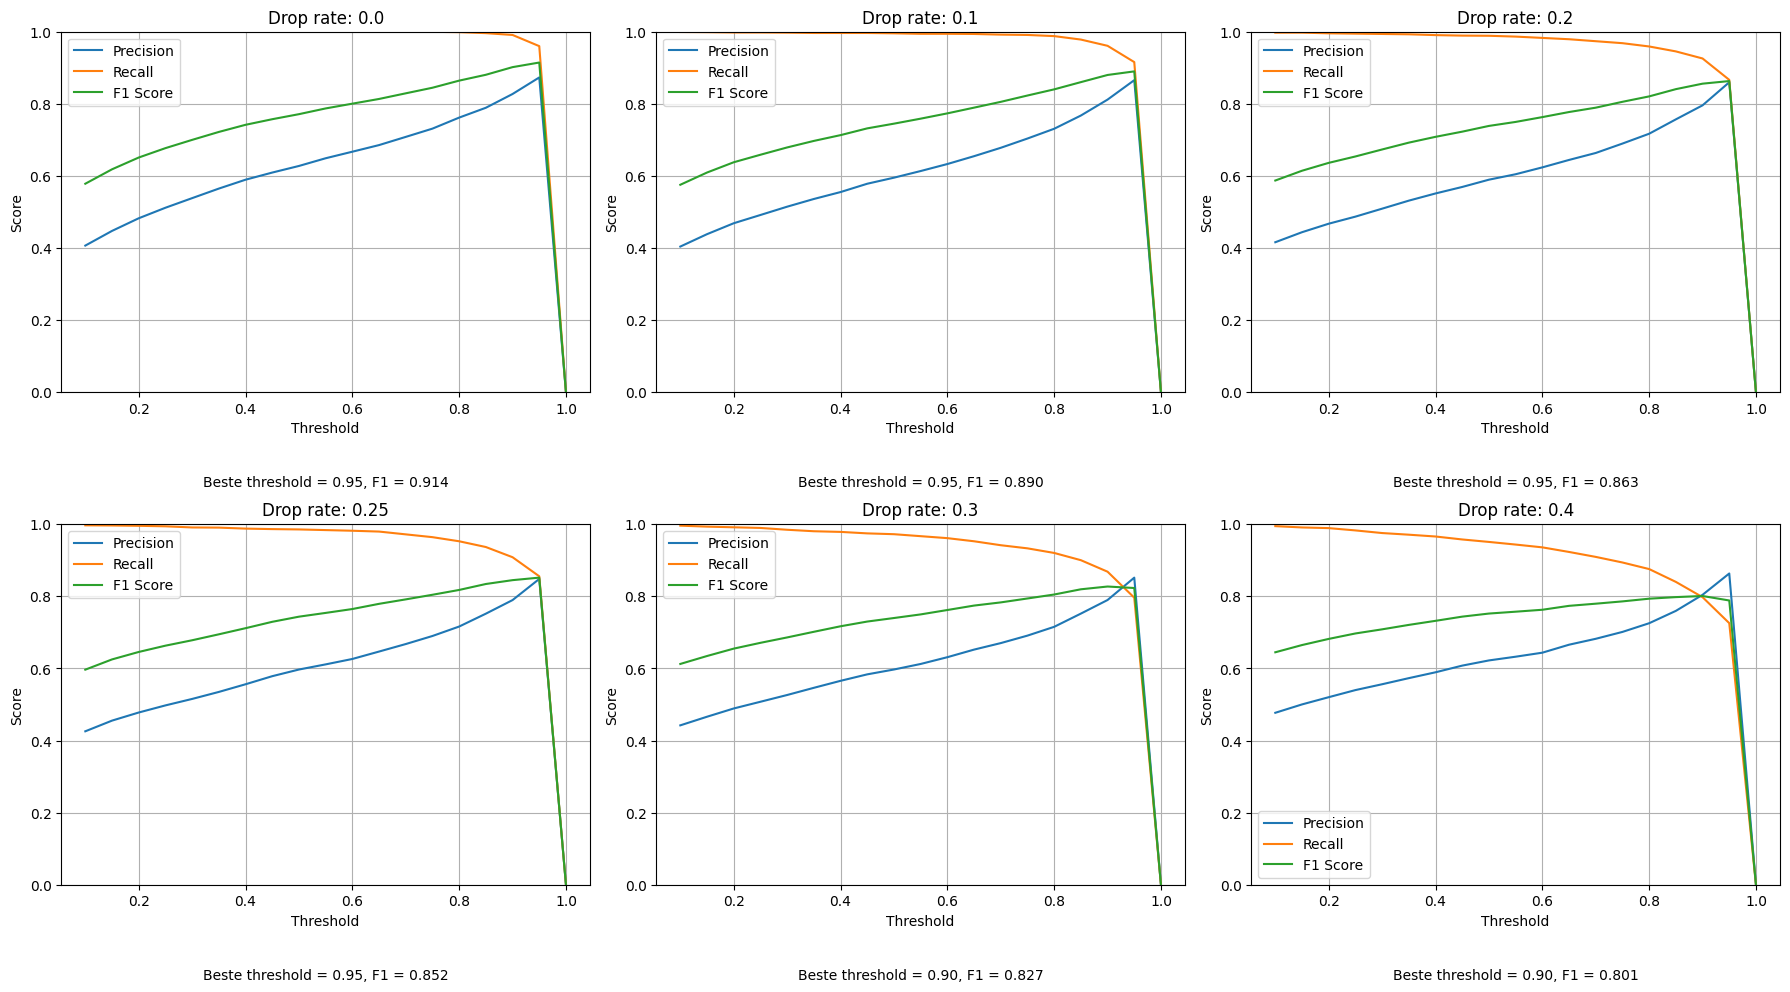

In [ ]:
thresholds = thresholds = np.linspace(0.1, 1.0, 19) 

all_results = {}

for drop_rate, loader in val_loaders.items():
    results = evaluate_link_prediction(model, loader, thresholds)
    all_results[drop_rate] = results


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axs = axs.flatten()

for i, (drop_rate, results) in enumerate(sorted(all_results.items())):
    thresholds = [r['threshold'] for r in results]
    precisions = [r['precision'] for r in results]
    recalls = [r['recall'] for r in results]
    f1_scores = [r['f1_score'] for r in results]


    best_idx = max(range(len(f1_scores)), key=lambda j: f1_scores[j])
    best_thresh = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    ax = axs[i]
    ax.plot(thresholds, precisions, label='Precision')
    ax.plot(thresholds, recalls, label='Recall')
    ax.plot(thresholds, f1_scores, label='F1 Score')

    ax.set_title(f'Drop rate: {drop_rate}')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True)

    ax.text(0.5, -0.25,
            f'Beste threshold = {best_thresh:.2f}, F1 = {best_f1:.3f}',
            ha='center', va='center',
            transform=ax.transAxes, fontsize=10)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


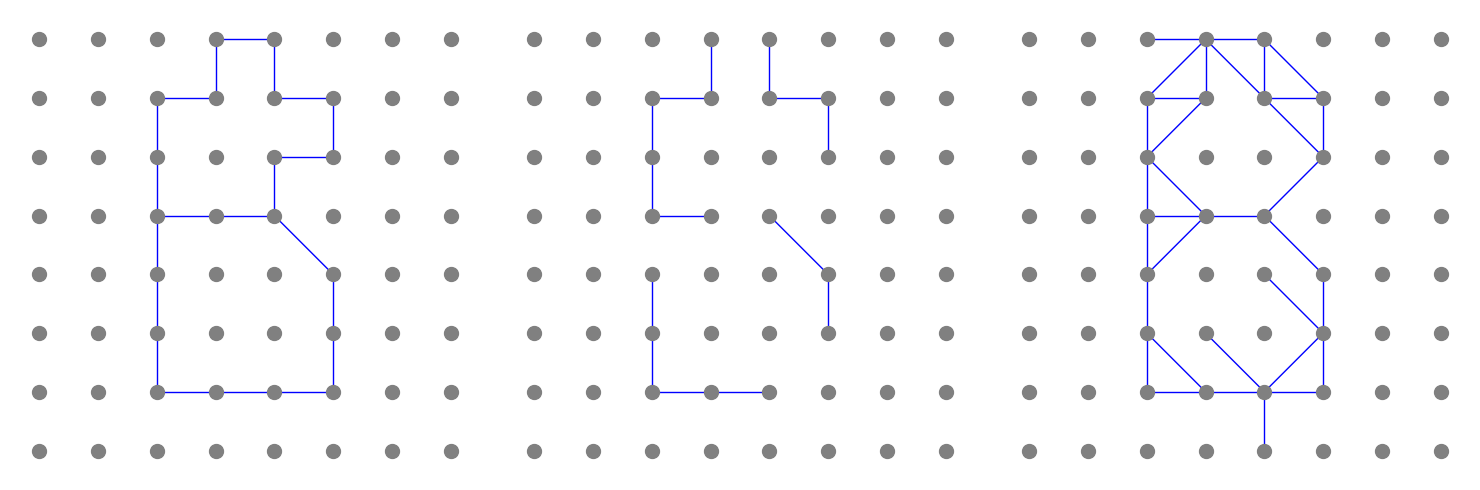

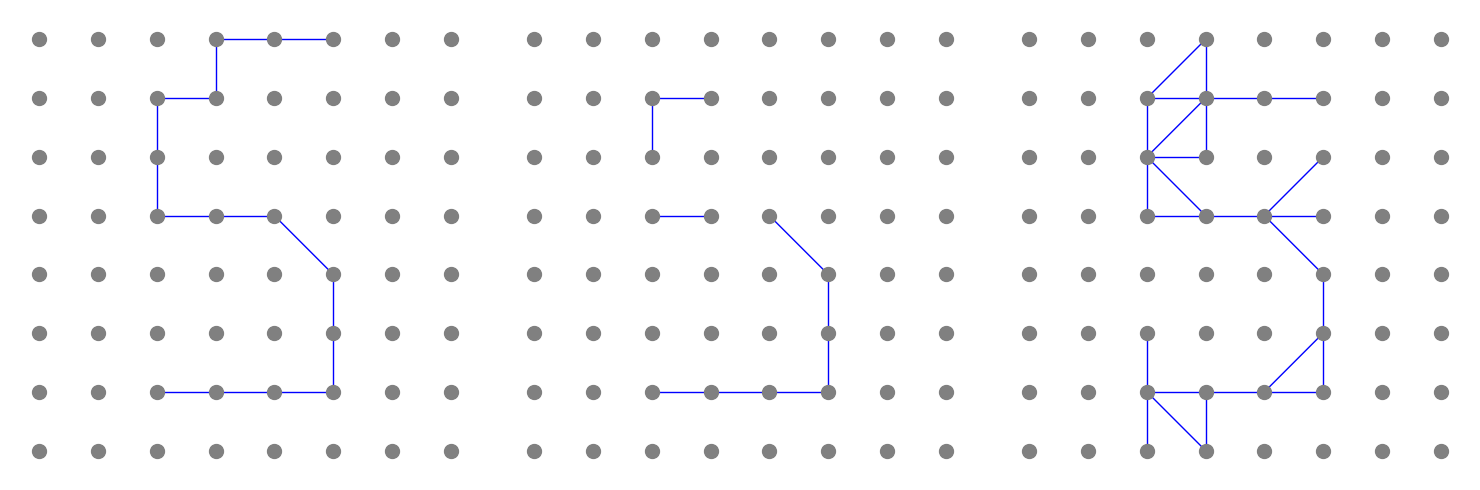

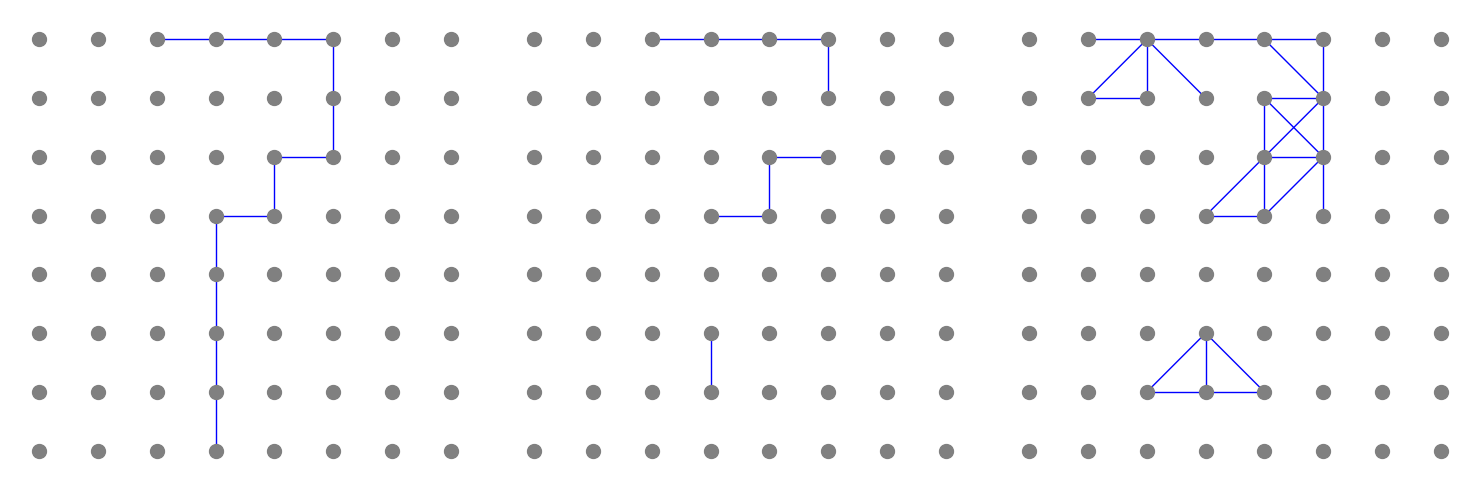

In [ ]:
batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[0])  

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

drop_rate = 0.3
threshold = 0.85
corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)


reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate  
)



batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[1]) 

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)

reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate 
)



batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[10])  

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)

reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate 
)

# Iteratie 8: JK learning

## Modeldefinitie en trainings-/validatiefuncties 

In [ ]:
# --- GIN Encoder met Jumping Knowledge over 3 lagen ---
class GINEncoderWithJK(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        hidden_dim = 2 * out_channels
        dropout_p = 0.3

        self.convs = torch.nn.ModuleList()

        for i in range(3):
            input_dim = in_channels if i == 0 else hidden_dim
            nn = torch.nn.Sequential(
                torch.nn.Linear(input_dim, hidden_dim),
                torch.nn.ReLU(),
                torch.nn.BatchNorm1d(hidden_dim),
                torch.nn.Dropout(p=dropout_p),
                torch.nn.Linear(hidden_dim, hidden_dim)
            )
            self.convs.append(GINConv(nn))

        self.jump = JumpingKnowledge(mode='cat')
        jk_dim = 3 * hidden_dim  # omdat 3 lagen combineren

        self.conv_mu = GINConv(torch.nn.Sequential(
            torch.nn.Linear(jk_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))
        self.conv_logstd = GINConv(torch.nn.Sequential(
            torch.nn.Linear(jk_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))

    def forward(self, x, edge_index):
        xs = []
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            xs.append(x)
        x = self.jump(xs)
        mu = self.conv_mu(x, edge_index)
        logstd = self.conv_logstd(x, edge_index)
        self.mu = mu
        self.logstd = logstd
        return mu, logstd

class BilinearDecoder(torch.nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.weight = torch.nn.Parameter(torch.randn(latent_dim, latent_dim))

    def forward(self, z, edge_index):
        z_src = z[edge_index[0]]
        z_dst = z[edge_index[1]]
        return torch.einsum('bi,ij,bj->b', z_src, self.weight, z_dst)


class VGAE_Bilinear(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def encode(self, x, edge_index):
        mu, logstd = self.encoder(x, edge_index)
        std = torch.exp(logstd)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, edge_index):
        return self.encode(x, edge_index)

    def decode(self, z, edge_index):
        return self.decoder(z, edge_index)

    def recon_loss(self, z, pos_edge_index, neg_edge_index):
        pos_out = self.decoder(z, pos_edge_index)
        neg_out = self.decoder(z, neg_edge_index)
        pos_label = torch.ones_like(pos_out)
        neg_label = torch.zeros_like(neg_out)
        preds = torch.cat([pos_out, neg_out])
        labels = torch.cat([pos_label, neg_label])
        return F.binary_cross_entropy_with_logits(preds, labels)

    def kl_loss(self):
        mu, logstd = self.encoder.mu, self.encoder.logstd
        return -0.5 * torch.mean(1 + 2 * logstd - mu**2 - (2 * logstd).exp())


encoder = GINEncoderWithJK(in_channels=64, out_channels=32)
decoder = BilinearDecoder(latent_dim=32)
model = VGAE_Bilinear(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_step(data):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)
    pos_edge = data.pos_edge_label_index.to(device)
    neg_edge = data.neg_edge_label_index.to(device)
    loss = model.recon_loss(z, pos_edge, neg_edge)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return loss.item()

def validate_step(data):
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        pos_edge = data.pos_edge_label_index.to(device)
        neg_edge = data.neg_edge_label_index.to(device)
        loss = model.recon_loss(z, pos_edge, neg_edge)
        loss = loss + (1 / data.num_nodes) * model.kl_loss()
    return loss.item()


## Trainloop 

In [ ]:
num_epochs = 500
drop_rate = 0.25 
best_val_loss = float('inf')
patience = 20
epochs_no_improve = 0
train_losses = []
val_losses = []

# Vaste gecorrumpeerde validatieset
fixed_val_data = [corrupt_graph(data, drop_rate=drop_rate) for data in val_loader]

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    num_train_batches = 0
    for data in train_loader:
        data = corrupt_graph(data, drop_rate=drop_rate)
        loss = train_step(data)
        total_loss += loss
        num_train_batches += 1

    total_loss_val = 0
    num_val_batches = 0
    for val_data in fixed_val_data:
        val_loss = validate_step(val_data)
        total_loss_val += val_loss
        num_val_batches += 1

    avg_train_loss = total_loss / num_train_batches
    avg_val_loss = total_loss_val / num_val_batches

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch:03d} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "VGAE8.pt")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch:03d}")
        break

Epoch 001 - Train Loss: 6.0999 - Val Loss: 3.7812
Epoch 002 - Train Loss: 0.6341 - Val Loss: 0.3523
Epoch 003 - Train Loss: 0.3298 - Val Loss: 0.2726
Epoch 004 - Train Loss: 0.2774 - Val Loss: 0.2351
Epoch 005 - Train Loss: 0.2632 - Val Loss: 0.2231
Epoch 006 - Train Loss: 0.2396 - Val Loss: 0.2020
Epoch 007 - Train Loss: 0.2233 - Val Loss: 0.1988
Epoch 008 - Train Loss: 0.2114 - Val Loss: 0.1841
Epoch 009 - Train Loss: 0.2028 - Val Loss: 0.1779
Epoch 010 - Train Loss: 0.1937 - Val Loss: 0.1710
Epoch 011 - Train Loss: 0.1905 - Val Loss: 0.1709
Epoch 012 - Train Loss: 0.1824 - Val Loss: 0.1589
Epoch 013 - Train Loss: 0.1760 - Val Loss: 0.1566
Epoch 014 - Train Loss: 0.1684 - Val Loss: 0.1477
Epoch 015 - Train Loss: 0.1621 - Val Loss: 0.1473
Epoch 016 - Train Loss: 0.1573 - Val Loss: 0.1407
Epoch 017 - Train Loss: 0.1556 - Val Loss: 0.1402
Epoch 018 - Train Loss: 0.1473 - Val Loss: 0.1277
Epoch 019 - Train Loss: 0.1440 - Val Loss: 0.1250
Epoch 020 - Train Loss: 0.1414 - Val Loss: 0.1198


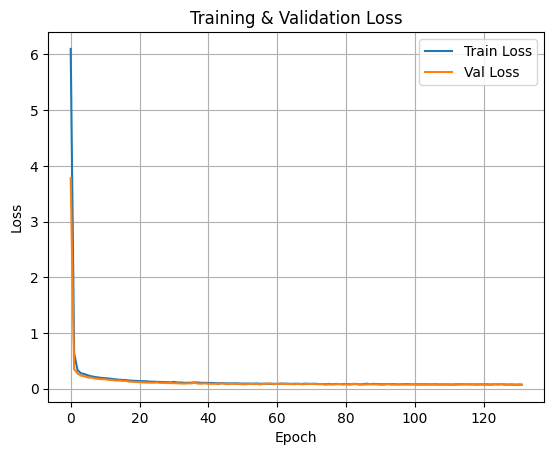

In [237]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()



## Model opslaan/inladen


In [ ]:
# torch.save(model, "VGAE8.pt")


In [239]:
model = torch.load("VGAE8.pt", map_location=device, weights_only=False)
model.eval()


VGAE_Bilinear(
  (encoder): GINEncoderWithJK(
    (convs): ModuleList(
      (0-2): 3 x GINConv(nn=Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.3, inplace=False)
        (4): Linear(in_features=64, out_features=64, bias=True)
      ))
    )
    (jump): JumpingKnowledge(cat)
    (conv_mu): GINConv(nn=Sequential(
      (0): Linear(in_features=192, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
    (conv_logstd): GINConv(nn=Sequential(
      (0): Linear(in_features=192, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
  )
  (decoder): BilinearDecoder()
)


## Resultaten



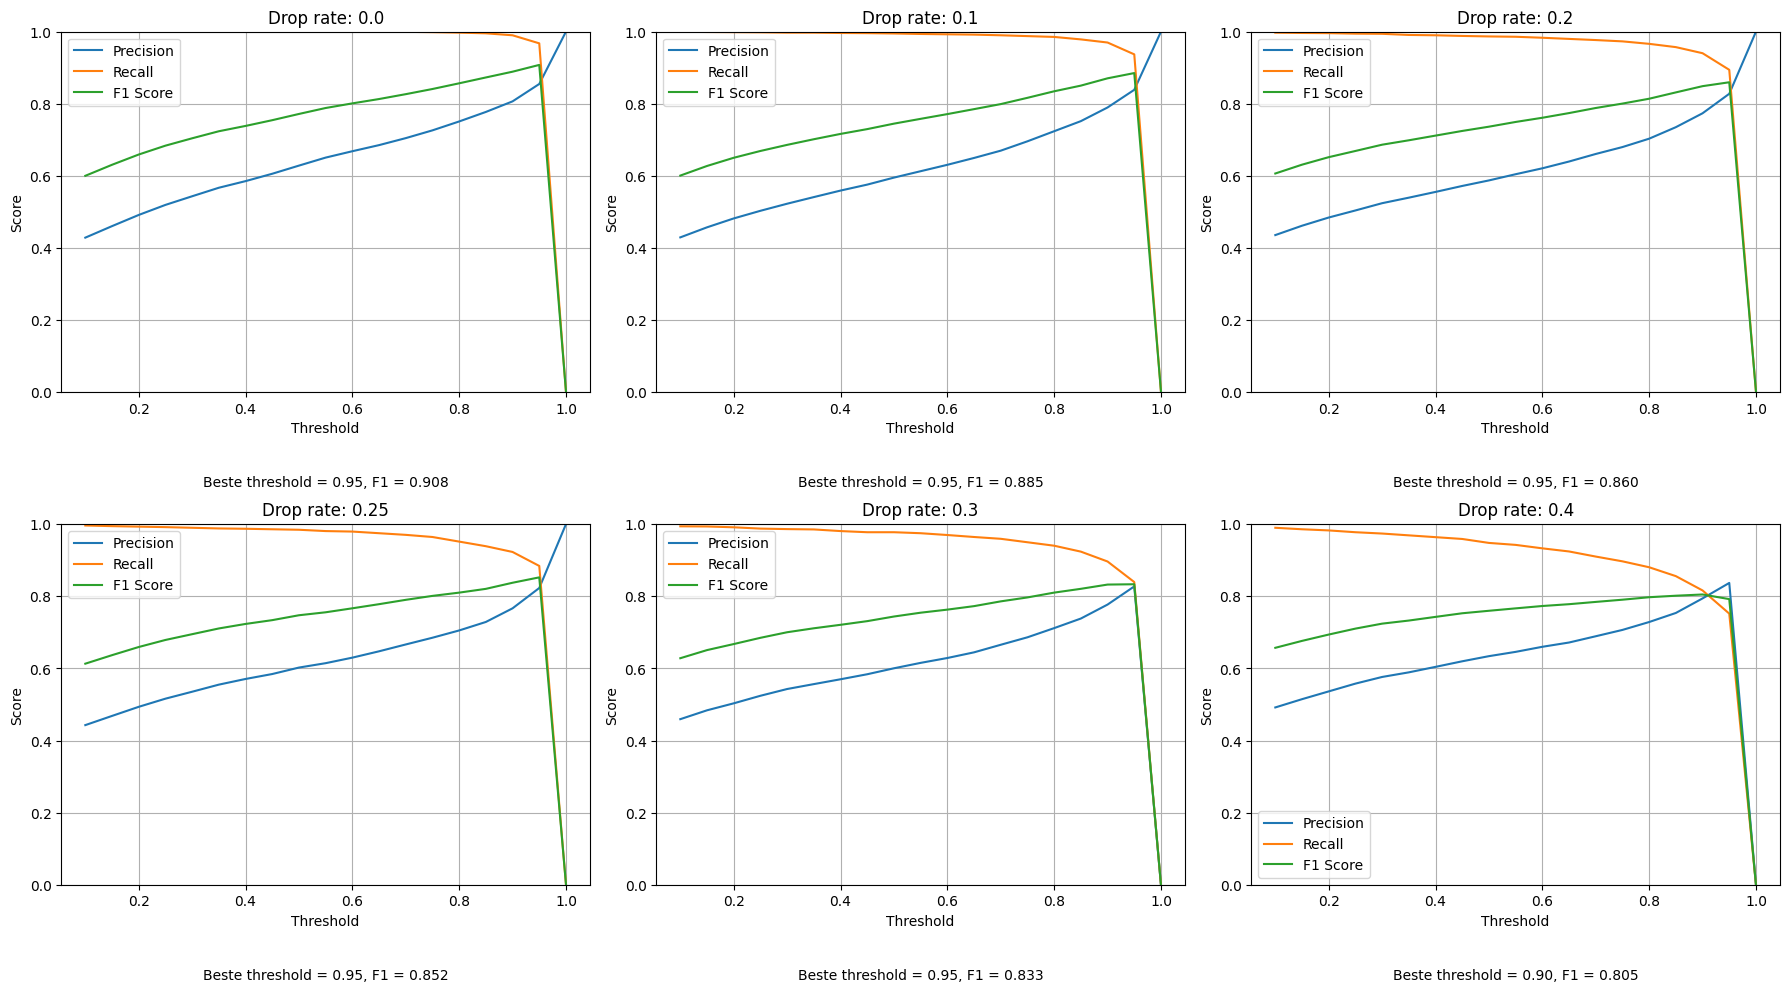

In [ ]:
thresholds = thresholds = np.linspace(0.1, 1.0, 19)  

all_results = {}

for drop_rate, loader in val_loaders.items():
    results = evaluate_link_prediction(model, loader, thresholds)
    all_results[drop_rate] = results


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axs = axs.flatten()

for i, (drop_rate, results) in enumerate(sorted(all_results.items())):
    thresholds = [r['threshold'] for r in results]
    precisions = [r['precision'] for r in results]
    recalls = [r['recall'] for r in results]
    f1_scores = [r['f1_score'] for r in results]

    best_idx = max(range(len(f1_scores)), key=lambda j: f1_scores[j])
    best_thresh = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    ax = axs[i]
    ax.plot(thresholds, precisions, label='Precision')
    ax.plot(thresholds, recalls, label='Recall')
    ax.plot(thresholds, f1_scores, label='F1 Score')

    ax.set_title(f'Drop rate: {drop_rate}')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True)

    ax.text(0.5, -0.25,
            f'Beste threshold = {best_thresh:.2f}, F1 = {best_f1:.3f}',
            ha='center', va='center',
            transform=ax.transAxes, fontsize=10)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


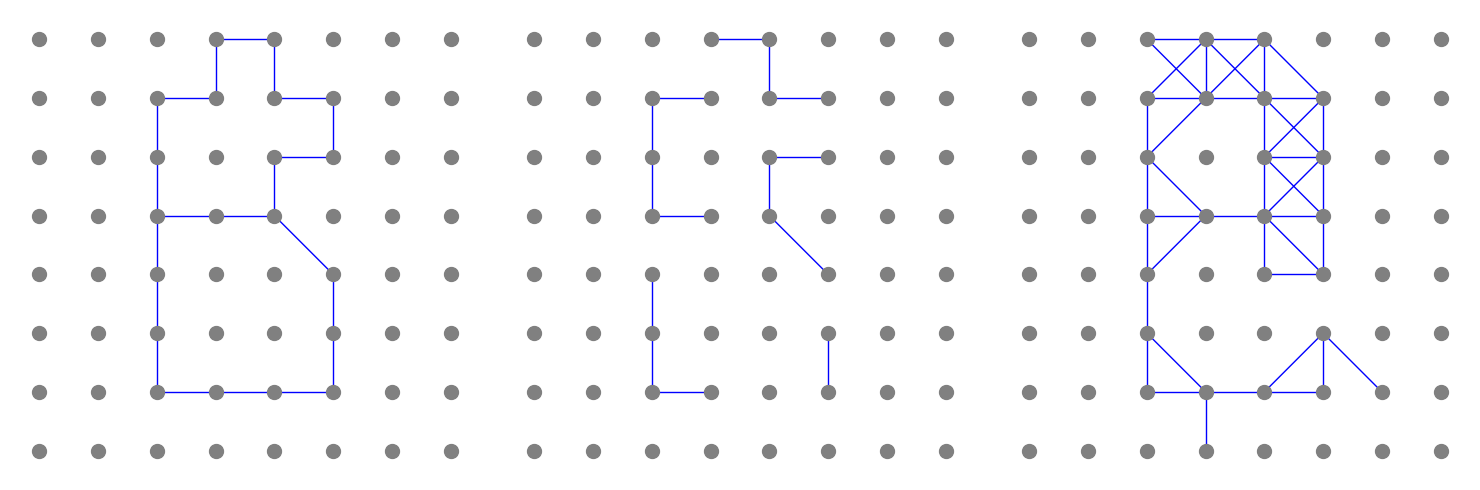

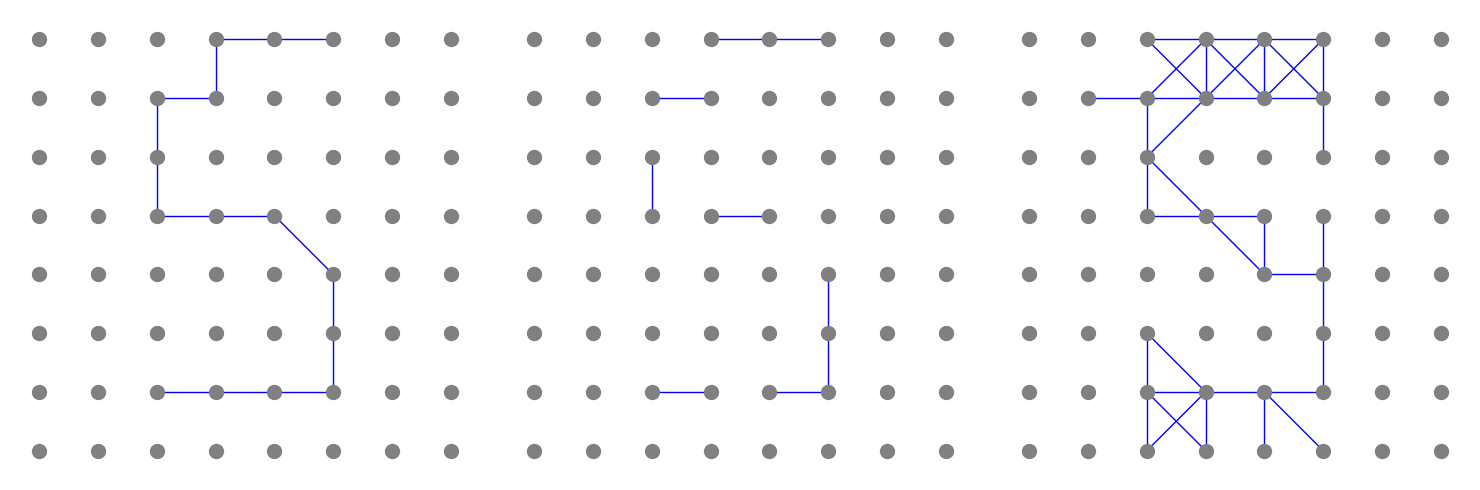

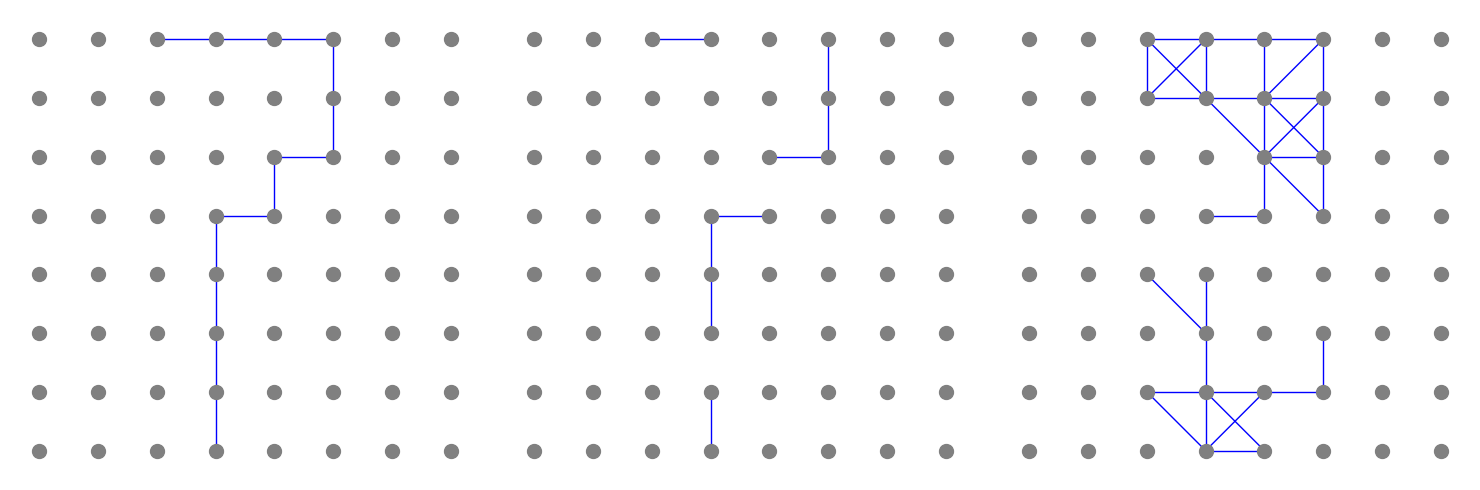

In [ ]:
batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[0])  

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

drop_rate = 0.3
threshold = 0.85
corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)


reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate  
)



batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[1]) 

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)

reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate 
)


batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[10])  

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)

reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate 
)

# Iteratie 9: MLP decoder

## Modeldefinitie en trainings-/validatiefuncties 

In [ ]:
# --- GIN Encoder met Jumping Knowledge over 3 lagen ---
class GINEncoderWithJK(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        hidden_dim = 2 * out_channels
        dropout_p = 0.3

        self.convs = torch.nn.ModuleList()
        for i in range(3):
            input_dim = in_channels if i == 0 else hidden_dim
            nn = torch.nn.Sequential(
                torch.nn.Linear(input_dim, hidden_dim),
                torch.nn.ReLU(),
                torch.nn.BatchNorm1d(hidden_dim),
                torch.nn.Dropout(p=dropout_p),
                torch.nn.Linear(hidden_dim, hidden_dim)
            )
            self.convs.append(GINConv(nn))

        self.jump = JumpingKnowledge(mode='cat')
        jk_dim = 3 * hidden_dim

        self.conv_mu = GINConv(torch.nn.Sequential(
            torch.nn.Linear(jk_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))
        self.conv_logstd = GINConv(torch.nn.Sequential(
            torch.nn.Linear(jk_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))

    def forward(self, x, edge_index):
        xs = []
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            xs.append(x)
        x = self.jump(xs)
        mu = self.conv_mu(x, edge_index)
        logstd = self.conv_logstd(x, edge_index)
        self.mu = mu
        self.logstd = logstd
        return mu, logstd

# --- MLP Decoder ---
class MLPDecoder(torch.nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * latent_dim, latent_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(latent_dim, 1)
        )

    def forward(self, z, edge_index):
        z_i = z[edge_index[0]]
        z_j = z[edge_index[1]]
        z_pair = torch.cat([z_i, z_j], dim=1)
        return self.mlp(z_pair).squeeze()

# --- VGAE met MLP decoder ---
class VGAE_MLP(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def encode(self, x, edge_index):
        mu, logstd = self.encoder(x, edge_index)
        std = torch.exp(logstd)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, edge_index):
        return self.encode(x, edge_index)

    def decode(self, z, edge_index):
        return self.decoder(z, edge_index)

    def recon_loss(self, z, pos_edge_index, neg_edge_index):
        pos_out = self.decoder(z, pos_edge_index)
        neg_out = self.decoder(z, neg_edge_index)
        pos_label = torch.ones_like(pos_out)
        neg_label = torch.zeros_like(neg_out)
        preds = torch.cat([pos_out, neg_out])
        labels = torch.cat([pos_label, neg_label])
        return F.binary_cross_entropy_with_logits(preds, labels)

    def kl_loss(self):
        mu, logstd = self.encoder.mu, self.encoder.logstd
        return -0.5 * torch.mean(1 + 2 * logstd - mu**2 - (2 * logstd).exp())

encoder = GINEncoderWithJK(in_channels=64, out_channels=32)
decoder = MLPDecoder(latent_dim=32)
model = VGAE_MLP(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_step(data):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)
    pos_edge = data.pos_edge_label_index.to(device)
    neg_edge = data.neg_edge_label_index.to(device)
    loss = model.recon_loss(z, pos_edge, neg_edge)
    loss += (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return loss.item()

def validate_step(data):
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        pos_edge = data.pos_edge_label_index.to(device)
        neg_edge = data.neg_edge_label_index.to(device)
        loss = model.recon_loss(z, pos_edge, neg_edge)
        loss += (1 / data.num_nodes) * model.kl_loss()
    return loss.item()


## Trainloop 

In [ ]:
num_epochs = 500
drop_rate = 0.25 
best_val_loss = float('inf')
patience = 20
epochs_no_improve = 0
train_losses = []
val_losses = []

fixed_val_data = []
for batch in val_loader:
    fixed_val_data.append(corrupt_graph(batch, drop_rate=drop_rate))

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    num_train_batches = 0
    for data in train_loader:
        data = corrupt_graph(data, drop_rate=drop_rate)
        loss = train_step(data)
        total_loss += loss
        num_train_batches += 1

    total_loss_val = 0
    num_val_batches = 0
    for val_data in fixed_val_data:
        val_loss = validate_step(val_data)
        total_loss_val += val_loss
        num_val_batches += 1

    avg_train_loss = total_loss / num_train_batches
    avg_val_loss = total_loss_val / num_val_batches

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch:03d} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "VGAE9.pt")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch:03d}")
        break

Epoch 001 - Train Loss: 0.4822 - Val Loss: 0.6501
Epoch 002 - Train Loss: 0.2542 - Val Loss: 0.2525
Epoch 003 - Train Loss: 0.2292 - Val Loss: 0.2437
Epoch 004 - Train Loss: 0.2181 - Val Loss: 0.2315
Epoch 005 - Train Loss: 0.2050 - Val Loss: 0.2130
Epoch 006 - Train Loss: 0.1913 - Val Loss: 0.1956
Epoch 007 - Train Loss: 0.1787 - Val Loss: 0.1794
Epoch 008 - Train Loss: 0.1612 - Val Loss: 0.1650
Epoch 009 - Train Loss: 0.1517 - Val Loss: 0.1547
Epoch 010 - Train Loss: 0.1421 - Val Loss: 0.1495
Epoch 011 - Train Loss: 0.1375 - Val Loss: 0.1397
Epoch 012 - Train Loss: 0.1355 - Val Loss: 0.1330
Epoch 013 - Train Loss: 0.1315 - Val Loss: 0.1308
Epoch 014 - Train Loss: 0.1239 - Val Loss: 0.1324
Epoch 015 - Train Loss: 0.1229 - Val Loss: 0.1259
Epoch 016 - Train Loss: 0.1224 - Val Loss: 0.1235
Epoch 017 - Train Loss: 0.1163 - Val Loss: 0.1266
Epoch 018 - Train Loss: 0.1218 - Val Loss: 0.1231
Epoch 019 - Train Loss: 0.1185 - Val Loss: 0.1181
Epoch 020 - Train Loss: 0.1167 - Val Loss: 0.1176


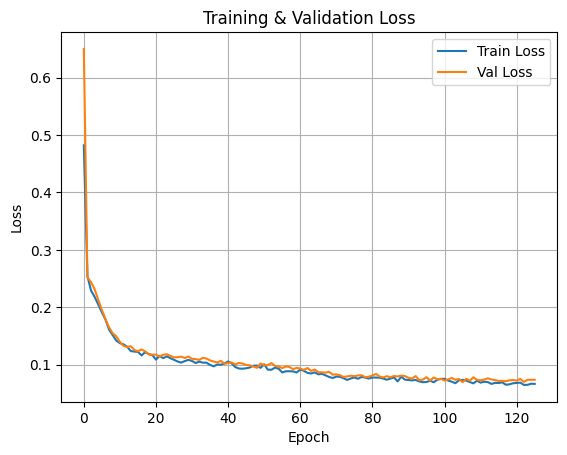

In [51]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


## Model opslaan/inladen

In [ ]:
# torch.save(model, "VGAE9.pt")


In [371]:
model = torch.load("VGAE9.pt", map_location=device, weights_only=False)
model.eval()


VGAE_MLP(
  (encoder): GINEncoderWithJK(
    (convs): ModuleList(
      (0-2): 3 x GINConv(nn=Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.3, inplace=False)
        (4): Linear(in_features=64, out_features=64, bias=True)
      ))
    )
    (jump): JumpingKnowledge(cat)
    (conv_mu): GINConv(nn=Sequential(
      (0): Linear(in_features=192, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
    (conv_logstd): GINConv(nn=Sequential(
      (0): Linear(in_features=192, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
  )
  (decoder): MLPDecoder(
    (mlp): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=1,

## Resultaten

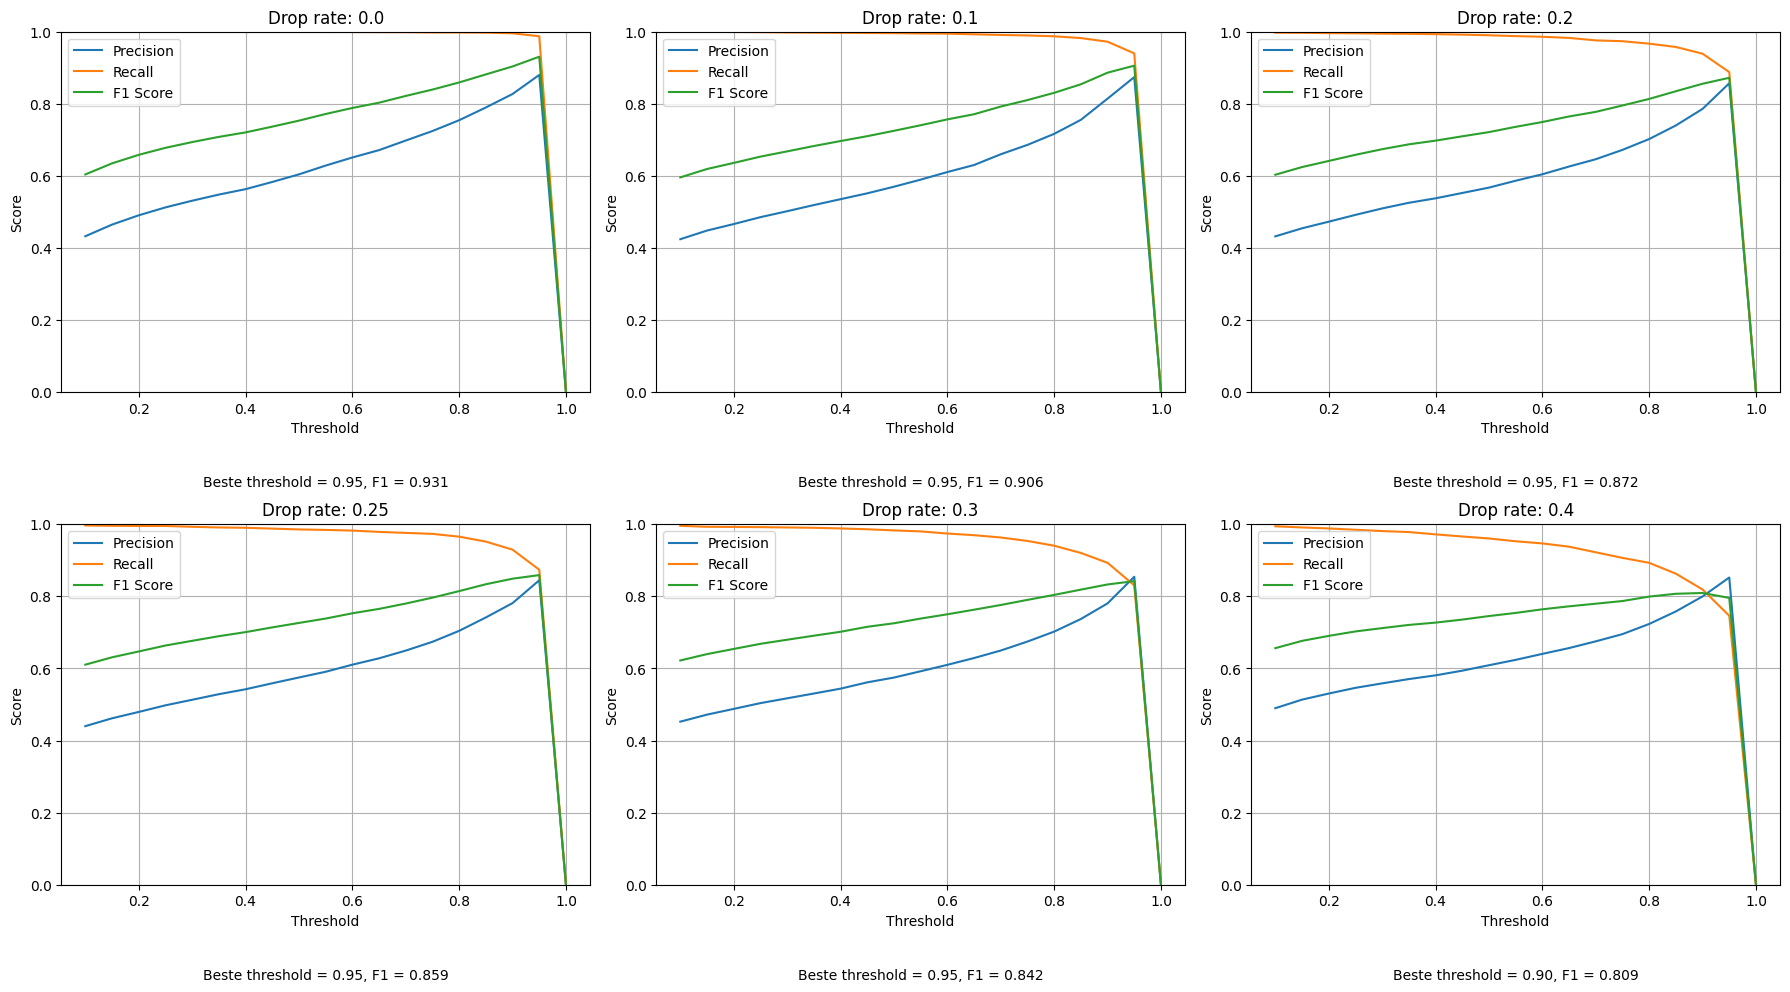

In [ ]:
thresholds = thresholds = np.linspace(0.1, 1.0, 19)  

all_results = {}

for drop_rate, loader in val_loaders.items():
    results = evaluate_link_prediction(model, loader, thresholds)
    all_results[drop_rate] = results


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axs = axs.flatten()

for i, (drop_rate, results) in enumerate(sorted(all_results.items())):
    thresholds = [r['threshold'] for r in results]
    precisions = [r['precision'] for r in results]
    recalls = [r['recall'] for r in results]
    f1_scores = [r['f1_score'] for r in results]

    best_idx = max(range(len(f1_scores)), key=lambda j: f1_scores[j])
    best_thresh = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    ax = axs[i]
    ax.plot(thresholds, precisions, label='Precision')
    ax.plot(thresholds, recalls, label='Recall')
    ax.plot(thresholds, f1_scores, label='F1 Score')

    ax.set_title(f'Drop rate: {drop_rate}')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True)

    ax.text(0.5, -0.25,
            f'Beste threshold = {best_thresh:.2f}, F1 = {best_f1:.3f}',
            ha='center', va='center',
            transform=ax.transAxes, fontsize=10)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


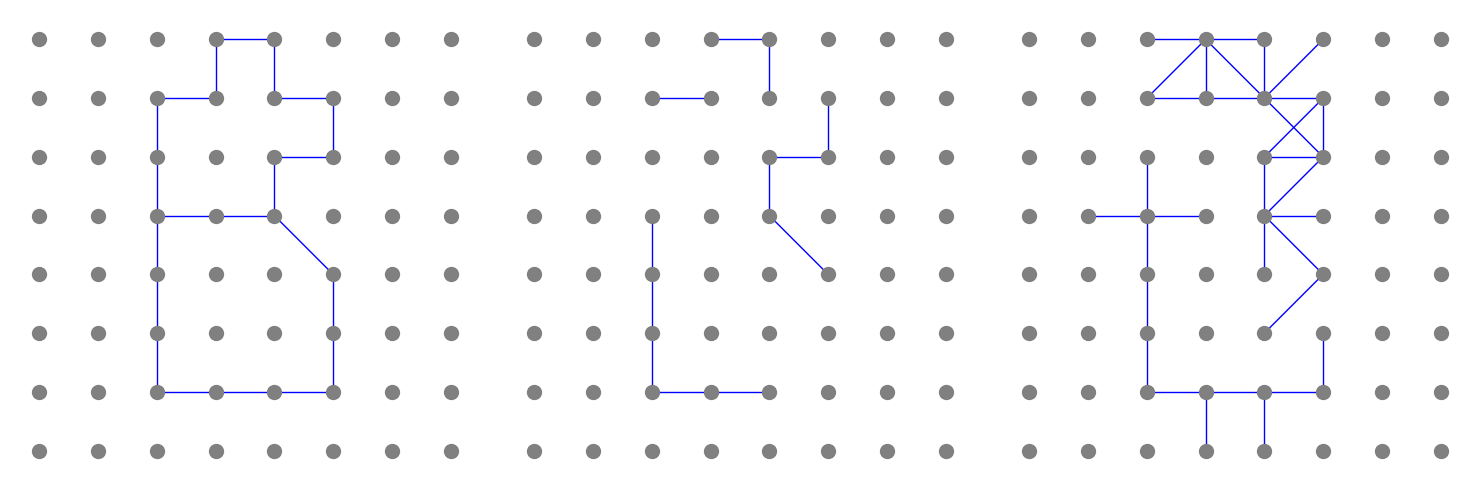

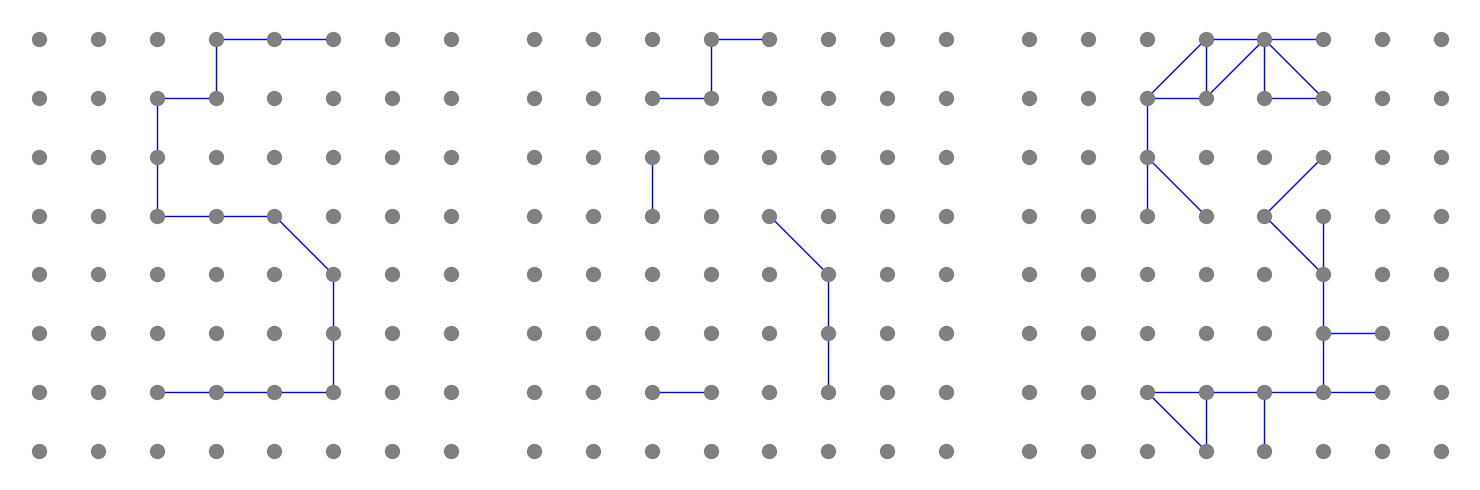

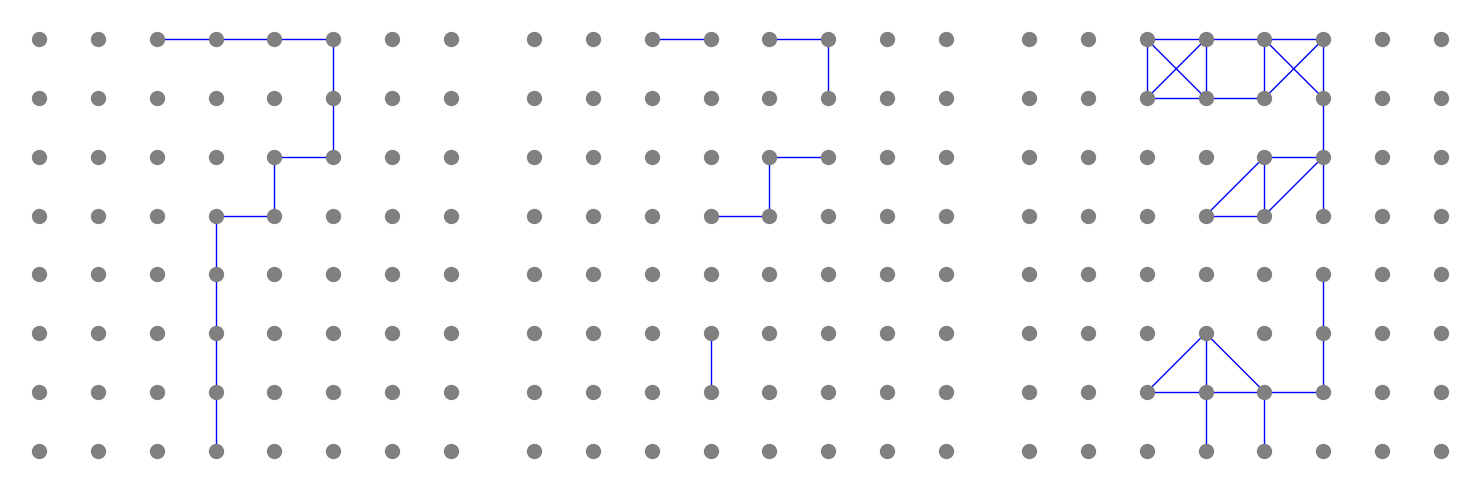

In [ ]:
batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[0])  

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

drop_rate = 0.3
threshold = 0.85
corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)


reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate  
)



batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[1]) 

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)

reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate 
)


batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[10])  

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)

reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate 
)

# Iteratie 10: Contrastive loss

## Modeldefinitie en trainings-/validatiefuncties 

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv, JumpingKnowledge
from torch_geometric.nn import global_mean_pool

def corrupt_graph(data, drop_rate=0.25):
    edge_index = data.edge_index
    edge_index, _ = remove_self_loops(edge_index)

    # Maak set van unieke (gesorteerde) edges
    edges = [tuple(sorted((u.item(), v.item()))) for u, v in edge_index.t()]
    unique_edges = list(set(edges))

    num_total = len(unique_edges)
    num_keep = int((1 - drop_rate) * num_total)

    perm = torch.randperm(num_total)[:num_keep]
    kept_edges = [unique_edges[i] for i in perm]

    kept_edges_tensor = torch.tensor(kept_edges, dtype=torch.long).t()
    edge_index_corrupt = to_undirected(kept_edges_tensor)

    neg_edge_index = negative_sampling(
        edge_index=edge_index_corrupt,
        num_nodes=data.num_nodes,
        num_neg_samples=edge_index_corrupt.size(1)
    )

    data.edge_index = edge_index_corrupt
    data.pos_edge_label_index = torch.tensor(unique_edges, dtype=torch.long).t()
    data.neg_edge_label_index = neg_edge_index

    if hasattr(data, "batch"):
        data.batch = data.batch.clone()

    return data

def graph_contrastive_loss(z1, z2, batch1, batch2, temperature=0.7):
    g1 = global_mean_pool(z1, batch1)  # [B, D]
    g2 = global_mean_pool(z2, batch2)  # [B, D]

    g1 = F.normalize(g1, dim=-1)
    g2 = F.normalize(g2, dim=-1)
    reps = torch.cat([g1, g2], dim=0)  # [2B, D]

    sim = torch.matmul(reps, reps.T) / temperature
    sim.fill_diagonal_(-9e15)

    batch_size = g1.size(0)
    labels = torch.arange(batch_size, device=z1.device)
    pos_sim = (g1 * g2).sum(dim=1) / temperature
    neg_sim = torch.exp(sim).sum(dim=1)[:batch_size]

    return -torch.log(torch.exp(pos_sim) / neg_sim).mean()

class GINEncoderWithJK(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        hidden_dim = 2 * out_channels
        dropout_p = 0.3

        self.convs = torch.nn.ModuleList()
        for i in range(3):
            input_dim = in_channels if i == 0 else hidden_dim
            nn = torch.nn.Sequential(
                torch.nn.Linear(input_dim, hidden_dim),
                torch.nn.ReLU(),
                torch.nn.BatchNorm1d(hidden_dim),
                torch.nn.Dropout(p=dropout_p),
                torch.nn.Linear(hidden_dim, hidden_dim)
            )
            self.convs.append(GINConv(nn))

        self.jump = JumpingKnowledge(mode='cat')
        jk_dim = 3 * hidden_dim

        self.conv_mu = GINConv(torch.nn.Sequential(
            torch.nn.Linear(jk_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))
        self.conv_logstd = GINConv(torch.nn.Sequential(
            torch.nn.Linear(jk_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))

    def forward(self, x, edge_index):
        xs = []
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            xs.append(x)
        x = self.jump(xs)
        mu = self.conv_mu(x, edge_index)
        logstd = self.conv_logstd(x, edge_index)
        self.mu = mu
        self.logstd = logstd
        return mu, logstd

class MLPDecoder(torch.nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * latent_dim, latent_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(latent_dim, 1)
        )

    def forward(self, z, edge_index):
        z_i = z[edge_index[0]]
        z_j = z[edge_index[1]]
        z_pair = torch.cat([z_i, z_j], dim=1)
        return self.mlp(z_pair).squeeze()

class VGAE_MLP(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def encode(self, x, edge_index):
        mu, logstd = self.encoder(x, edge_index)
        std = torch.exp(logstd)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, edge_index):
        return self.encode(x, edge_index)

    def decode(self, z, edge_index):
        return self.decoder(z, edge_index)

    def recon_loss(self, z, pos_edge_index, neg_edge_index):
        pos_out = self.decoder(z, pos_edge_index)
        neg_out = self.decoder(z, neg_edge_index)
        pos_label = torch.ones_like(pos_out)
        neg_label = torch.zeros_like(neg_out)
        preds = torch.cat([pos_out, neg_out])
        labels = torch.cat([pos_label, neg_label])
        return F.binary_cross_entropy_with_logits(preds, labels)

    def kl_loss(self):
        mu, logstd = self.encoder.mu, self.encoder.logstd
        return -0.5 * torch.mean(1 + 2 * logstd - mu**2 - (2 * logstd).exp())

encoder = GINEncoderWithJK(in_channels=64, out_channels=32)
decoder = MLPDecoder(latent_dim=32)
model = VGAE_MLP(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_step_contrastive(data, drop_rate=0.25, contrastive_weight=0.2):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()

    view1 = corrupt_graph(data.clone(), drop_rate=0.25)
    view2 = corrupt_graph(data.clone(), drop_rate=0.25)

    z1 = model.encode(view1.x, view1.edge_index)
    z2 = model.encode(view2.x, view2.edge_index)

    recon = model.recon_loss(z1, view1.pos_edge_label_index, view1.neg_edge_label_index)
    kl = (1 / data.num_nodes) * model.kl_loss()
    contrast = graph_contrastive_loss(z1, z2, view1.batch, view2.batch)

    loss = recon + kl + contrastive_weight * contrast
    loss.backward()
    optimizer.step()

    return {"total": loss.item(), "recon": recon.item(), "kl": kl.item(), "contrastive": contrast.item()}

def validate_step(data):
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        pos_edge = data.pos_edge_label_index.to(device)
        neg_edge = data.neg_edge_label_index.to(device)
        loss = model.recon_loss(z, pos_edge, neg_edge)
        loss += (1 / data.num_nodes) * model.kl_loss()
    return loss.item()



## Trainloop 

In [ ]:
num_epochs = 500
drop_rate = 0.25
contrastive_weight = 0.1
best_val_loss = float('inf')
patience = 20
epochs_no_improve = 0
train_losses = []
val_losses = []

# Maak vaste validatie batches (gecorrumpeerd)
fixed_val_data = [corrupt_graph(batch, drop_rate=drop_rate) for batch in val_loader]

for epoch in range(1, num_epochs + 1):
    model.train()
    total_total = total_recon = total_kl = total_contrast = 0.0
    num_train_batches = 0

    for data in train_loader:
        log = train_step_contrastive(data, drop_rate=drop_rate, contrastive_weight=contrastive_weight)
        total_total += log["total"]
        total_recon += log["recon"]
        total_kl += log["kl"]
        total_contrast += log["contrastive"]
        num_train_batches += 1

    avg_total = total_total / num_train_batches
    avg_recon = total_recon / num_train_batches
    avg_kl = total_kl / num_train_batches
    avg_contrast = total_contrast / num_train_batches

    total_loss_val = 0.0
    num_val_batches = 0
    for val_data in fixed_val_data:
        val_loss = validate_step(val_data)
        total_loss_val += val_loss
        num_val_batches += 1
    avg_val_loss = total_loss_val / num_val_batches

    train_losses.append(avg_total)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch:03d} | Total: {avg_total:.4f} | Recon: {avg_recon:.4f} | KL: {avg_kl:.4f} | Contrast: {avg_contrast:.4f} | Val: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "VGAE911.pt")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch:03d}")
        break


Epoch 001 | Total: 0.7754 | Recon: 0.4305 | KL: 0.0039 | Contrast: 3.4095 | Val: 0.3603
Epoch 002 | Total: 0.5069 | Recon: 0.1694 | KL: 0.0073 | Contrast: 3.3019 | Val: 0.2994
Epoch 003 | Total: 0.4656 | Recon: 0.1565 | KL: 0.0068 | Contrast: 3.0228 | Val: 0.2582
Epoch 004 | Total: 0.4367 | Recon: 0.1425 | KL: 0.0073 | Contrast: 2.8678 | Val: 0.2503
Epoch 005 | Total: 0.4215 | Recon: 0.1358 | KL: 0.0065 | Contrast: 2.7928 | Val: 0.2329
Epoch 006 | Total: 0.3942 | Recon: 0.1229 | KL: 0.0063 | Contrast: 2.6495 | Val: 0.2419
Epoch 007 | Total: 0.3839 | Recon: 0.1225 | KL: 0.0064 | Contrast: 2.5496 | Val: 0.2428
Epoch 008 | Total: 0.3705 | Recon: 0.1147 | KL: 0.0063 | Contrast: 2.4957 | Val: 0.2246
Epoch 009 | Total: 0.3620 | Recon: 0.1054 | KL: 0.0065 | Contrast: 2.5017 | Val: 0.2091
Epoch 010 | Total: 0.3559 | Recon: 0.1005 | KL: 0.0067 | Contrast: 2.4869 | Val: 0.2145
Epoch 011 | Total: 0.3522 | Recon: 0.0974 | KL: 0.0065 | Contrast: 2.4828 | Val: 0.1938
Epoch 012 | Total: 0.3432 | Reco

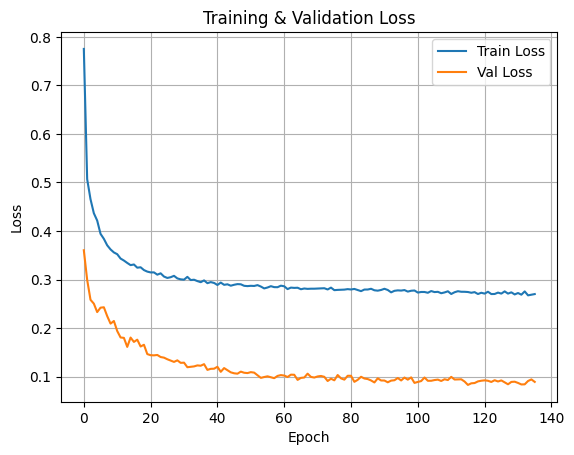

In [277]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


## Model opslaan/inladen

In [ ]:
# torch.save(model, "VGAE911.pt")


In [363]:
model = torch.load("VGAE911.pt", map_location=device, weights_only=False)
model.eval()


VGAE_MLP(
  (encoder): GINEncoderWithJK(
    (convs): ModuleList(
      (0-2): 3 x GINConv(nn=Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.3, inplace=False)
        (4): Linear(in_features=64, out_features=64, bias=True)
      ))
    )
    (jump): JumpingKnowledge(cat)
    (conv_mu): GINConv(nn=Sequential(
      (0): Linear(in_features=192, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
    (conv_logstd): GINConv(nn=Sequential(
      (0): Linear(in_features=192, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
  )
  (decoder): MLPDecoder(
    (mlp): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=1,

## Resultaten

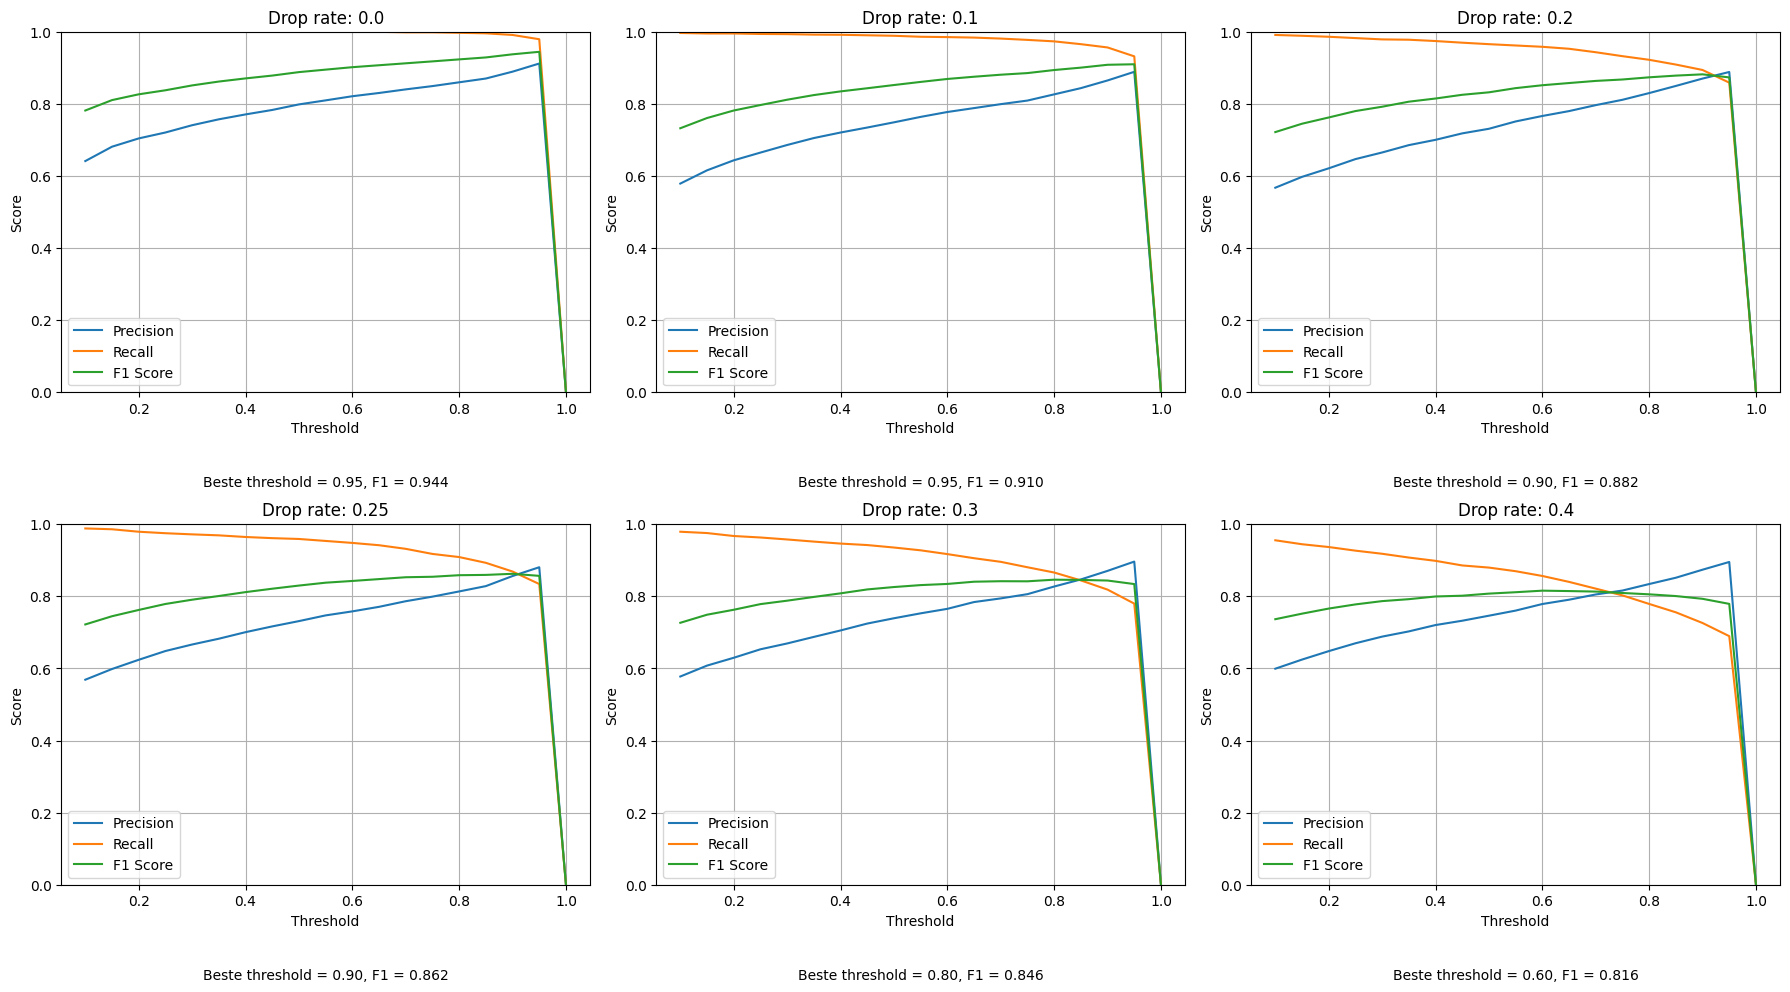

In [ ]:
def corrupt_graph(data, drop_rate=0.25):
    edge_index = data.edge_index
    edge_index, _ = remove_self_loops(edge_index)

    edges = [tuple(sorted((u.item(), v.item()))) for u, v in edge_index.t()]
    unique_edges = list(set(edges))

    num_total = len(unique_edges)
    num_keep = int((1 - drop_rate) * num_total)

    perm = torch.randperm(num_total)[:num_keep]
    kept_edges = [unique_edges[i] for i in perm]

    kept_edges_tensor = torch.tensor(kept_edges, dtype=torch.long).t()
    edge_index_corrupt = to_undirected(kept_edges_tensor)

    neg_edge_index = negative_sampling(
        edge_index=edge_index_corrupt,
        num_nodes=data.num_nodes,
        num_neg_samples=edge_index_corrupt.size(1)
    )

    data.edge_index = edge_index_corrupt
    data.pos_edge_label_index = torch.tensor(unique_edges, dtype=torch.long).t()
    data.neg_edge_label_index = neg_edge_index

    return data


thresholds = thresholds = np.linspace(0.1, 1.0, 19)  

all_results = {}

for drop_rate, loader in val_loaders.items():
    results = evaluate_link_prediction(model, loader, thresholds)
    all_results[drop_rate] = results


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axs = axs.flatten()

for i, (drop_rate, results) in enumerate(sorted(all_results.items())):
    thresholds = [r['threshold'] for r in results]
    precisions = [r['precision'] for r in results]
    recalls = [r['recall'] for r in results]
    f1_scores = [r['f1_score'] for r in results]

    # Beste threshold op basis van hoogste F1
    best_idx = max(range(len(f1_scores)), key=lambda j: f1_scores[j])
    best_thresh = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    ax = axs[i]
    ax.plot(thresholds, precisions, label='Precision')
    ax.plot(thresholds, recalls, label='Recall')
    ax.plot(thresholds, f1_scores, label='F1 Score')

    ax.set_title(f'Drop rate: {drop_rate}')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True)

    # Zet tekst onder de plot
    ax.text(0.5, -0.25,
            f'Beste threshold = {best_thresh:.2f}, F1 = {best_f1:.3f}',
            ha='center', va='center',
            transform=ax.transAxes, fontsize=10)

# Verwijder lege assen als minder dan 6
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


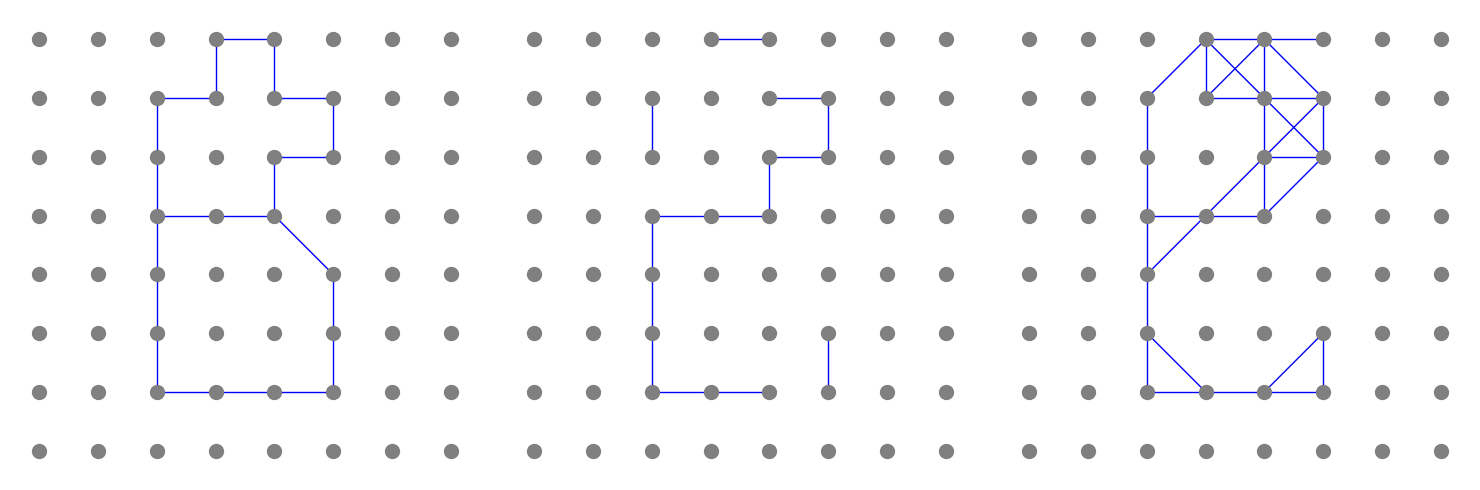

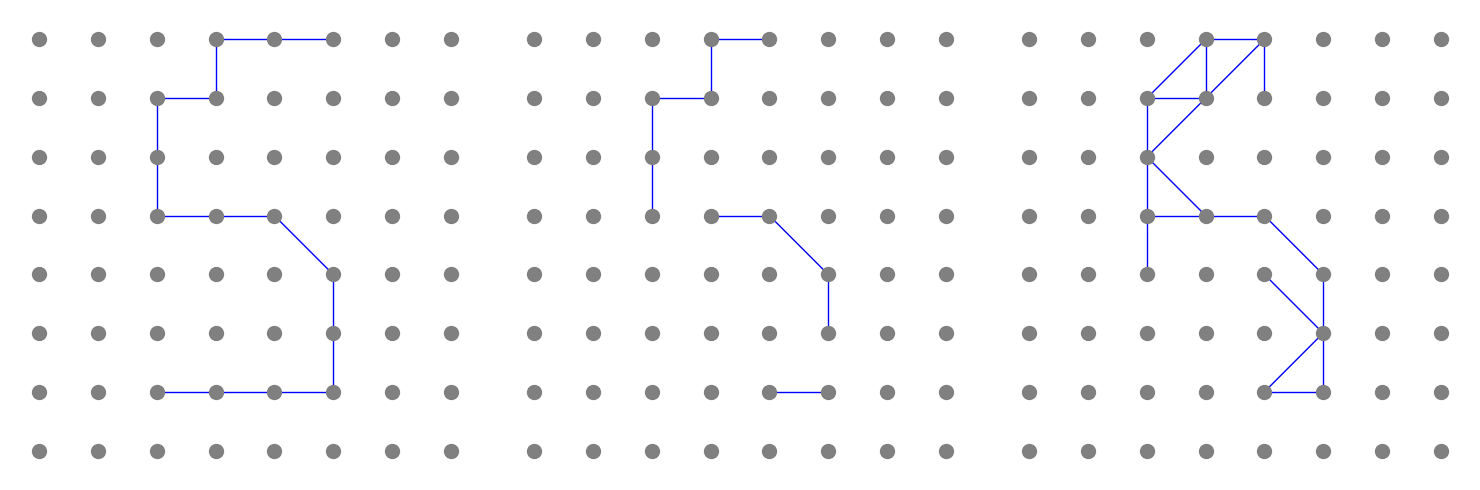

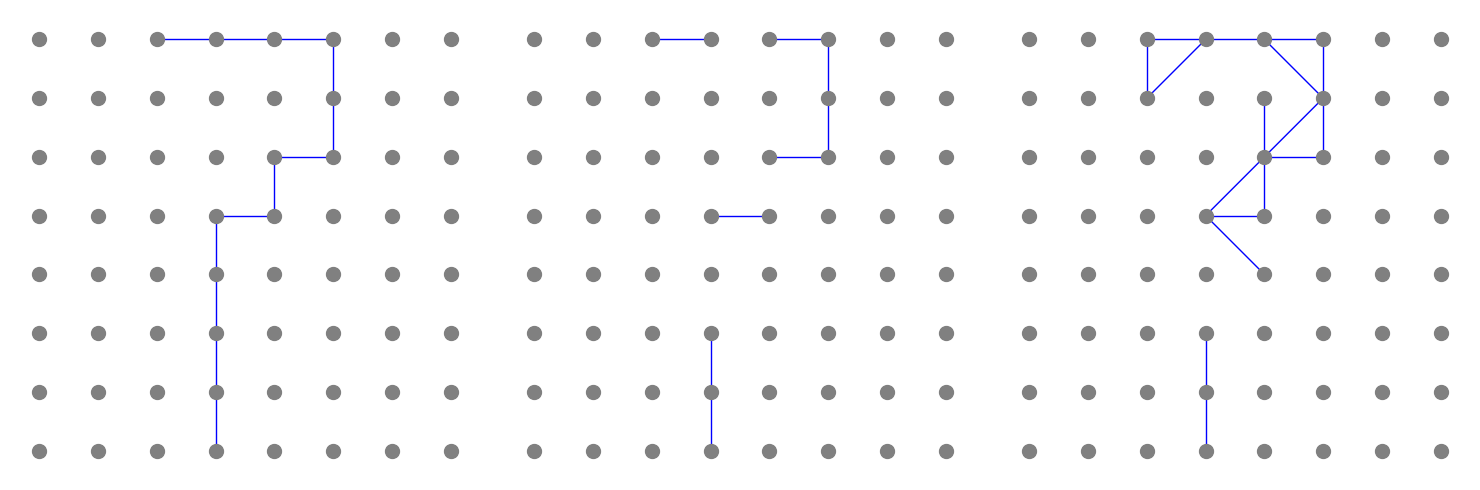

In [ ]:
batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[0])  

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

drop_rate = 0.3
threshold = 0.85
corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)


reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate  
)



batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[1]) 

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)

reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate 
)


batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[10])  

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)

reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate 
)

# Iteratie 11: hard negative sampling

## Modeldefinitie en trainings-/validatiefuncties 

In [ ]:
class GINEncoderWithJK(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        hidden_dim = 2 * out_channels
        dropout_p = 0.3

        self.convs = torch.nn.ModuleList()
        for i in range(3):
            input_dim = in_channels if i == 0 else hidden_dim
            nn = torch.nn.Sequential(
                torch.nn.Linear(input_dim, hidden_dim),
                torch.nn.ReLU(),
                torch.nn.BatchNorm1d(hidden_dim),
                torch.nn.Dropout(p=dropout_p),
                torch.nn.Linear(hidden_dim, hidden_dim)
            )
            self.convs.append(GINConv(nn))

        self.jump = JumpingKnowledge(mode='cat')
        jk_dim = 3 * hidden_dim

        self.conv_mu = GINConv(torch.nn.Sequential(
            torch.nn.Linear(jk_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))
        self.conv_logstd = GINConv(torch.nn.Sequential(
            torch.nn.Linear(jk_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))

    def forward(self, x, edge_index):
        xs = []
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            xs.append(x)
        x = self.jump(xs)
        mu = self.conv_mu(x, edge_index)
        logstd = self.conv_logstd(x, edge_index)
        self.mu = mu
        self.logstd = logstd
        return mu, logstd

class MLPDecoder(torch.nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * latent_dim, latent_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(latent_dim, 1)
        )

    def forward(self, z, edge_index):
        z_i = z[edge_index[0]]
        z_j = z[edge_index[1]]
        z_pair = torch.cat([z_i, z_j], dim=1)
        return self.mlp(z_pair).squeeze()

class VGAE_MLP(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def encode(self, x, edge_index):
        mu, logstd = self.encoder(x, edge_index)
        std = torch.exp(logstd)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, edge_index):
        return self.encode(x, edge_index)

    def decode(self, z, edge_index):
        return self.decoder(z, edge_index)

    def recon_loss(self, z, pos_edge_index, neg_edge_index):
        pos_out = self.decoder(z, pos_edge_index)
        neg_out = self.decoder(z, neg_edge_index)
        pos_label = torch.ones_like(pos_out)
        neg_label = torch.zeros_like(neg_out)
        preds = torch.cat([pos_out, neg_out])
        labels = torch.cat([pos_label, neg_label])
        return F.binary_cross_entropy_with_logits(preds, labels)

    def kl_loss(self):
        mu, logstd = self.encoder.mu, self.encoder.logstd
        return -0.5 * torch.mean(1 + 2 * logstd - mu**2 - (2 * logstd).exp())

# --- Helper: Hard negative sampling op één graaf (cosine similarity)
def hard_negative_sampling(z, pos_edge_index, num_neg_samples):
    num_nodes = z.size(0)
    device = z.device

    pos_set = set((u.item(), v.item()) for u, v in pos_edge_index.t())
    all_negatives = []

    trials = 0
    max_trials = 10 * num_neg_samples

    while len(all_negatives) < num_neg_samples and trials < max_trials:
        i = torch.randint(0, num_nodes, (1,)).item()
        j = torch.randint(0, num_nodes, (1,)).item()
        if i == j or (i, j) in pos_set or (j, i) in pos_set:
            trials += 1
            continue
        sim = F.cosine_similarity(z[i].unsqueeze(0), z[j].unsqueeze(0), dim=1).item()
        all_negatives.append(((i, j), sim))
        trials += 1

    # Selecteer de meest "moeilijke" (dichtbij liggende) negatives
    all_negatives = sorted(all_negatives, key=lambda x: x[1], reverse=True)[:num_neg_samples]
    edge_index = torch.tensor([list(pair) for pair, _ in all_negatives], dtype=torch.long).t().to(device)
    return edge_index

# --- Hard Negative Sampling ---
def hard_negative_sampling_per_graph(z, pos_edge_index, batch_vec):
    device = z.device
    neg_edges = []

    num_graphs = batch_vec.max().item() + 1
    for g in range(num_graphs):
        node_mask = (batch_vec == g)
        node_ids = node_mask.nonzero(as_tuple=False).view(-1)

        if node_ids.numel() < 2:
            continue  # niet genoeg nodes

        z_g = z[node_ids]
        # Selecteer alleen positive edges binnen deze graaf
        pos_mask = node_mask[pos_edge_index[0]] & node_mask[pos_edge_index[1]]
        pos_edges_g = pos_edge_index[:, pos_mask]
        if pos_edges_g.size(1) == 0:
            continue

        # Zet lokale node indices om naar [0, n_graaf)
        local_pos_edges = torch.searchsorted(node_ids, pos_edges_g[0]), torch.searchsorted(node_ids, pos_edges_g[1])
        local_pos_edges = torch.stack(local_pos_edges, dim=0)

        neg_edges_g = hard_negative_sampling(z_g, local_pos_edges, local_pos_edges.size(1))

        # Zet terug naar globale indexen
        neg_edges_g = node_ids[neg_edges_g]
        neg_edges.append(neg_edges_g)

    if len(neg_edges) > 0:
        return torch.cat(neg_edges, dim=1)
    else:
        return torch.empty((2, 0), dtype=torch.long, device=device)

# --- Corruptie met hard negative sampling ---
def corrupt_graph(data, drop_rate=0.25):
    edge_index = data.edge_index
    edge_index, _ = remove_self_loops(edge_index)

    edges = [tuple(sorted((u.item(), v.item()))) for u, v in edge_index.t()]
    unique_edges = list(set(edges))

    num_total = len(unique_edges)
    num_keep = int((1 - drop_rate) * num_total)

    perm = torch.randperm(num_total)[:num_keep]
    kept_edges = [unique_edges[i] for i in perm]
    kept_edges_tensor = torch.tensor(kept_edges, dtype=torch.long).t()
    edge_index_corrupt = to_undirected(kept_edges_tensor)

    data.edge_index = edge_index_corrupt
    data.pos_edge_label_index = torch.tensor(unique_edges, dtype=torch.long).t()

    model.eval()
    with torch.no_grad():
        z = model.encode(data.x.to(device), edge_index_corrupt.to(device))

    data.neg_edge_label_index = hard_negative_sampling_per_graph(
        z, data.pos_edge_label_index.to(device), data.batch.to(device)
    )

    return data


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = GINEncoderWithJK(in_channels=64, out_channels=32)
decoder = MLPDecoder(latent_dim=32)
model = VGAE_MLP(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_step(data):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)
    pos_edge = data.pos_edge_label_index.to(device)
    neg_edge = data.neg_edge_label_index.to(device)
    loss = model.recon_loss(z, pos_edge, neg_edge)
    loss += (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return loss.item()

def validate_step(data):
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        pos_edge = data.pos_edge_label_index.to(device)
        neg_edge = data.neg_edge_label_index.to(device)
        loss = model.recon_loss(z, pos_edge, neg_edge)
        loss += (1 / data.num_nodes) * model.kl_loss()
    return loss.item()



## Trainloop 


In [ ]:
num_epochs = 500
drop_rate = 0.25
best_val_loss = float('inf')
patience = 20
epochs_no_improve = 0
train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    num_train_batches = 0
    for data in train_loader:
        data = corrupt_graph(data, drop_rate=drop_rate)
        loss = train_step(data)
        total_loss += loss
        num_train_batches += 1

    total_loss_val = 0
    num_val_batches = 0
    model.eval()
    for val_data in val_loader:
        val_data = corrupt_graph(val_data, drop_rate=drop_rate)
        val_loss = validate_step(val_data)
        total_loss_val += val_loss
        num_val_batches += 1

    avg_train_loss = total_loss / num_train_batches
    avg_val_loss = total_loss_val / num_val_batches

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch:03d} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "VGAE_hardneg.pt")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch:03d}")
        break


Epoch 001 - Train Loss: 0.5192 - Val Loss: 0.6315
Epoch 002 - Train Loss: 0.2632 - Val Loss: 0.2422
Epoch 003 - Train Loss: 0.2293 - Val Loss: 0.2307
Epoch 004 - Train Loss: 0.2237 - Val Loss: 0.2062
Epoch 005 - Train Loss: 0.2149 - Val Loss: 0.2239
Epoch 006 - Train Loss: 0.2180 - Val Loss: 0.1961
Epoch 007 - Train Loss: 0.2103 - Val Loss: 0.1914
Epoch 008 - Train Loss: 0.1959 - Val Loss: 0.1983
Epoch 009 - Train Loss: 0.1793 - Val Loss: 0.1816
Epoch 010 - Train Loss: 0.1669 - Val Loss: 0.1610
Epoch 011 - Train Loss: 0.1469 - Val Loss: 0.1480
Epoch 012 - Train Loss: 0.1384 - Val Loss: 0.1321
Epoch 013 - Train Loss: 0.1320 - Val Loss: 0.1243
Epoch 014 - Train Loss: 0.1232 - Val Loss: 0.1129
Epoch 015 - Train Loss: 0.1228 - Val Loss: 0.1220
Epoch 016 - Train Loss: 0.1156 - Val Loss: 0.1096
Epoch 017 - Train Loss: 0.1168 - Val Loss: 0.1151
Epoch 018 - Train Loss: 0.1140 - Val Loss: 0.1134
Epoch 019 - Train Loss: 0.1113 - Val Loss: 0.1130
Epoch 020 - Train Loss: 0.1142 - Val Loss: 0.0964


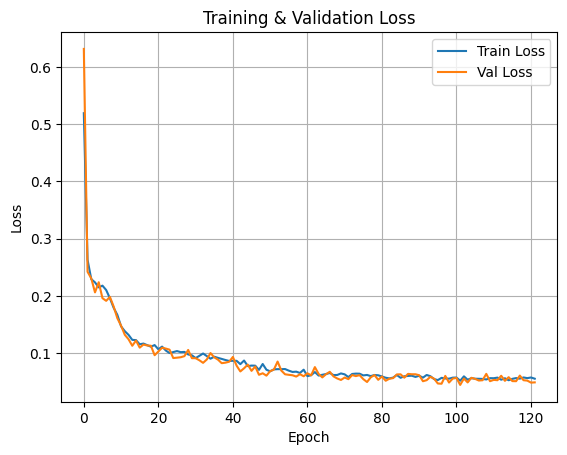

In [414]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


## Model opslaan/inladen

In [ ]:
# torch.save(model, "VGAE_hardneg.pt")


In [564]:
model = torch.load("VGAE_hardneg.pt", map_location=device, weights_only=False)
model.eval()


VGAE_MLP(
  (encoder): GINEncoderWithJK(
    (convs): ModuleList(
      (0-2): 3 x GINConv(nn=Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.3, inplace=False)
        (4): Linear(in_features=64, out_features=64, bias=True)
      ))
    )
    (jump): JumpingKnowledge(cat)
    (conv_mu): GINConv(nn=Sequential(
      (0): Linear(in_features=192, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
    (conv_logstd): GINConv(nn=Sequential(
      (0): Linear(in_features=192, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
  )
  (decoder): MLPDecoder(
    (mlp): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=1,

## Resultaten
corrupt_graph moet opnieuw gedefineerd worden. perongeluk overschreven

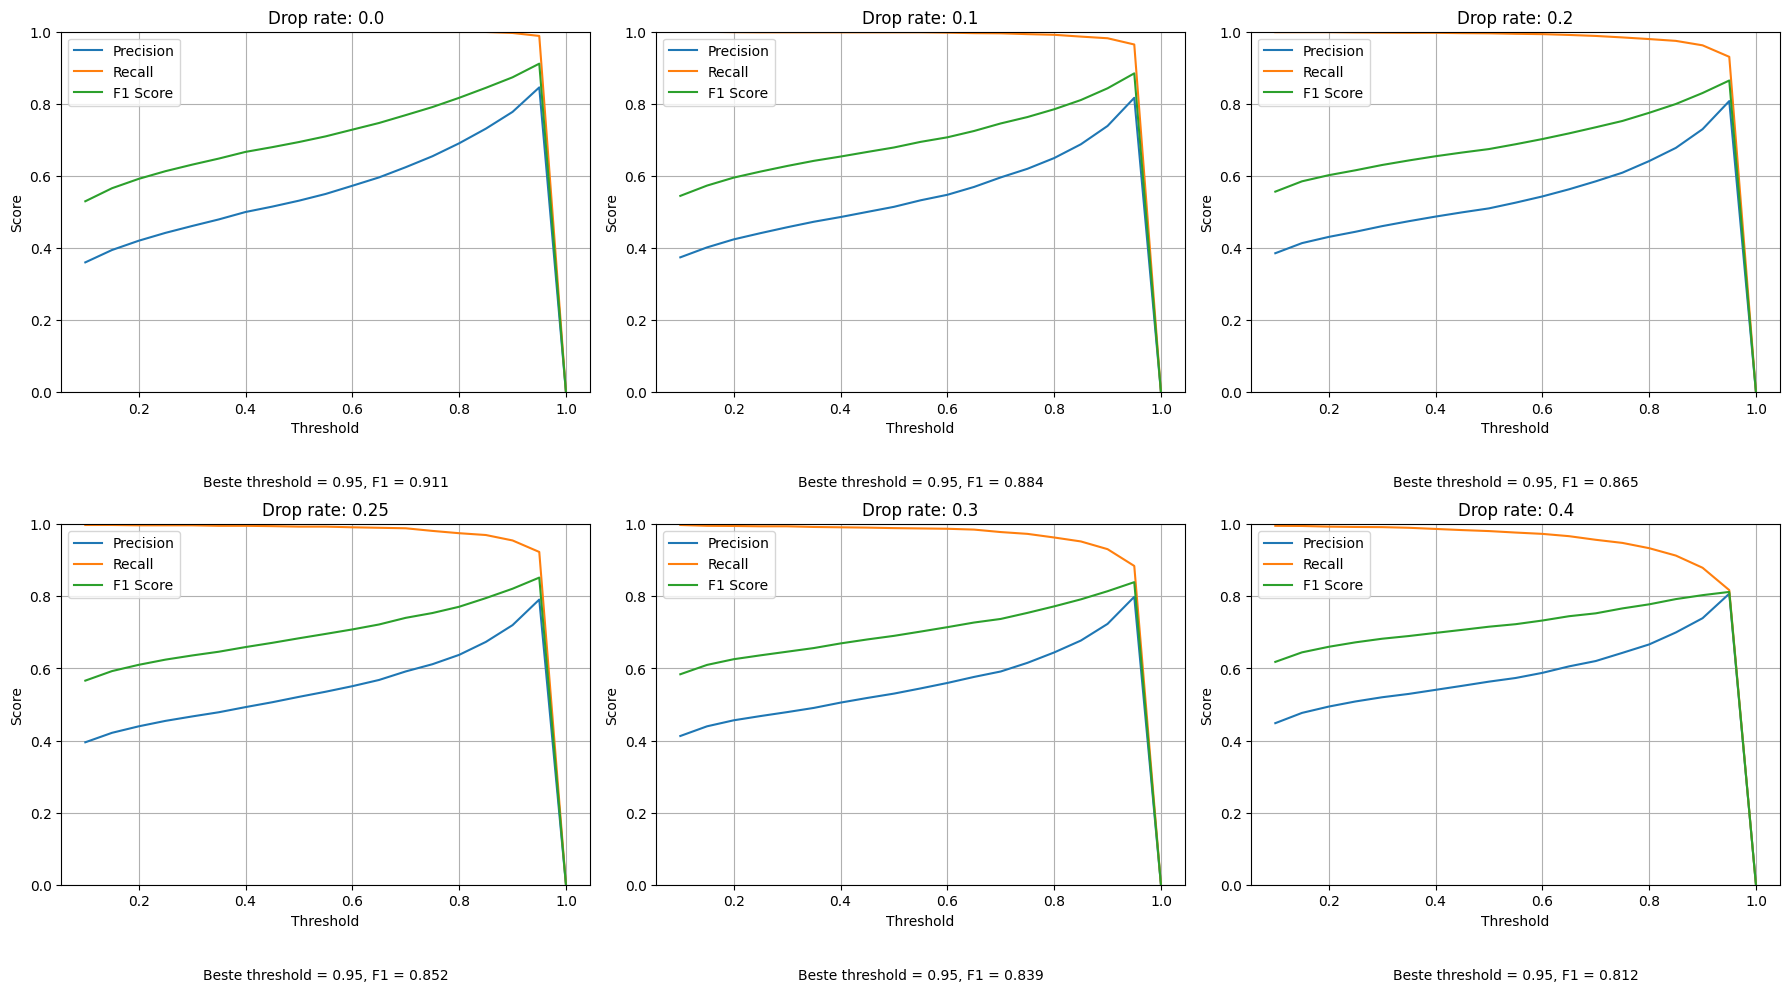

In [ ]:
def corrupt_graph(data, drop_rate=0.25):
    edge_index = data.edge_index
    edge_index, _ = remove_self_loops(edge_index)

    edges = [tuple(sorted((u.item(), v.item()))) for u, v in edge_index.t()]
    unique_edges = list(set(edges))

    num_total = len(unique_edges)
    num_keep = int((1 - drop_rate) * num_total)

    perm = torch.randperm(num_total)[:num_keep]
    kept_edges = [unique_edges[i] for i in perm]

    kept_edges_tensor = torch.tensor(kept_edges, dtype=torch.long).t()
    edge_index_corrupt = to_undirected(kept_edges_tensor)


    neg_edge_index = negative_sampling(
        edge_index=edge_index_corrupt,
        num_nodes=data.num_nodes,
        num_neg_samples=edge_index_corrupt.size(1)
    )

    data.edge_index = edge_index_corrupt
    data.pos_edge_label_index = torch.tensor(unique_edges, dtype=torch.long).t()
    data.neg_edge_label_index = neg_edge_index

    return data

thresholds = thresholds = np.linspace(0.1, 1.0, 19)  

all_results = {}

for drop_rate, loader in val_loaders.items():
    results = evaluate_link_prediction(model, loader, thresholds)
    all_results[drop_rate] = results


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axs = axs.flatten()

for i, (drop_rate, results) in enumerate(sorted(all_results.items())):
    thresholds = [r['threshold'] for r in results]
    precisions = [r['precision'] for r in results]
    recalls = [r['recall'] for r in results]
    f1_scores = [r['f1_score'] for r in results]

    best_idx = max(range(len(f1_scores)), key=lambda j: f1_scores[j])
    best_thresh = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    ax = axs[i]
    ax.plot(thresholds, precisions, label='Precision')
    ax.plot(thresholds, recalls, label='Recall')
    ax.plot(thresholds, f1_scores, label='F1 Score')

    ax.set_title(f'Drop rate: {drop_rate}')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True)

    ax.text(0.5, -0.25,
            f'Beste threshold = {best_thresh:.2f}, F1 = {best_f1:.3f}',
            ha='center', va='center',
            transform=ax.transAxes, fontsize=10)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


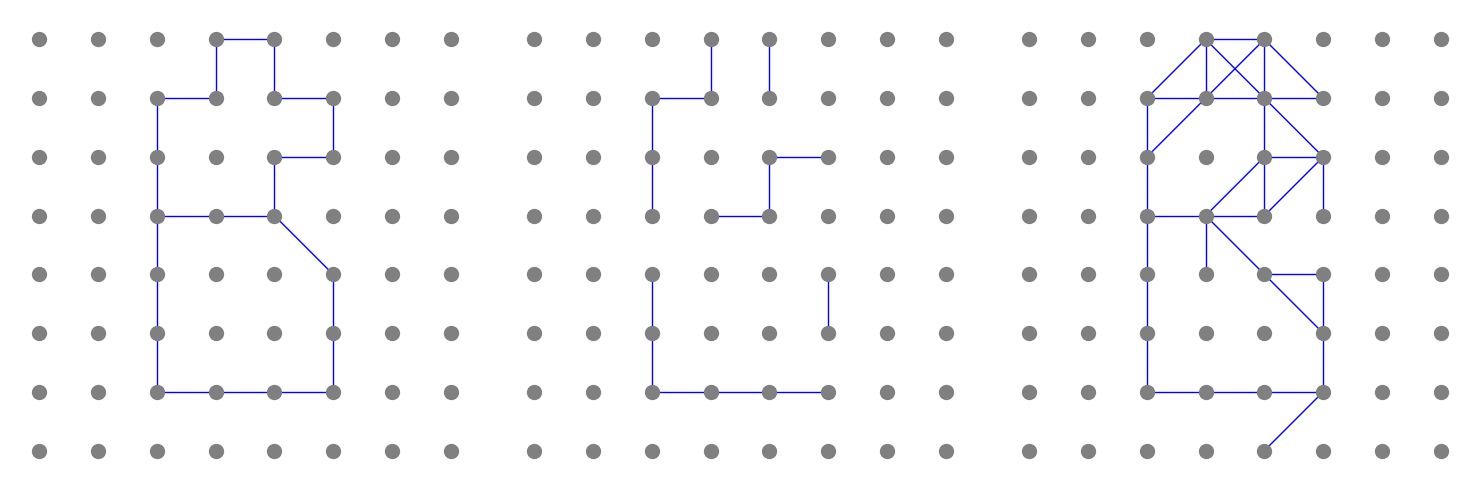

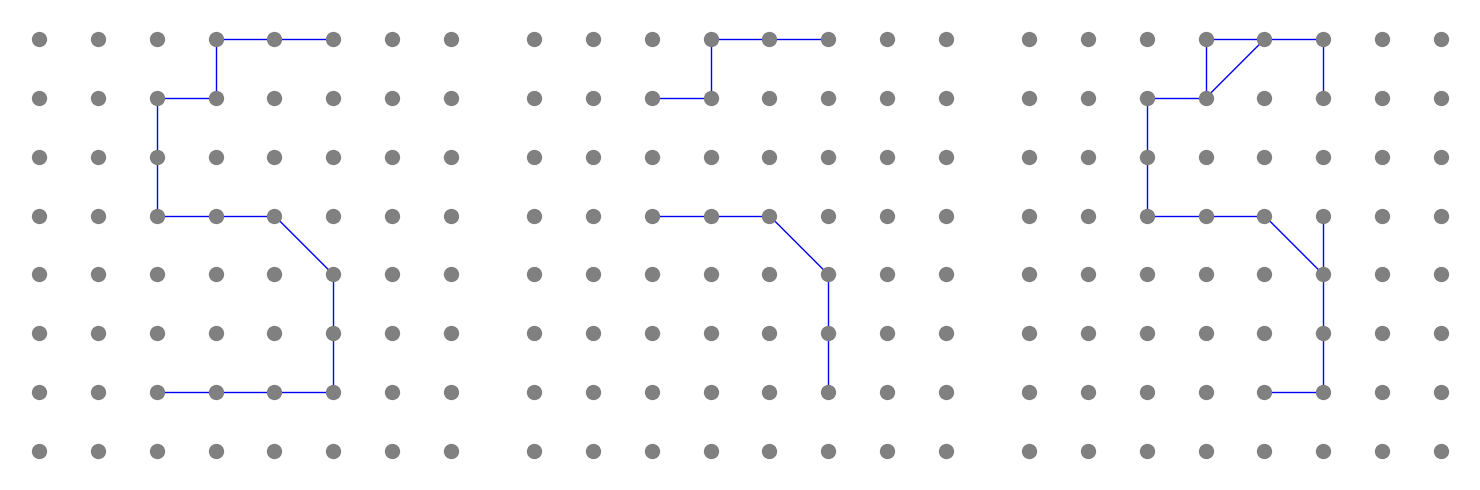

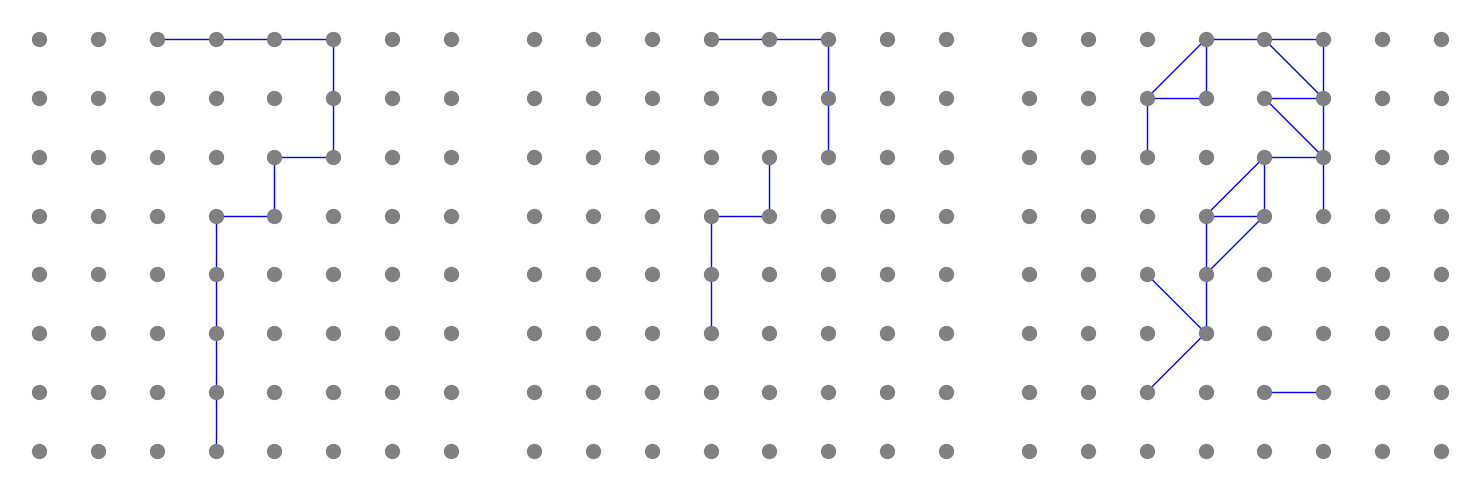

In [ ]:
batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[0])  

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

drop_rate = 0.3
threshold = 0.95
corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)


reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate  
)


batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[1]) 

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)

reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate 
)


batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[10])  

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)

reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate 
)

# Iteratie 12: ratio hard negative sampling

## Modeldefinitie en trainings-/validatiefuncties 

In [ ]:
class GINEncoderWithJK(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        hidden_dim = 2 * out_channels
        dropout_p = 0.3

        self.convs = torch.nn.ModuleList()
        for i in range(3):
            input_dim = in_channels if i == 0 else hidden_dim
            nn = torch.nn.Sequential(
                torch.nn.Linear(input_dim, hidden_dim),
                torch.nn.ReLU(),
                torch.nn.BatchNorm1d(hidden_dim),
                torch.nn.Dropout(p=dropout_p),
                torch.nn.Linear(hidden_dim, hidden_dim)
            )
            self.convs.append(GINConv(nn))

        self.jump = JumpingKnowledge(mode='cat')
        jk_dim = 3 * hidden_dim

        self.conv_mu = GINConv(torch.nn.Sequential(
            torch.nn.Linear(jk_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))
        self.conv_logstd = GINConv(torch.nn.Sequential(
            torch.nn.Linear(jk_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))

    def forward(self, x, edge_index):
        xs = []
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            xs.append(x)
        x = self.jump(xs)
        mu = self.conv_mu(x, edge_index)
        logstd = self.conv_logstd(x, edge_index)
        self.mu = mu
        self.logstd = logstd
        return mu, logstd

class MLPDecoder(torch.nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * latent_dim, latent_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(latent_dim, 1)
        )

    def forward(self, z, edge_index):
        z_i = z[edge_index[0]]
        z_j = z[edge_index[1]]
        z_pair = torch.cat([z_i, z_j], dim=1)
        return self.mlp(z_pair).squeeze()

class VGAE_MLP(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def encode(self, x, edge_index):
        mu, logstd = self.encoder(x, edge_index)
        std = torch.exp(logstd)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, edge_index):
        return self.encode(x, edge_index)

    def decode(self, z, edge_index):
        return self.decoder(z, edge_index)

    def recon_loss(self, z, pos_edge_index, neg_edge_index):
        pos_out = self.decoder(z, pos_edge_index)
        neg_out = self.decoder(z, neg_edge_index)
        
        preds = torch.cat([pos_out, neg_out])
        labels = torch.cat([
            torch.ones_like(pos_out),
            torch.zeros_like(neg_out)
        ])
        
        # Correct gebruik van scalar pos_weight
        pos_weight = len(neg_out) / len(pos_out)
        pos_weight = torch.tensor(pos_weight, device=z.device)

        return F.binary_cross_entropy_with_logits(preds, labels, pos_weight=pos_weight)



    def kl_loss(self):
        mu, logstd = self.encoder.mu, self.encoder.logstd
        return -0.5 * torch.mean(1 + 2 * logstd - mu**2 - (2 * logstd).exp())

def hard_negative_sampling_per_graph(z, pos_edge_index, batch_vec, num_neg_factor=3):
    device = z.device
    neg_edges = []

    num_graphs = batch_vec.max().item() + 1
    for g in range(num_graphs):
        node_mask = (batch_vec == g)
        node_ids = node_mask.nonzero(as_tuple=False).view(-1)

        if node_ids.numel() < 2:
            continue

        z_g = z[node_ids]
        pos_mask = node_mask[pos_edge_index[0]] & node_mask[pos_edge_index[1]]
        pos_edges_g = pos_edge_index[:, pos_mask]

        if pos_edges_g.size(1) == 0:
            continue


        local_pos_edges = torch.searchsorted(node_ids, pos_edges_g[0]), torch.searchsorted(node_ids, pos_edges_g[1])
        local_pos_edges = torch.stack(local_pos_edges, dim=0)

        num_neg = num_neg_factor * local_pos_edges.size(1)
        neg_edges_g = hard_negative_sampling(z_g, local_pos_edges, num_neg)


        neg_edges_g = node_ids[neg_edges_g]
        neg_edges.append(neg_edges_g)

    if len(neg_edges) > 0:
        return torch.cat(neg_edges, dim=1)
    else:
        return torch.empty((2, 0), dtype=torch.long, device=device)


def corrupt_graph(data, drop_rate=0.25):
    edge_index = data.edge_index
    edge_index, _ = remove_self_loops(edge_index)

    edges = [tuple(sorted((u.item(), v.item()))) for u, v in edge_index.t()]
    unique_edges = list(set(edges))

    num_total = len(unique_edges)
    num_keep = int((1 - drop_rate) * num_total)

    perm = torch.randperm(num_total)[:num_keep]
    kept_edges = [unique_edges[i] for i in perm]

    kept_edges_tensor = torch.tensor(kept_edges, dtype=torch.long).t()
    edge_index_corrupt = to_undirected(kept_edges_tensor)

    data.edge_index = edge_index_corrupt
    data.pos_edge_label_index = torch.tensor(unique_edges, dtype=torch.long).t()

    if not hasattr(data, "batch"):
        data.batch = torch.zeros(data.x.size(0), dtype=torch.long)

    model.eval()
    with torch.no_grad():
        z = model.encode(data.x.to(device), edge_index_corrupt.to(device))

    data.neg_edge_label_index = hard_negative_sampling_per_graph(
        z, data.pos_edge_label_index.to(device), data.batch.to(device), num_neg_factor=3
    )

    return data


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = GINEncoderWithJK(in_channels=64, out_channels=32)
decoder = MLPDecoder(latent_dim=32)
model = VGAE_MLP(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_step(data):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)
    pos_edge = data.pos_edge_label_index.to(device)
    neg_edge = data.neg_edge_label_index.to(device)
    loss = model.recon_loss(z, pos_edge, neg_edge)
    loss += (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return loss.item()

def validate_step(data):
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        pos_edge = data.pos_edge_label_index.to(device)
        neg_edge = data.neg_edge_label_index.to(device)
        loss = model.recon_loss(z, pos_edge, neg_edge)
        loss += (1 / data.num_nodes) * model.kl_loss()
    return loss.item()


## Trainloop 

In [ ]:
num_epochs = 500
drop_rate = 0.25
best_val_loss = float('inf')
patience = 20
epochs_no_improve = 0
train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    num_train_batches = 0

    for data in train_loader:
        data = corrupt_graph(data, drop_rate=drop_rate)
        loss = train_step(data)
        total_loss += loss
        num_train_batches += 1

    total_loss_val = 0
    num_val_batches = 0
    model.eval()

    for val_data in val_loader:
        val_data = corrupt_graph(val_data, drop_rate=drop_rate)
        val_loss = validate_step(val_data)
        total_loss_val += val_loss
        num_val_batches += 1

    avg_train_loss = total_loss / num_train_batches
    avg_val_loss = total_loss_val / num_val_batches

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch:03d} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "VGAE_hardneg3.pt")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch:03d}")
        break


Epoch 001 - Train Loss: 0.7471 - Val Loss: 0.6449
Epoch 002 - Train Loss: 0.4087 - Val Loss: 0.3729
Epoch 003 - Train Loss: 0.3812 - Val Loss: 0.3656
Epoch 004 - Train Loss: 0.3694 - Val Loss: 0.3866
Epoch 005 - Train Loss: 0.3575 - Val Loss: 0.3471
Epoch 006 - Train Loss: 0.3582 - Val Loss: 0.3630
Epoch 007 - Train Loss: 0.3447 - Val Loss: 0.3479
Epoch 008 - Train Loss: 0.3473 - Val Loss: 0.3603
Epoch 009 - Train Loss: 0.3348 - Val Loss: 0.3291
Epoch 010 - Train Loss: 0.2911 - Val Loss: 0.2566
Epoch 011 - Train Loss: 0.2607 - Val Loss: 0.2310
Epoch 012 - Train Loss: 0.2392 - Val Loss: 0.2263
Epoch 013 - Train Loss: 0.2287 - Val Loss: 0.2147
Epoch 014 - Train Loss: 0.2192 - Val Loss: 0.2084
Epoch 015 - Train Loss: 0.2173 - Val Loss: 0.2151
Epoch 016 - Train Loss: 0.2074 - Val Loss: 0.2044
Epoch 017 - Train Loss: 0.1967 - Val Loss: 0.1828
Epoch 018 - Train Loss: 0.2052 - Val Loss: 0.1938
Epoch 019 - Train Loss: 0.1876 - Val Loss: 0.1715
Epoch 020 - Train Loss: 0.1725 - Val Loss: 0.1619


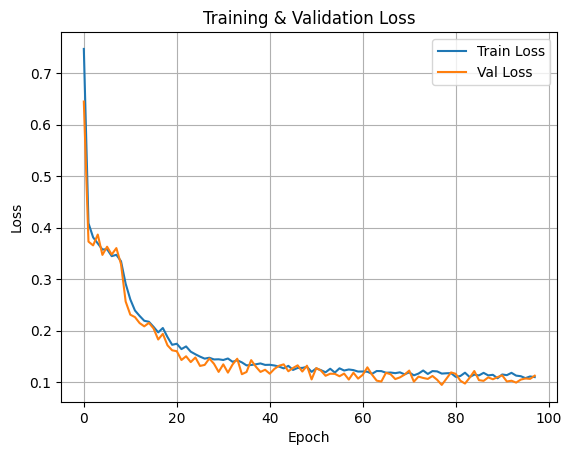

In [53]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


## Model opslaan/inladen

In [ ]:
# torch.save(model, "VGAE_hardneg3.pt")


### VGAE_hardneg23 eind model

In [26]:
model = torch.load("VGAE_hardneg23.pt", map_location=device, weights_only=False)
model.eval()


VGAE_MLP(
  (encoder): GINEncoderWithJK(
    (convs): ModuleList(
      (0-2): 3 x GINConv(nn=Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.3, inplace=False)
        (4): Linear(in_features=64, out_features=64, bias=True)
      ))
    )
    (jump): JumpingKnowledge(cat)
    (conv_mu): GINConv(nn=Sequential(
      (0): Linear(in_features=192, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
    (conv_logstd): GINConv(nn=Sequential(
      (0): Linear(in_features=192, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
  )
  (decoder): MLPDecoder(
    (mlp): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=1,

## Resultaten
corrupt_graph moet opnieuw gedefineerd worden. perongeluk overschreven

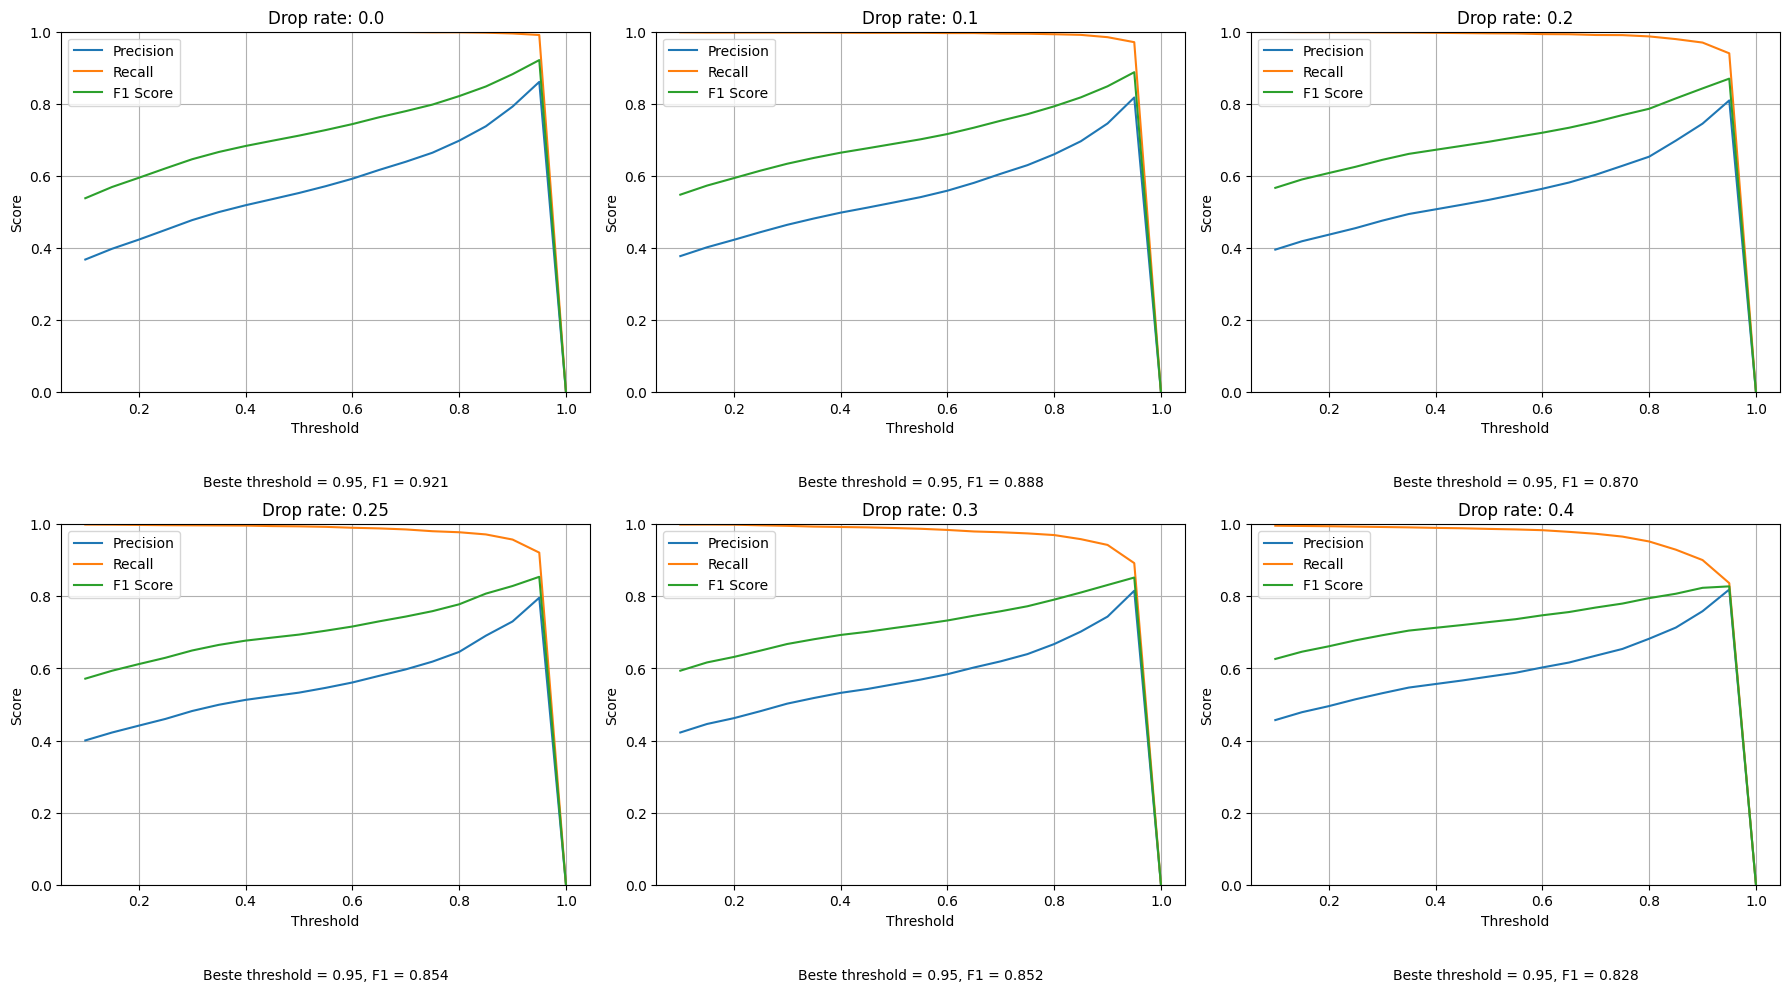

In [ ]:
def corrupt_graph(data, drop_rate=0.25):
    edge_index = data.edge_index
    edge_index, _ = remove_self_loops(edge_index)

    edges = [tuple(sorted((u.item(), v.item()))) for u, v in edge_index.t()]
    unique_edges = list(set(edges))

    num_total = len(unique_edges)
    num_keep = int((1 - drop_rate) * num_total)

    perm = torch.randperm(num_total)[:num_keep]
    kept_edges = [unique_edges[i] for i in perm]

    kept_edges_tensor = torch.tensor(kept_edges, dtype=torch.long).t()
    edge_index_corrupt = to_undirected(kept_edges_tensor)

    neg_edge_index = negative_sampling(
        edge_index=edge_index_corrupt,
        num_nodes=data.num_nodes,
        num_neg_samples=edge_index_corrupt.size(1)
    )

    data.edge_index = edge_index_corrupt
    data.pos_edge_label_index = torch.tensor(unique_edges, dtype=torch.long).t()
    data.neg_edge_label_index = neg_edge_index

    return data

thresholds = thresholds = np.linspace(0.1, 1.0, 19)  

all_results = {}

for drop_rate, loader in val_loaders.items():
    results = evaluate_link_prediction(model, loader, thresholds)
    all_results[drop_rate] = results


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axs = axs.flatten()

for i, (drop_rate, results) in enumerate(sorted(all_results.items())):
    thresholds = [r['threshold'] for r in results]
    precisions = [r['precision'] for r in results]
    recalls = [r['recall'] for r in results]
    f1_scores = [r['f1_score'] for r in results]

    best_idx = max(range(len(f1_scores)), key=lambda j: f1_scores[j])
    best_thresh = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    ax = axs[i]
    ax.plot(thresholds, precisions, label='Precision')
    ax.plot(thresholds, recalls, label='Recall')
    ax.plot(thresholds, f1_scores, label='F1 Score')

    ax.set_title(f'Drop rate: {drop_rate}')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True)

    ax.text(0.5, -0.25,
            f'Beste threshold = {best_thresh:.2f}, F1 = {best_f1:.3f}',
            ha='center', va='center',
            transform=ax.transAxes, fontsize=10)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


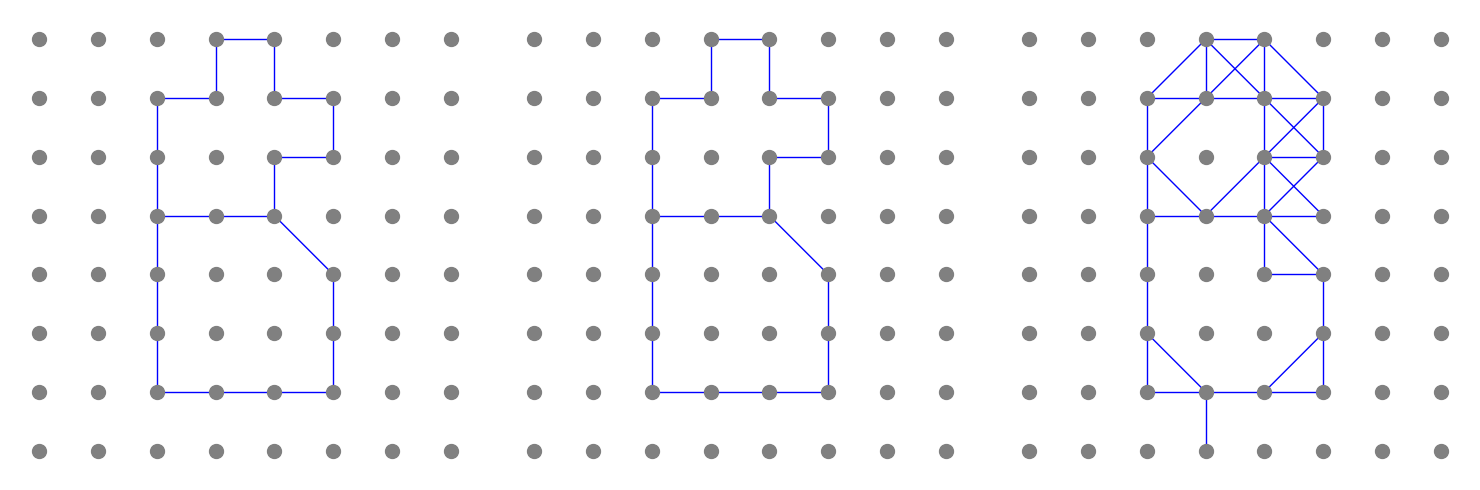

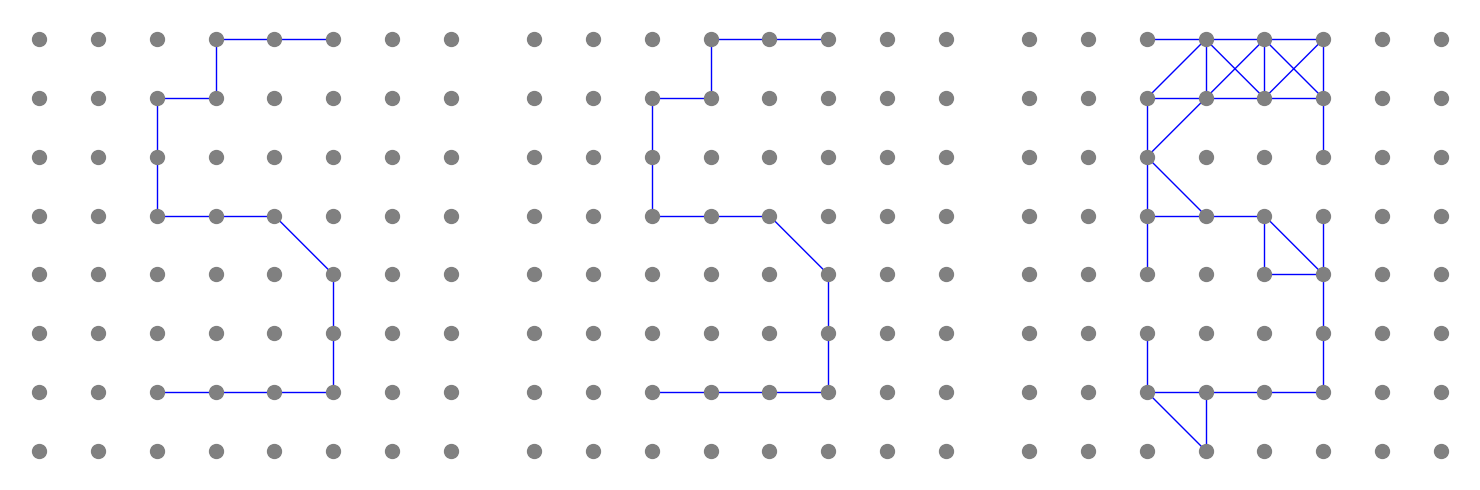

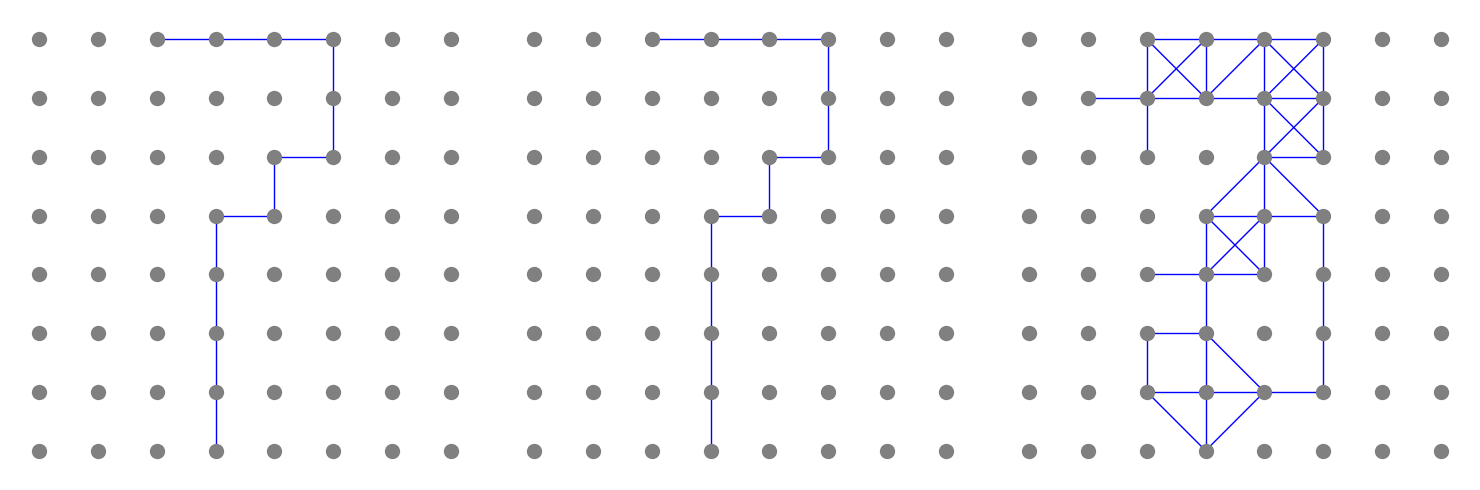

In [ ]:
batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[0])  

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

drop_rate = 0.3
threshold = 0.95
corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)


reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate  
)


batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[1]) 

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)

reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate 
)


batched_data = next(iter(val_loader))
example_data = deepcopy(batched_data[10])  

original_data = deepcopy(example_data)
original_data.pos_edge_label_index = original_data.edge_index.clone()

corrupted_data = corrupt_graph(deepcopy(example_data), drop_rate=drop_rate)


reconstructed_edges = reconstruct_edges(corrupted_data, model, threshold=threshold)

reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
reconstructed_edges = filter_directe_buren(reconstructed_edges)

show_comparison(
    original_data=original_data,
    corrupted_data=corrupted_data,
    reconstructed_edge_index=reconstructed_edges,
    drop_rate=drop_rate 
)

# Final: Trainen op train- + validatieset

## Train en val combineren

In [39]:
# Combineer de datasets
full_train_dataset = ConcatDataset([train_dataset, val_dataset])

# Nieuwe DataLoader zonder shuffling (optioneel afhankelijk van je doel)
full_train_loader = DataLoader(full_train_dataset, batch_size=16, shuffle=True)


## Modeldefinitie en trainings-/validatiefuncties 

In [42]:
# --- GIN Encoder met Jumping Knowledge over 3 lagen ---
class GINEncoderWithJK(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        hidden_dim = 2 * out_channels
        dropout_p = 0.3

        self.convs = torch.nn.ModuleList()
        for i in range(3):
            input_dim = in_channels if i == 0 else hidden_dim
            nn = torch.nn.Sequential(
                torch.nn.Linear(input_dim, hidden_dim),
                torch.nn.ReLU(),
                torch.nn.BatchNorm1d(hidden_dim),
                torch.nn.Dropout(p=dropout_p),
                torch.nn.Linear(hidden_dim, hidden_dim)
            )
            self.convs.append(GINConv(nn))

        self.jump = JumpingKnowledge(mode='cat')
        jk_dim = 3 * hidden_dim

        self.conv_mu = GINConv(torch.nn.Sequential(
            torch.nn.Linear(jk_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))
        self.conv_logstd = GINConv(torch.nn.Sequential(
            torch.nn.Linear(jk_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))

    def forward(self, x, edge_index):
        xs = []
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            xs.append(x)
        x = self.jump(xs)
        mu = self.conv_mu(x, edge_index)
        logstd = self.conv_logstd(x, edge_index)
        self.mu = mu
        self.logstd = logstd
        return mu, logstd

# --- MLP Decoder ---
class MLPDecoder(torch.nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * latent_dim, latent_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(latent_dim, 1)
        )

    def forward(self, z, edge_index):
        z_i = z[edge_index[0]]
        z_j = z[edge_index[1]]
        z_pair = torch.cat([z_i, z_j], dim=1)
        return self.mlp(z_pair).squeeze()

# --- VGAE met MLP decoder ---
class VGAE_MLP(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def encode(self, x, edge_index):
        mu, logstd = self.encoder(x, edge_index)
        std = torch.exp(logstd)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, edge_index):
        return self.encode(x, edge_index)

    def decode(self, z, edge_index):
        return self.decoder(z, edge_index)

    def recon_loss(self, z, pos_edge_index, neg_edge_index):
        pos_out = self.decoder(z, pos_edge_index)
        neg_out = self.decoder(z, neg_edge_index)
        
        preds = torch.cat([pos_out, neg_out])
        labels = torch.cat([
            torch.ones_like(pos_out),
            torch.zeros_like(neg_out)
        ])
        
        # Correct gebruik van scalar pos_weight
        pos_weight = len(neg_out) / len(pos_out)
        pos_weight = torch.tensor(pos_weight, device=z.device)

        return F.binary_cross_entropy_with_logits(preds, labels, pos_weight=pos_weight)



    def kl_loss(self):
        mu, logstd = self.encoder.mu, self.encoder.logstd
        return -0.5 * torch.mean(1 + 2 * logstd - mu**2 - (2 * logstd).exp())

# --- Hard Negative Sampling ---
def hard_negative_sampling_per_graph(z, pos_edge_index, batch_vec, num_neg_factor=3):
    device = z.device
    neg_edges = []

    num_graphs = batch_vec.max().item() + 1
    for g in range(num_graphs):
        node_mask = (batch_vec == g)
        node_ids = node_mask.nonzero(as_tuple=False).view(-1)

        if node_ids.numel() < 2:
            continue

        z_g = z[node_ids]
        pos_mask = node_mask[pos_edge_index[0]] & node_mask[pos_edge_index[1]]
        pos_edges_g = pos_edge_index[:, pos_mask]

        if pos_edges_g.size(1) == 0:
            continue

        local_pos_edges = torch.searchsorted(node_ids, pos_edges_g[0]), torch.searchsorted(node_ids, pos_edges_g[1])
        local_pos_edges = torch.stack(local_pos_edges, dim=0)

        num_neg = num_neg_factor * local_pos_edges.size(1)
        neg_edges_g = hard_negative_sampling(z_g, local_pos_edges, num_neg)

        neg_edges_g = node_ids[neg_edges_g]
        neg_edges.append(neg_edges_g)

    if len(neg_edges) > 0:
        return torch.cat(neg_edges, dim=1)
    else:
        return torch.empty((2, 0), dtype=torch.long, device=device)


# --- Corruptie met hard negative sampling ---
def corrupt_graph(data, drop_rate=0.25):
    edge_index = data.edge_index
    edge_index, _ = remove_self_loops(edge_index)

    edges = [tuple(sorted((u.item(), v.item()))) for u, v in edge_index.t()]
    unique_edges = list(set(edges))

    num_total = len(unique_edges)
    num_keep = int((1 - drop_rate) * num_total)

    perm = torch.randperm(num_total)[:num_keep]
    kept_edges = [unique_edges[i] for i in perm]

    kept_edges_tensor = torch.tensor(kept_edges, dtype=torch.long).t()
    edge_index_corrupt = to_undirected(kept_edges_tensor)

    data.edge_index = edge_index_corrupt
    data.pos_edge_label_index = torch.tensor(unique_edges, dtype=torch.long).t()

    # Zorg dat 'data.batch' bestaat
    if not hasattr(data, "batch"):
        data.batch = torch.zeros(data.x.size(0), dtype=torch.long)

    model.eval()
    with torch.no_grad():
        z = model.encode(data.x.to(device), edge_index_corrupt.to(device))

    data.neg_edge_label_index = hard_negative_sampling_per_graph(
        z, data.pos_edge_label_index.to(device), data.batch.to(device), num_neg_factor=3
    )

    return data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = GINEncoderWithJK(in_channels=64, out_channels=32)
decoder = MLPDecoder(latent_dim=32)
model = VGAE_MLP(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- Train stap ---
def train_step(data):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)
    pos_edge = data.pos_edge_label_index.to(device)
    neg_edge = data.neg_edge_label_index.to(device)
    loss = model.recon_loss(z, pos_edge, neg_edge)
    loss += (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return loss.item()


## Trainloop zonder validatie

In [43]:
num_epochs = 390
drop_rate = 0.25
train_losses = []

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    num_train_batches = 0

    for data in full_train_loader:  # gebruik hier je gecombineerde loader
        data = corrupt_graph(data, drop_rate=drop_rate)
        loss = train_step(data)
        total_loss += loss
        num_train_batches += 1

    avg_train_loss = total_loss / num_train_batches
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch:03d} - Train Loss: {avg_train_loss:.4f}")

    # Optioneel: model opslaan bij elke epoch (of bijvoorbeeld elke 50e epoch)
    torch.save(model.state_dict(), "VGAE_final.pt")

Epoch 001 - Train Loss: 0.6295
Epoch 002 - Train Loss: 0.3427
Epoch 003 - Train Loss: 0.3142
Epoch 004 - Train Loss: 0.2965
Epoch 005 - Train Loss: 0.2552
Epoch 006 - Train Loss: 0.2199
Epoch 007 - Train Loss: 0.1959
Epoch 008 - Train Loss: 0.1877
Epoch 009 - Train Loss: 0.1763
Epoch 010 - Train Loss: 0.1678
Epoch 011 - Train Loss: 0.1666
Epoch 012 - Train Loss: 0.1568
Epoch 013 - Train Loss: 0.1605
Epoch 014 - Train Loss: 0.1547
Epoch 015 - Train Loss: 0.1506
Epoch 016 - Train Loss: 0.1450
Epoch 017 - Train Loss: 0.1427
Epoch 018 - Train Loss: 0.1374
Epoch 019 - Train Loss: 0.1379
Epoch 020 - Train Loss: 0.1327
Epoch 021 - Train Loss: 0.1279
Epoch 022 - Train Loss: 0.1267
Epoch 023 - Train Loss: 0.1271
Epoch 024 - Train Loss: 0.1151
Epoch 025 - Train Loss: 0.1158
Epoch 026 - Train Loss: 0.1148
Epoch 027 - Train Loss: 0.1114
Epoch 028 - Train Loss: 0.1076
Epoch 029 - Train Loss: 0.1072
Epoch 030 - Train Loss: 0.1093
Epoch 031 - Train Loss: 0.1047
Epoch 032 - Train Loss: 0.1004
Epoch 03


## Model opslaan/inladen


In [ ]:
# torch.save(model, "VGAE_final.pt")


In [ ]:
model = torch.load("VGAE_final.pt", map_location=device, weights_only=False)
model.eval()


VGAE_MLP(
  (encoder): GINEncoderWithJK(
    (convs): ModuleList(
      (0-2): 3 x GINConv(nn=Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.3, inplace=False)
        (4): Linear(in_features=64, out_features=64, bias=True)
      ))
    )
    (jump): JumpingKnowledge(cat)
    (conv_mu): GINConv(nn=Sequential(
      (0): Linear(in_features=192, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
    (conv_logstd): GINConv(nn=Sequential(
      (0): Linear(in_features=192, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
  )
  (decoder): MLPDecoder(
    (mlp): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=1,